In [ ]:
!pip install opendatasets
!pip install pandas
!pip install optuna
!pip install catboost
!pip install vecstack

#Import

In [ ]:
SEED = 42
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from sklearn.neural_network import MLPRegressor

from catboost import EFeaturesSelectionAlgorithm
from sklearn.preprocessing import OrdinalEncoder
import optuna
from optuna.samplers import TPESampler
from vecstack import stacking


from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import pickle

In [ ]:
#{"username":"danskuy","key":"45484454edbebbb79a736e62be4ad561"}


In [ ]:
od.download(
    "https://www.kaggle.com/competitions/mini-competition-data-science-gdsc-ui-2024/data")

Skipping, found downloaded files in "./mini-competition-data-science-gdsc-ui-2024" (use force=True to force download)


In [ ]:
def load_dataframe(filename: str):
    removed_cols = ["source_origin_time", "source_origin_uncertainty_sec","snr_db",
               "trace_start_time", "trace_category", "source_depth_uncertainty_km"]
    df = pd.read_csv(filename)
    df = df.drop(removed_cols, axis=1)
    return df

train_data = load_dataframe('/content/mini-competition-data-science-gdsc-ui-2024/train.csv')
test_data = load_dataframe('/content/mini-competition-data-science-gdsc-ui-2024/test.csv')
wave_data = pd.read_pickle('/content/mini-competition-data-science-gdsc-ui-2024/waveform.pickle')
wave_data

{'109C.TA_20061103155652_EV':         east-west   north-south      vertical
 0      -15.846739    -76.309113    -26.191010
 1       -0.749337    -70.387016    -26.302448
 2       14.340230    -64.939369    -28.878653
 3       26.836971    -62.624603    -33.842709
 4       35.166748    -64.044380    -38.634914
 ..            ...           ...           ...
 695  29126.613281  -3182.400879 -41072.484375
 696  39786.468750  -9373.139648 -26313.175781
 697  45984.691406 -12485.842773  -9890.931641
 698  48384.312500 -12570.393555   4159.087402
 699  47749.750000 -10214.503906  13271.954102
 
 [700 rows x 3 columns],
 '109C.TA_20061103161223_EV':        east-west  north-south     vertical
 0       0.000000    -0.000000    -0.000000
 1       0.005252    -0.002586    -0.026754
 2       0.006549    -0.014252    -0.068130
 3       0.009353    -0.030463    -0.156800
 4      -0.016729    -0.037433    -0.155339
 ..           ...          ...          ...
 695  -792.880310  -594.703430  2767.579834

In [ ]:
display(train_data.info())
display(train_data.describe())
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
display(test_data.info())
display(test_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   network_code                      8000 non-null   object 
 1   receiver_code                     8000 non-null   object 
 2   receiver_type                     8000 non-null   object 
 3   receiver_latitude                 8000 non-null   float64
 4   receiver_longitude                8000 non-null   float64
 5   receiver_elevation_m              8000 non-null   float64
 6   p_arrival_sample                  8000 non-null   float64
 7   p_status                          8000 non-null   object 
 8   p_weight                          8000 non-null   float64
 9   s_arrival_sample                  8000 non-null   float64
 10  source_id                         8000 non-null   object 
 11  source_latitude                   8000 non-null   float64
 12  source

None

receiver_latitude  receiver_longitude  receiver_elevation_m  \
count        8000.000000         8000.000000           8000.000000   
mean           39.647452          -67.543466            513.258687   
std            14.771716          100.327531            630.746606   
min           -33.204700         -174.197500              0.000000   
25%            36.213560         -155.263462            116.000000   
50%            40.436000         -120.515300            277.000000   
75%            52.201600           23.021300            625.000000   
max            64.564600          179.300000           2894.000000   

       p_arrival_sample     p_weight  s_arrival_sample  source_latitude  \
count       8000.000000  8000.000000       8000.000000      8000.000000   
mean         518.259028     0.522931       1858.083939        39.542139   
std           80.027327     0.189508        783.361434        14.670854   
min          353.000000     0.000000        701.000000       -33.313400   
25%          500.000000     0.500000       1300.000000        36.328075   
50%          500.000000     0.500000       1720.000000        40.391000   
75%          600.000000     0.560000       2230.250000        51.690125   
max          699.200000     1.000000       5268.000000        67.271100   

       source_longitude  source_error_sec  source_gap_deg  \
count       8000.000000       5644.000000     5184.000000   
mean         -72.844585          0.967077      110.269688   
std           96.358854          0.485257       75.792669   
min         -179.971300          0.030000        5.282000   
25%         -155.278500          0.610000       45.906750   
50%         -121.177500          0.959600       91.293500   
75%           22.142600          1.274825      164.400750   
max          179.962600          3.000000      349.000000   

       source_horizontal_uncertainty_km  source_depth_km  back_azimuth_deg  
count                       4203.000000      8000.000000       8000.000000  
mean                           4.155086        32.727378        176.285444  
std                            2.453588        38.126210        105.499020  
min                            0.000000        -1.260000          0.100000  
25%                            2.328805         9.210000         85.500000  
50%                            3.799000        16.380000        165.950000  
75%                            5.843435        41.200000        275.500000  
max                            9.999580       278.900000        359.900000

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   network_code                      1576 non-null   object 
 1   receiver_code                     1576 non-null   object 
 2   receiver_type                     1576 non-null   object 
 3   receiver_latitude                 1576 non-null   float64
 4   receiver_longitude                1576 non-null   float64
 5   receiver_elevation_m              1576 non-null   float64
 6   p_arrival_sample                  1576 non-null   float64
 7   p_status                          1576 non-null   object 
 8   p_weight                          1576 non-null   float64
 9   source_id                

None

receiver_latitude  receiver_longitude  receiver_elevation_m  \
count        1576.000000         1576.000000           1576.000000   
mean           33.757339         -116.762810           1302.193782   
std             0.889300            0.843519            217.872846   
min            33.495500         -120.515300            386.800000   
25%            33.557500         -116.602667           1271.000000   
50%            33.611570         -116.596005           1374.800000   
75%            33.611570         -116.456370           1392.000000   
max            48.460700         -116.456370           1467.000000   

       p_arrival_sample     p_weight  source_latitude  source_longitude  \
count       1576.000000  1576.000000      1576.000000       1576.000000   
mean         536.337563     0.545108        33.676442       -116.686576   
std           72.842262     0.247613         1.077398          1.046765   
min          366.000000     0.000000        31.282000       -121.237833   
25%          500.000000     0.420000        33.064000       -117.000393   
50%          500.000000     0.580000        33.514000       -116.442800   
75%          600.000000     0.660000        34.035050       -116.032457   
max          699.000000     1.000000        48.734167       -115.242000   

       source_error_sec  source_gap_deg  source_horizontal_uncertainty_km  \
count        499.000000      796.000000                        498.000000   
mean           0.315033       73.448704                          0.768658   
std            0.246941       52.090883                          0.974455   
min            0.070000       10.000000                          0.120000   
25%            0.190000       32.766500                          0.230000   
50%            0.230000       56.000000                          0.290000   
75%            0.300000      102.000000                          0.985000   
max            1.739800      326.000000                          7.700000   

       source_depth_km  back_azimuth_deg  
count      1574.000000       1576.000000  
mean          8.362205        190.402665  
std           4.943955        100.041272  
min          -0.040000          0.000000  
25%           4.330000        127.750000  
50%           7.795000        158.200000  
75%          11.817500        299.225000  
max          24.900000        359.900000

In [ ]:
train_col = train_data.columns
test_col = test_data.columns
print(train_col)
print(test_col)

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 's_arrival_sample', 'source_id',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'back_azimuth_deg', 'trace_name'],
      dtype='object')
Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'source_id', 'source_latitude',
       'source_longitude', 'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'back_azimuth_deg', 'trace_name'],
      dtype='object')


In [ ]:
data_stat = pd.DataFrame()
data_stat.index = train_data.columns
data_stat["missing_sum"] = train_data.isna().sum()
data_stat["missing_rate"] = train_data.isna().mean()
data_stat["dtype"] = train_data.dtypes
data_stat

missing_sum  missing_rate    dtype
network_code                                0      0.000000   object
receiver_code                               0      0.000000   object
receiver_type                               0      0.000000   object
receiver_latitude                           0      0.000000  float64
receiver_longitude                          0      0.000000  float64
receiver_elevation_m                        0      0.000000  float64
p_arrival_sample                            0      0.000000  float64
p_status                                    0      0.000000   object
p_weight                                    0      0.000000  float64
s_arrival_sample                            0      0.000000  float64
source_id                                   0      0.000000   object
source_latitude                             0      0.000000  float64
source_longitude                            0      0.000000  float64
source_error_sec                         2356      0.294500  float64
source_gap_deg                           2816      0.352000  float64
source_horizontal_uncertainty_km         3797      0.474625  float64
source_depth_km                             0      0.000000  float64
back_azimuth_deg                            0      0.000000  float64
trace_name                                  0      0.000000   object

In [ ]:
data_stat = pd.DataFrame()
data_stat.index = test_data.columns
data_stat["missing_sum"] = test_data.isna().sum()
data_stat["missing_rate"] = test_data.isna().mean()
data_stat["dtype"] = test_data.dtypes
data_stat

missing_sum  missing_rate    dtype
network_code                                0      0.000000   object
receiver_code                               0      0.000000   object
receiver_type                               0      0.000000   object
receiver_latitude                           0      0.000000  float64
receiver_longitude                          0      0.000000  float64
receiver_elevation_m                        0      0.000000  float64
p_arrival_sample                            0      0.000000  float64
p_status                                    0      0.000000   object
p_weight                                    0      0.000000  float64
source_id                                   0      0.000000   object
source_latitude                             0      0.000000  float64
source_longitude                            0      0.000000  float64
source_error_sec                         1077      0.683376  float64
source_gap_deg                            780      0.494924  float64
source_horizontal_uncertainty_km         1078      0.684010  float64
source_depth_km                             2      0.001269  float64
back_azimuth_deg                            0      0.000000  float64
trace_name                                  0      0.000000   object

# Imputation

## Train_imputation

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   network_code                      8000 non-null   object 
 1   receiver_code                     8000 non-null   object 
 2   receiver_type                     8000 non-null   object 
 3   receiver_latitude                 8000 non-null   float64
 4   receiver_longitude                8000 non-null   float64
 5   receiver_elevation_m              8000 non-null   float64
 6   p_arrival_sample                  8000 non-null   float64
 7   p_status                          8000 non-null   object 
 8   p_weight                          8000 non-null   float64
 9   s_arrival_sample                  8000 non-null   float64
 10  source_id                         8000 non-null   object 
 11  source_latitude                   8000 non-null   float64
 12  source

In [ ]:
train_eng = train_data.copy()
train_eng.interpolate(method= 'spline',limit_direction = 'both', order = 3, inplace=True)
print(train_eng.isna().sum().sum()/train_eng.shape[0])

0.0


In [ ]:
train_obj_col = list(train_eng.select_dtypes("object").columns)

for col in train_obj_col:
    train_eng[col] = train_eng[col].astype("category")
    train_eng[col] = train_eng[col].astype("category")

train_cat_col = list(train_eng.select_dtypes("category").columns)
train_float_col = list(train_eng.select_dtypes("float").columns)

float_train_eng = train_eng[train_float_col]
cat_train_eng = train_eng[train_cat_col]

display(float_train_eng.describe())
print("\n")
display(cat_train_eng.describe())


receiver_latitude  receiver_longitude  receiver_elevation_m  \
count        8000.000000         8000.000000           8000.000000   
mean           39.647452          -67.543466            513.258687   
std            14.771716          100.327531            630.746606   
min           -33.204700         -174.197500              0.000000   
25%            36.213560         -155.263462            116.000000   
50%            40.436000         -120.515300            277.000000   
75%            52.201600           23.021300            625.000000   
max            64.564600          179.300000           2894.000000   

       p_arrival_sample     p_weight  s_arrival_sample  source_latitude  \
count       8000.000000  8000.000000       8000.000000      8000.000000   
mean         518.259028     0.522931       1858.083939        39.542139   
std           80.027327     0.189508        783.361434        14.670854   
min          353.000000     0.000000        701.000000       -33.313400   
25%          500.000000     0.500000       1300.000000        36.328075   
50%          500.000000     0.500000       1720.000000        40.391000   
75%          600.000000     0.560000       2230.250000        51.690125   
max          699.200000     1.000000       5268.000000        67.271100   

       source_longitude  source_error_sec  source_gap_deg  \
count       8000.000000       8000.000000     8000.000000   
mean         -72.844585          0.891574      105.377403   
std           96.358854          0.454485     1395.210657   
min         -179.971300         -0.078803   -75652.772727   
25%         -155.278500          0.580775       51.731624   
50%         -121.177500          0.876850      119.555640   
75%           22.142600          1.140850      198.314674   
max          179.962600          3.000000     2533.401479   

       source_horizontal_uncertainty_km  source_depth_km  back_azimuth_deg  
count                       8000.000000      8000.000000       8000.000000  
mean                           4.633945        32.727378        176.285444  
std                            3.081423        38.126210        105.499020  
min                           -9.307955        -1.260000          0.100000  
25%                            2.289928         9.210000         85.500000  
50%                            4.421605        16.380000        165.950000  
75%                            7.043579        41.200000        275.500000  
max                           23.058593       278.900000        359.900000

network_code receiver_code receiver_type p_status  source_id  \
count          8000          8000          8000     8000       8000   
unique           40           157             6        3       6562   
top              AV          ATKA            BH   manual  606932555   
freq           1730           464          3756     7334          8   

                       trace_name  
count                        8000  
unique                       8000  
top     109C.TA_20061103155652_EV  
freq                            1

## Test Imputation

In [ ]:
test_data.isnull().sum()

network_code                           0
receiver_code                          0
receiver_type                          0
receiver_latitude                      0
receiver_longitude                     0
receiver_elevation_m                   0
p_arrival_sample                       0
p_status                               0
p_weight                               0
source_id                              0
source_latitude                        0
source_longitude                       0
source_error_sec                    1077
source_gap_deg                       780
source_horizontal_uncertainty_km    1078
source_depth_km                        2
back_azimuth_deg                       0
trace_name                             0
dtype: int64

In [ ]:
test_eng = test_data.copy()
test_eng.interpolate(method= 'spline', limit_direction = 'both',
                     order = 3,
                     inplace=True)
test_eng.isna().sum()

network_code                        0
receiver_code                       0
receiver_type                       0
receiver_latitude                   0
receiver_longitude                  0
receiver_elevation_m                0
p_arrival_sample                    0
p_status                            0
p_weight                            0
source_id                           0
source_latitude                     0
source_longitude                    0
source_error_sec                    0
source_gap_deg                      0
source_horizontal_uncertainty_km    0
source_depth_km                     0
back_azimuth_deg                    0
trace_name                          0
dtype: int64

In [ ]:
test_obj_col = list(test_eng.select_dtypes("object").columns)

for col in test_obj_col:
    test_eng[col] = test_eng[col].astype("category")
    test_eng[col] = test_eng[col].astype("category")

test_cat_col = list(test_eng.select_dtypes("category").columns)
test_float_col = list(test_eng.select_dtypes("float").columns)

float_test_eng = test_eng[test_float_col]
cat_test_eng = test_eng[test_cat_col]

In [ ]:
import numpy as np
def kfold_cv(model, X, y):
    kf = KFold(n_splits=5,
               #random_state = 42, shuffle = True
               )
    scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train, cat_features=['network_code','receiver_code','receiver_type','p_status'])
        predictions = model.predict(X_val)

        rmse_score = mse(y_val, predictions, squared=False)
        scores.append(rmse_score)

    return np.mean(scores)

In [ ]:
interpolataion_method = [#'polynomial',
                         'spline',
                         #'barycentric', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline', 'from_derivatives'
                        ]
# #Niatnya mau bikin fungsi buat nyari fungsi interpolasi terbaik
def find_best_interpolation(train_df, interpolataion_method,train_df_cols_with_missing):
    for method in interpolataion_method:
        if method == 'polynomial' or method == 'spline':
            order = [1,2,3,4]
            for orde in order:
                tes = train_df.copy()
                for missing in train_df_cols_with_missing:
                    tes[missing].interpolate(method= method, limit_direction = 'both',
                                              order = orde,
                                              inplace=True)

                model = cb.CatBoostRegressor(verbose=0)
                x = tes.drop(columns = ['source_id', 'trace_name', 's_arrival_sample'])
                y = tes.s_arrival_sample
                score = kfold_cv(model, x, y)
                print(f'{method} {orde} : {score}')


        else:
            tes = train_df.copy()
            for missing in train_df_cols_with_missing:
                tes[missing].interpolate(method= method,limit_direction = 'both',
                                          inplace=True)

            model = cb.CatBoostRegressor(verbose=0)
            x = tes.drop(columns = ['source_id', 'trace_name', 's_arrival_sample'])
            y = tes.s_arrival_sample
            score = kfold_cv(model, x, y)
            print(f'{method} : {score}')

In [ ]:
train_df_cols_with_missing = [col for col in train_data.columns
                     if train_data[col].isnull().any()]

test_df_cols_with_missing = [col for col in test_data.columns
                     if test_data[col].isnull().any()]
train_df_cols_with_missing

['source_error_sec', 'source_gap_deg', 'source_horizontal_uncertainty_km']

In [ ]:
find_best_interpolation(train_data, interpolataion_method, train_df_cols_with_missing)

spline 1 : 635.4036643671236
spline 2 : 641.7150946658493
spline 3 : 630.3292036617208
spline 4 : 653.0942321490878


# Feature engineering

In [ ]:
def rotate(df):
    '''
    input: dataframe containing Latitude(x) and Longitude(y)
    '''
    rot_30 = math.pi / 6

    for deg, rad in zip([30], [rot_30]):
        df[f"rot_{deg}_x"] = (
            df["source_longitude"] * math.cos(rad)
            + df["source_latitude"] * math.sin(rad)
        )
        df[f"rot_{deg}_y"] = (
            df["source_longitude"] * math.sin(rad)
            - df["source_latitude"] * math.cos(rad)
        )

    return df

def extract_waveform_min(df, wv=wave_data):
    '''
    Extract waveform information to dataframe
    '''
    trace_name_values = df["trace_name"].values
    flatten_values = np.array([wv[key].agg(["min"]).T.values.flatten()
                               for idx, key in enumerate(trace_name_values)])
    new_columns = [direction + "_min" for direction in ["east-west", "north-south", "vertical"]]

    wv_aggdata = pd.DataFrame(flatten_values, columns=new_columns)
    wv_aggdata["trace_name"] = trace_name_values

    df = pd.merge(df, wv_aggdata, on="trace_name")
    #df = df.drop(["trace_name"], axis=1)
    return df


def extract_waveform_max(df, wv=wave_data):
    '''
    Extract waveform information to dataframe
    '''
    trace_name_values = df["trace_name"].values
    flatten_values = np.array([wv[key].agg(["max"]).T.values.flatten()
                               for idx, key in enumerate(trace_name_values)])
    new_columns = [direction + "_max" for direction in ["east-west", "north-south", "vertical"]]

    wv_aggdata = pd.DataFrame(flatten_values, columns=new_columns)
    wv_aggdata["trace_name"] = trace_name_values

    df = pd.merge(df, wv_aggdata, on="trace_name")
    #df = df.drop(["trace_name"], axis=1)
    return df


def extract_waveform_mean(df, wv=wave_data):
    '''
    Extract waveform information to dataframe
    '''
    trace_name_values = df["trace_name"].values
    flatten_values = np.array([wv[key].agg(["mean"]).T.values.flatten()
                               for idx, key in enumerate(trace_name_values)])
    new_columns = [direction + "_mean" for direction in ["east-west", "north-south", "vertical"]]

    wv_aggdata = pd.DataFrame(flatten_values, columns=new_columns)
    wv_aggdata["trace_name"] = trace_name_values

    df = pd.merge(df, wv_aggdata, on="trace_name")
    #df = df.drop(["trace_name"], axis=1)
    return df

In [ ]:
train_eng = train_eng.pipe(rotate).pipe(extract_waveform_min).pipe(extract_waveform_max).pipe(extract_waveform_mean)
test_eng = test_eng.pipe(rotate).pipe(extract_waveform_min).pipe(extract_waveform_max).pipe(extract_waveform_mean)

# test_eng = FeatureEngineering(test)
# test_eng.run()

display(train_eng)

network_code receiver_code receiver_type  receiver_latitude  \
0              TA          109C            BH            32.8889   
1              TA          109C            BH            32.8889   
2              TA          109C            BH            32.8889   
3              TA          109C            BH            32.8889   
4              TA          109C            BH            32.8889   
...           ...           ...           ...                ...   
7995           PB          B075            EH            35.9292   
7996           PB          B075            EH            35.9292   
7997           PB          B075            EH            35.9292   
7998           PB          B075            EH            35.9292   
7999           PB          B075            EH            35.9292   

      receiver_longitude  receiver_elevation_m  p_arrival_sample p_status  \
0              -117.1051                 150.0             600.0   manual   
1              -117.1051                 150.0             500.0   manual   
2              -117.1051                 150.0             600.0   manual   
3              -117.1051                 150.0             500.0   manual   
4              -117.1051                 150.0             400.0   manual   
...                  ...                   ...               ...      ...   
7995           -120.5153                 583.0             500.0   manual   
7996           -120.5153                 583.0             500.0   manual   
7997           -120.5153                 583.0             600.0   manual   
7998           -120.5153                 583.0             600.0   manual   
7999           -120.5153                 583.0             600.0   manual   

      p_weight  s_arrival_sample  ...   rot_30_y  east-west_min  \
0         0.50            1763.0  ... -86.347999  -53717.921875   
1         0.50            1678.0  ... -86.358341   -6843.845703   
2         0.50            1777.0  ... -86.349567   -2087.683105   
3         0.50            1416.0  ... -86.721505  -11933.380859   
4         0.50            1642.0  ... -86.281978   -1029.782593   
...        ...               ...  ...        ...            ...   
7995      0.42            1553.0  ... -91.953410    -126.546539   
7996      0.58            1669.0  ... -92.119837     -33.279408   
7997      0.69            1364.0  ... -91.695697    -316.949402   
7998      0.68            1355.0  ... -91.689688    -121.896759   
7999      0.66            1124.0  ... -91.769641    -901.378784   

      north-south_min  vertical_min  east-west_max  north-south_max  \
0       -41698.269531 -61380.484375   53423.257812     47720.777344   
1        -3835.397461  -7257.508301    6981.000000      6608.652832   
2        -1062.910522  -4226.924316    2440.126465      1924.669067   
3        -9689.446289 -30464.853516    9800.207031     10738.118164   
4        -1192.365234  -1475.360840    1743.763794       966.345947   
...               ...           ...            ...              ...   
7995      -146.230087   -280.906433     119.368210       140.853882   
7996       -30.869980    -47.437664      29.085228        40.343426   
7997      -227.055832   -383.400635     320.925018       121.451767   
7998       -66.206047   -173.226013     164.626434        77.484451   
7999      -600.175903  -1168.207642     939.319824       741.860229   

      vertical_max  east-west_mean north-south_mean  vertical_mean  
0     81341.898438       84.469360        89.565384      41.821846  
1     10261.198242       -0.770175       -16.060446       0.869886  
2      5462.071777       -0.357383         3.172882      -5.230489  
3     25230.679688        4.525776        23.651697      55.239491  
4      1784.891235        1.673100         1.411661       0.858895  
...            ...             ...              ...            ...  
7995    270.739777        0.037018         0.268211      -0.571149  
7996     61.507439       -0.091189        -0.016111  

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from scipy.special import expit
import scipy.stats
from sklearn.cluster import KMeans
from scipy.signal import cwt, find_peaks

# Feature engineering
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

def feature_engineering(train_df):
  # 1. Geographical Features
  train_df['distance_receiver_source_km'] = train_df.apply(lambda row: calculate_distance(row['receiver_latitude'], row['receiver_longitude'], row['source_latitude'], row['source_longitude']), axis=1)

  train_df['angle_receiver_source'] = np.arctan2(train_df['source_latitude'] - train_df['receiver_latitude'], train_df['source_longitude'] - train_df['receiver_longitude'])
  # 5. Depth Features
  depth_bins = [-np.inf, 50, 300, np.inf]
  depth_labels = ['shallow', 'intermediate', 'deep']
  train_df['depth_category'] = pd.cut(train_df['source_depth_km'], bins=depth_bins, labels=depth_labels)
  # 12. Source Error Features
  train_df['source_error_km'] = train_df['source_error_sec'] * train_df['source_horizontal_uncertainty_km']
  # 13. Receiver Elevation Range Features
  elevation_bins = [-np.inf, 1000, 2000, np.inf]
  elevation_labels = ['low', 'medium', 'high']
  train_df['receiver_elevation_category'] = pd.cut(train_df['receiver_elevation_m'], bins=elevation_bins, labels=elevation_labels)
  # 14. Receiver-Source Elevation Difference
  train_df['elevation_difference'] = train_df['receiver_elevation_m'] - train_df['source_depth_km']
  # 17. Interaction Features (between numerical features)
  train_df['distance_elevation_interaction'] = train_df['distance_receiver_source_km'] * train_df['receiver_elevation_m']

  # Distance Features
  train_df['distance_between_locations'] = np.sqrt((train_df['receiver_latitude'] - train_df['source_latitude'])**2 +
                                            (train_df['receiver_longitude'] - train_df['source_longitude'])**2)

  # Directional Features
  #train_df['ground_motion_magnitude'] = np.sqrt(train_df['east-west_mean_y']**2 + train_df['north-south_mean_y']**2 + train_df['vertical_mean_y']**2)

  # Signal-to-Noise Ratio (SNR) Features
  #train_df['log_snr_db'] = np.log(train_df['snr_db'] + 1)  # Adding 1 to avoid log(0)

  # Interaction Features
  train_df['latitude_longitude_product'] = train_df['receiver_latitude'] * train_df['receiver_longitude']

  # Temporal and Spatial Discrepancies
  train_df['depth_elevation_discrepancy'] = train_df['source_depth_km'] - train_df['receiver_elevation_m']
  # Geographical clustering
  kmeans = KMeans(n_clusters=5, random_state=42)
  train_df['cluster_label'] = kmeans.fit_predict(train_df[['receiver_latitude', 'receiver_longitude']])

  # Distance Features (Great-circle distance)
  def haversine(lat1, lon1, lat2, lon2):
      """
      Calculate the great-circle distance between two points on the Earth's surface.
      """
      R = 6371  # Earth radius in kilometers
      dlat = np.radians(lat2 - lat1)
      dlon = np.radians(lon2 - lon1)
      a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
      c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
      return R * c

  train_df['great_circle_distance_km'] = haversine(train_df['receiver_latitude'], train_df['receiver_longitude'], train_df['source_latitude'], train_df['source_longitude'])

  # Directional Features
  #train_df['ground_motion_direction_deg'] = np.degrees(np.arctan2(train_df['north-south_mean_y'], train_train_df['east-west_mean_y']))

  # Trigonometric Features
  train_df['cos_back_azimuth_deg'] = np.cos(np.radians(train_df['back_azimuth_deg']))

  # Frequency Domain Features
  def calculate_power_spectrum(signal):
      fft_vals = np.fft.fft(signal)
      return np.abs(fft_vals)**2

  train_df['east_west_power_spectrum'] = calculate_power_spectrum(train_df['east-west_mean'])

  # Fractal Dimension Features
  # (Assuming you have a library or function to compute fractal dimension
  return train_df


In [ ]:
train_eng = train_eng.pipe(feature_engineering)
test_eng = test_eng.pipe(feature_engineering)
display(train_eng.head())
display(test_eng.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



network_code receiver_code receiver_type  receiver_latitude  \
0           TA          109C            BH            32.8889   
1           TA          109C            BH            32.8889   
2           TA          109C            BH            32.8889   
3           TA          109C            BH            32.8889   
4           TA          109C            BH            32.8889   

   receiver_longitude  receiver_elevation_m  p_arrival_sample p_status  \
0           -117.1051                 150.0             600.0   manual   
1           -117.1051                 150.0             500.0   manual   
2           -117.1051                 150.0             600.0   manual   
3           -117.1051                 150.0             500.0   manual   
4           -117.1051                 150.0             400.0   manual   

   p_weight  s_arrival_sample  ... receiver_elevation_category  \
0       0.5            1763.0  ...                         low   
1       0.5            1678.0  ...                         low   
2       0.5            1777.0  ...                         low   
3       0.5            1416.0  ...                         low   
4       0.5            1642.0  ...                         low   

   elevation_difference  distance_elevation_interaction  \
0                140.80                    15201.571624   
1                137.34                    15280.246634   
2                137.40                    15316.771803   
3                141.28                    11375.993640   
4                141.23                    15999.528922   

   distance_between_locations  latitude_longitude_product  \
0                    1.075869                -3851.457923   
1                    1.082731                -3851.457923   
2                    1.084666                -3851.457923   
3                    0.808421                -3851.457923   
4                    1.128953                -3851.457923   

   depth_elevation_discrepancy  cluster_label  great_circle_distance_km  \
0                      -140.80              0                101.149917   
1                      -137.34              0                101.669677   
2                      -137.40              0                101.914573   
3                      -141.28              0                 75.687926   
4                      -141.23              0                106.469147   

  cos_back_azimuth_deg  east_west_power_spectrum  
0             0.202787              1.086261e+12  
1             0.182236              1.141287e+12  
2             0.192522              1.036843e+12  
3            -0.144356              1.069285e+12  
4             0.245307              1.202282e+12  

[5 rows x 44 columns]

network_code receiver_code receiver_type  receiver_latitude  \
0           PB          B075            EH            35.9292   
1           PB          B075            EH            35.9292   
2           PB          B075            EH            35.9292   
3           PB          B075            EH            35.9292   
4           PB          B075            EH            35.9292   

   receiver_longitude  receiver_elevation_m  p_arrival_sample p_status  \
0           -120.5153                 583.0             400.0   manual   
1           -120.5153                 583.0             500.0   manual   
2           -120.5153                 583.0             500.0   manual   
3           -120.5153                 583.0             500.0   manual   
4           -120.5153                 583.0             400.0   manual   

   p_weight   source_id  ...  receiver_elevation_category  \
0      0.64  nc72836851  ...                          low   
1      0.48  nc72861031  ...                          low   
2      0.72  nc72923691  ...                          low   
3      0.44  nc72935206  ...                          low   
4      0.59  nc72942811  ...                          low   

   elevation_difference  distance_elevation_interaction  \
0                571.55                    25098.032444   
1                576.50                    32496.959185   
2                577.33                    31497.160433   
3                561.30                    40135.506894   
4                572.60                    28681.956552   

   distance_between_locations  latitude_longitude_product  \
0                    0.473882                -4330.018317   
1                    0.600459                -4330.018317   
2                    0.577413                -4330.018317   
3                    0.762803                -4330.018317   
4                    0.448269                -4330.018317   

   depth_elevation_discrepancy  cluster_label great_circle_distance_km  \
0                      -571.55              1                42.959882   
1                      -576.50              1                55.653190   
2                      -577.33              1                53.951402   
3                      -561.30              1                68.687057   
4                      -572.60              1                49.291388   

   cos_back_azimuth_deg  east_west_power_spectrum  
0              0.202787              24274.748279  
1             -0.398749              55491.393460  
2             -0.450878               1717.238397  
3              0.031411              17953.677215  
4              0.978509               9801.870373  

[5 rows x 43 columns]

In [ ]:
train_float_col = list(train_eng.select_dtypes("float").columns)
train_cat_col = list(train_eng.select_dtypes("category").columns)
float_train_data = train_eng[train_float_col]
object_train_data = train_eng[train_cat_col]
display(float_train_data.describe())
print("\n")
display(object_train_data.describe())

receiver_latitude  receiver_longitude  receiver_elevation_m  \
count        8000.000000         8000.000000           8000.000000   
mean           39.647452          -67.543466            513.258687   
std            14.771716          100.327531            630.746606   
min           -33.204700         -174.197500              0.000000   
25%            36.213560         -155.263462            116.000000   
50%            40.436000         -120.515300            277.000000   
75%            52.201600           23.021300            625.000000   
max            64.564600          179.300000           2894.000000   

       p_arrival_sample     p_weight  s_arrival_sample  source_latitude  \
count       8000.000000  8000.000000       8000.000000      8000.000000   
mean         518.259028     0.522931       1858.083939        39.542139   
std           80.027327     0.189508        783.361434        14.670854   
min          353.000000     0.000000        701.000000       -33.313400   
25%          500.000000     0.500000       1300.000000        36.328075   
50%          500.000000     0.500000       1720.000000        40.391000   
75%          600.000000     0.560000       2230.250000        51.690125   
max          699.200000     1.000000       5268.000000        67.271100   

       source_longitude  source_error_sec  source_gap_deg  ...  \
count       8000.000000       8000.000000     8000.000000  ...   
mean         -72.844585          0.891574      105.377403  ...   
std           96.358854          0.454485     1395.210657  ...   
min         -179.971300         -0.078803   -75652.772727  ...   
25%         -155.278500          0.580775       51.731624  ...   
50%         -121.177500          0.876850      119.555640  ...   
75%           22.142600          1.140850      198.314674  ...   
max          179.962600          3.000000     2533.401479  ...   

       angle_receiver_source  source_error_km  elevation_difference  \
count            8000.000000      8000.000000           8000.000000   
mean               -0.019243         4.429011            480.531310   
std                 1.964828         3.820100            640.802394   
min                -3.141447       -23.509187           -259.700000   
25%                -1.815803         1.769994             72.167500   
50%                -0.173141         3.601442            225.965000   
75%                 1.786979         6.512283            616.405000   
max                 3.141591        36.327510           2894.660000   

       distance_elevation_interaction  distance_between_locations  \
count                     8000.000000                 8000.000000   
mean                     47070.514827                    6.336045   
std                      71928.737573                   42.866822   
min                          0.000000                    0.014184   
25%                       7341.422449                    0.549842   
50%                      20619.910028                    0.907973   
75%                      55459.855323                    1.480613   
max                     649607.415677                  359.271714   

       latitude_longitude_product  depth_elevation_discrepancy  \
count                 8000.000000                  8000.000000   
mean                 -2759.977089                  -480.531310   
std                   4928.142354                   640.802394   
min                 -10677.254509                 -2894.660000   
25%                  -8965.873808                  -616.405000   
50%                  -3011.527836                  -225.965000   
75%                    900.651006                   -72.167500   
max                   9211.914030                   259.700000   

       great_circle_distance_km  cos_back_azimuth_deg  \
count               8000.000000           8000.000000   
mean                 101.311584              0.042945   
std                   69.865162              0.684218   
min                 

network_code receiver_code receiver_type p_status  source_id  \
count          8000          8000          8000     8000       8000   
unique           40           157             6        3       6562   
top              AV          ATKA            BH   manual  606932555   
freq           1730           464          3756     7334          8   

                       trace_name depth_category receiver_elevation_category  
count                        8000           8000                        8000  
unique                       8000              2                           3  
top     109C.TA_20061103155652_EV        shallow                         low  
freq                            1           6343                        6551

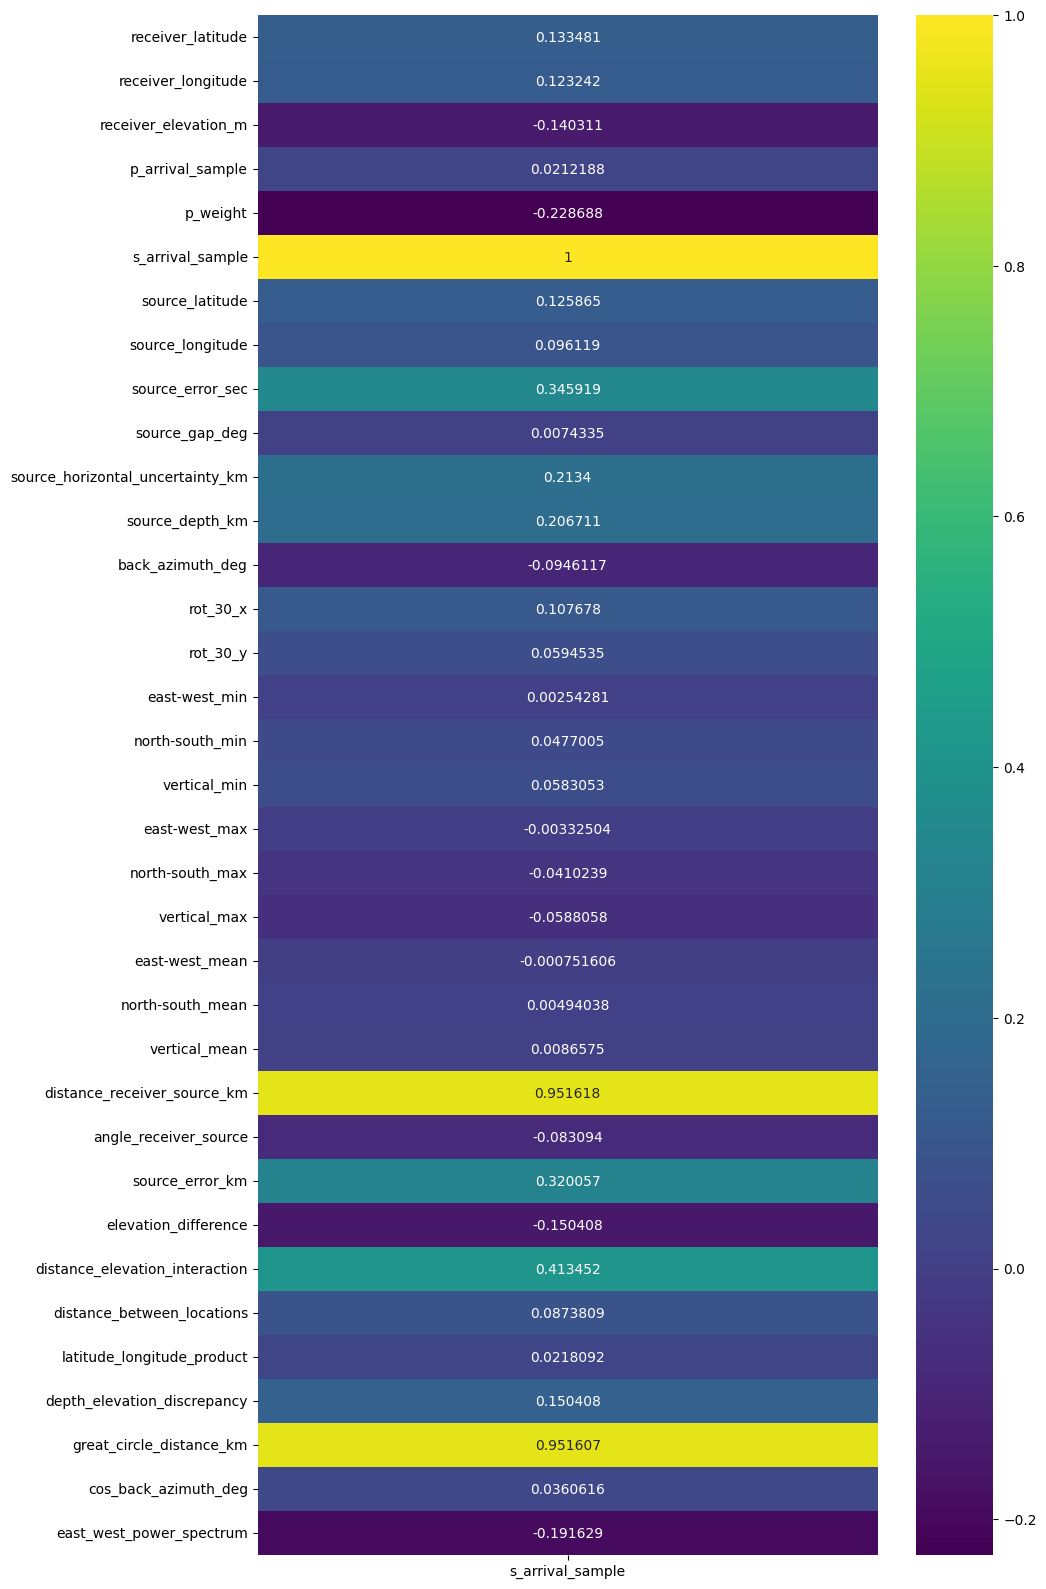

In [ ]:
data_korelasi = train_eng[train_float_col].corr()['s_arrival_sample']
data_korelasi = pd.DataFrame(data_korelasi)
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(data_korelasi, annot=True, fmt="g", cmap='viridis', ax=ax)

plt.show()

In [ ]:
data_korelasi

s_arrival_sample
receiver_latitude                         0.133481
receiver_longitude                        0.123242
receiver_elevation_m                     -0.140311
p_arrival_sample                          0.021219
p_weight                                 -0.228688
s_arrival_sample                          1.000000
source_latitude                           0.125865
source_longitude                          0.096119
source_error_sec                          0.345919
source_gap_deg                            0.007433
source_horizontal_uncertainty_km          0.213400
source_depth_km                           0.206711
back_azimuth_deg                         -0.094612
rot_30_x                                  0.107678
rot_30_y                                  0.059453
east-west_min                             0.002543
north-south_min                           0.047701
vertical_min                              0.058305
east-west_max                            -0.003325
north-south_max                          -0.041024
vertical_max                             -0.058806
east-west_mean                           -0.000752
north-south_mean                          0.004940
vertical_mean                             0.008657
distance_receiver_source_km               0.951618
angle_receiver_source                    -0.083094
source_error_km                           0.320057
elevation_difference                     -0.150408
distance_elevation_interaction            0.413452
distance_between_locations                0.087381
latitude_longitude_product                0.021809
depth_elevation_discrepancy               0.150408
great_circle_distance_km                  0.951607
cos_back_azimuth_deg                      0.036062
east_west_power_spectrum                 -0.191629

In [ ]:
test_float_col = list(test_eng.select_dtypes("float").columns)
test_cat_col = list(test_eng.select_dtypes("category").columns)
float_test_data = test_eng[test_float_col]
object_test_data = test_eng[test_cat_col]
display(float_test_data.describe())
print("\n")
display(object_test_data.describe())

receiver_latitude  receiver_longitude  receiver_elevation_m  \
count        1576.000000         1576.000000           1576.000000   
mean           33.757339         -116.762810           1302.193782   
std             0.889300            0.843519            217.872846   
min            33.495500         -120.515300            386.800000   
25%            33.557500         -116.602667           1271.000000   
50%            33.611570         -116.596005           1374.800000   
75%            33.611570         -116.456370           1392.000000   
max            48.460700         -116.456370           1467.000000   

       p_arrival_sample     p_weight  source_latitude  source_longitude  \
count       1576.000000  1576.000000      1576.000000       1576.000000   
mean         536.337563     0.545108        33.676442       -116.686576   
std           72.842262     0.247613         1.077398          1.046765   
min          366.000000     0.000000        31.282000       -121.237833   
25%          500.000000     0.420000        33.064000       -117.000393   
50%          500.000000     0.580000        33.514000       -116.442800   
75%          600.000000     0.660000        34.035050       -116.032457   
max          699.000000     1.000000        48.734167       -115.242000   

       source_error_sec  source_gap_deg  source_horizontal_uncertainty_km  \
count       1576.000000     1576.000000                       1576.000000   
mean           0.318832       76.847579                          0.777380   
std            0.141020      432.297490                          0.552643   
min            0.070000     -397.260982                          0.120000   
25%            0.263186       22.136781                          0.605515   
50%            0.315866       45.975139                          0.762071   
75%            0.345968       92.000000                          0.870949   
max            1.739800    12655.438857                          7.700000   

       ...  angle_receiver_source  source_error_km  elevation_difference  \
count  ...            1576.000000      1576.000000           1576.000000   
mean   ...               0.360299         0.307632           1293.836783   
std    ...               1.697400         0.514692            218.103102   
min    ...              -3.115245         0.009800            365.200000   
25%    ...              -0.945844         0.157054           1262.585000   
50%    ...              -0.376909         0.241705           1365.700000   
75%    ...               2.125341         0.300093           1386.872500   
max    ...               3.138950         6.545000           1467.040000   

       distance_elevation_interaction  distance_between_locations  \
count                     1576.000000                 1576.000000   
mean                    101995.290647                    0.760369   
std                      49012.276162                    0.338969   
min                       1947.181848                    0.028567   
25%                      67974.397879                    0.525287   
50%                     101809.145297                    0.746790   
75%                     131702.543896                    0.980629   
max                     424141.016594                    2.673829   

       latitude_longitude_product  depth_elevation_discrepancy  \
count                 1576.000000                  1576.000000   
mean                 -3942.129661                 -1293.836783   
std                    128.438832                   218.103102   
min                  -5821.084746                 -1467.040000   
25%                  -3917.413796                 -1386.872500   
50%                  -3914.281432                 -1365.700000   
75%                  -3910.489033                 -1262.585000   
max                  -3905.664632                  -365.200000   

       great_circle_distance_km  cos_back_azimuth_deg  \
count               1576.000000           1576.

network_code receiver_code receiver_type p_status   source_id  \
count          1576          1576          1576     1576        1576   
unique            2            10             3        3        1018   
top              PB          B084            EH   manual  ci14334988   
freq           1572           434          1309      831           5   

                       trace_name depth_category receiver_elevation_category  
count                        1576           1576                        1576  
unique                       1576              1                           2  
top     B075.PB_20170714014930_EV        shallow                      medium  
freq                            1           1576                        1494

#EDA

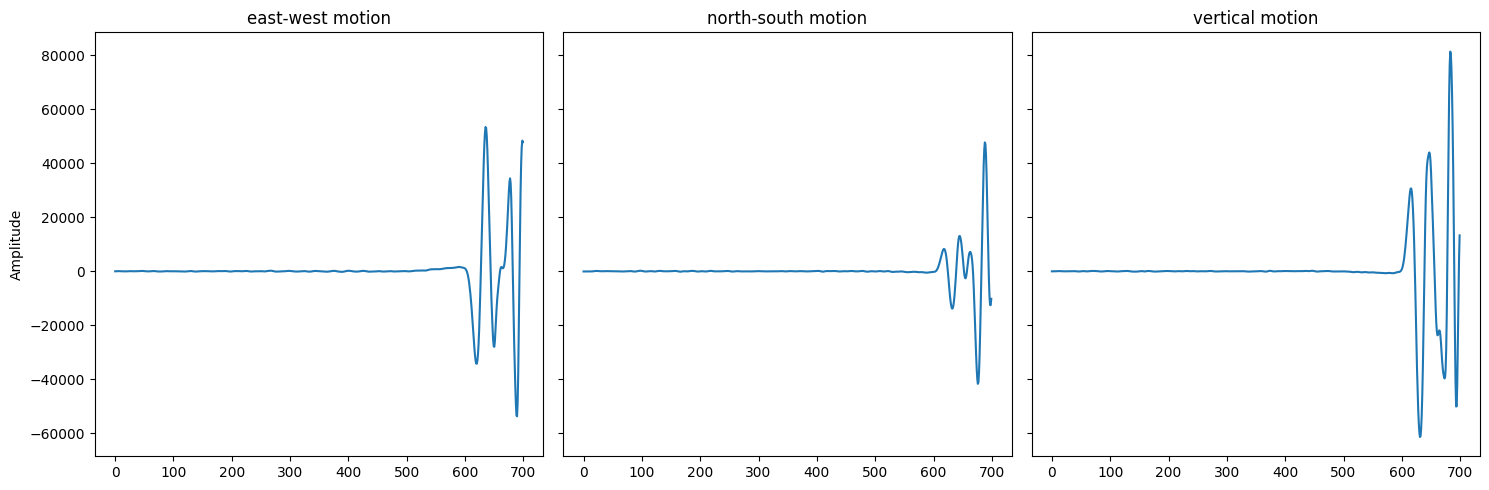

In [ ]:
sample_wv = wave_data[train_eng["trace_name"].values[0]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.lineplot(sample_wv["east-west"], ax=axes[0])
axes[0].set_title('east-west motion')

sns.lineplot(sample_wv["north-south"], ax=axes[1])
axes[1].set_title('north-south motion')

sns.lineplot(sample_wv["vertical"], ax=axes[2])
axes[2].set_title('vertical motion')

# Add a common y-axis label
axes[0].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

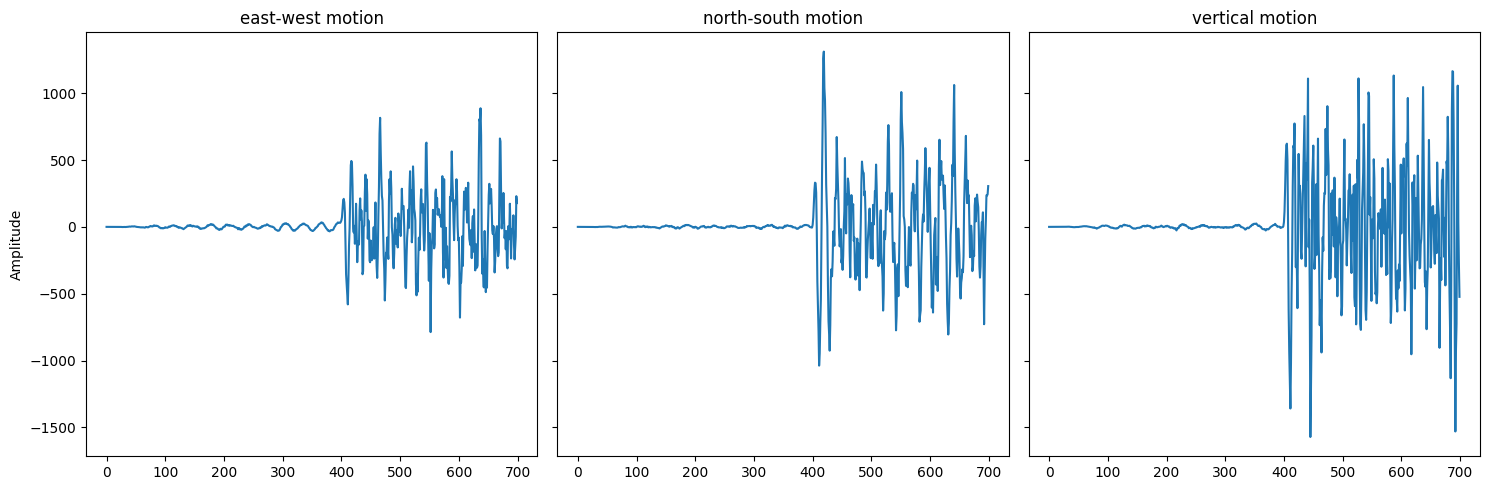

In [ ]:
sample_wv = wave_data[test_eng["trace_name"].values[0]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.lineplot(sample_wv["east-west"], ax=axes[0])
axes[0].set_title('east-west motion')

sns.lineplot(sample_wv["north-south"], ax=axes[1])
axes[1].set_title('north-south motion')

sns.lineplot(sample_wv["vertical"], ax=axes[2])
axes[2].set_title('vertical motion')

# Add a common y-axis label
axes[0].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

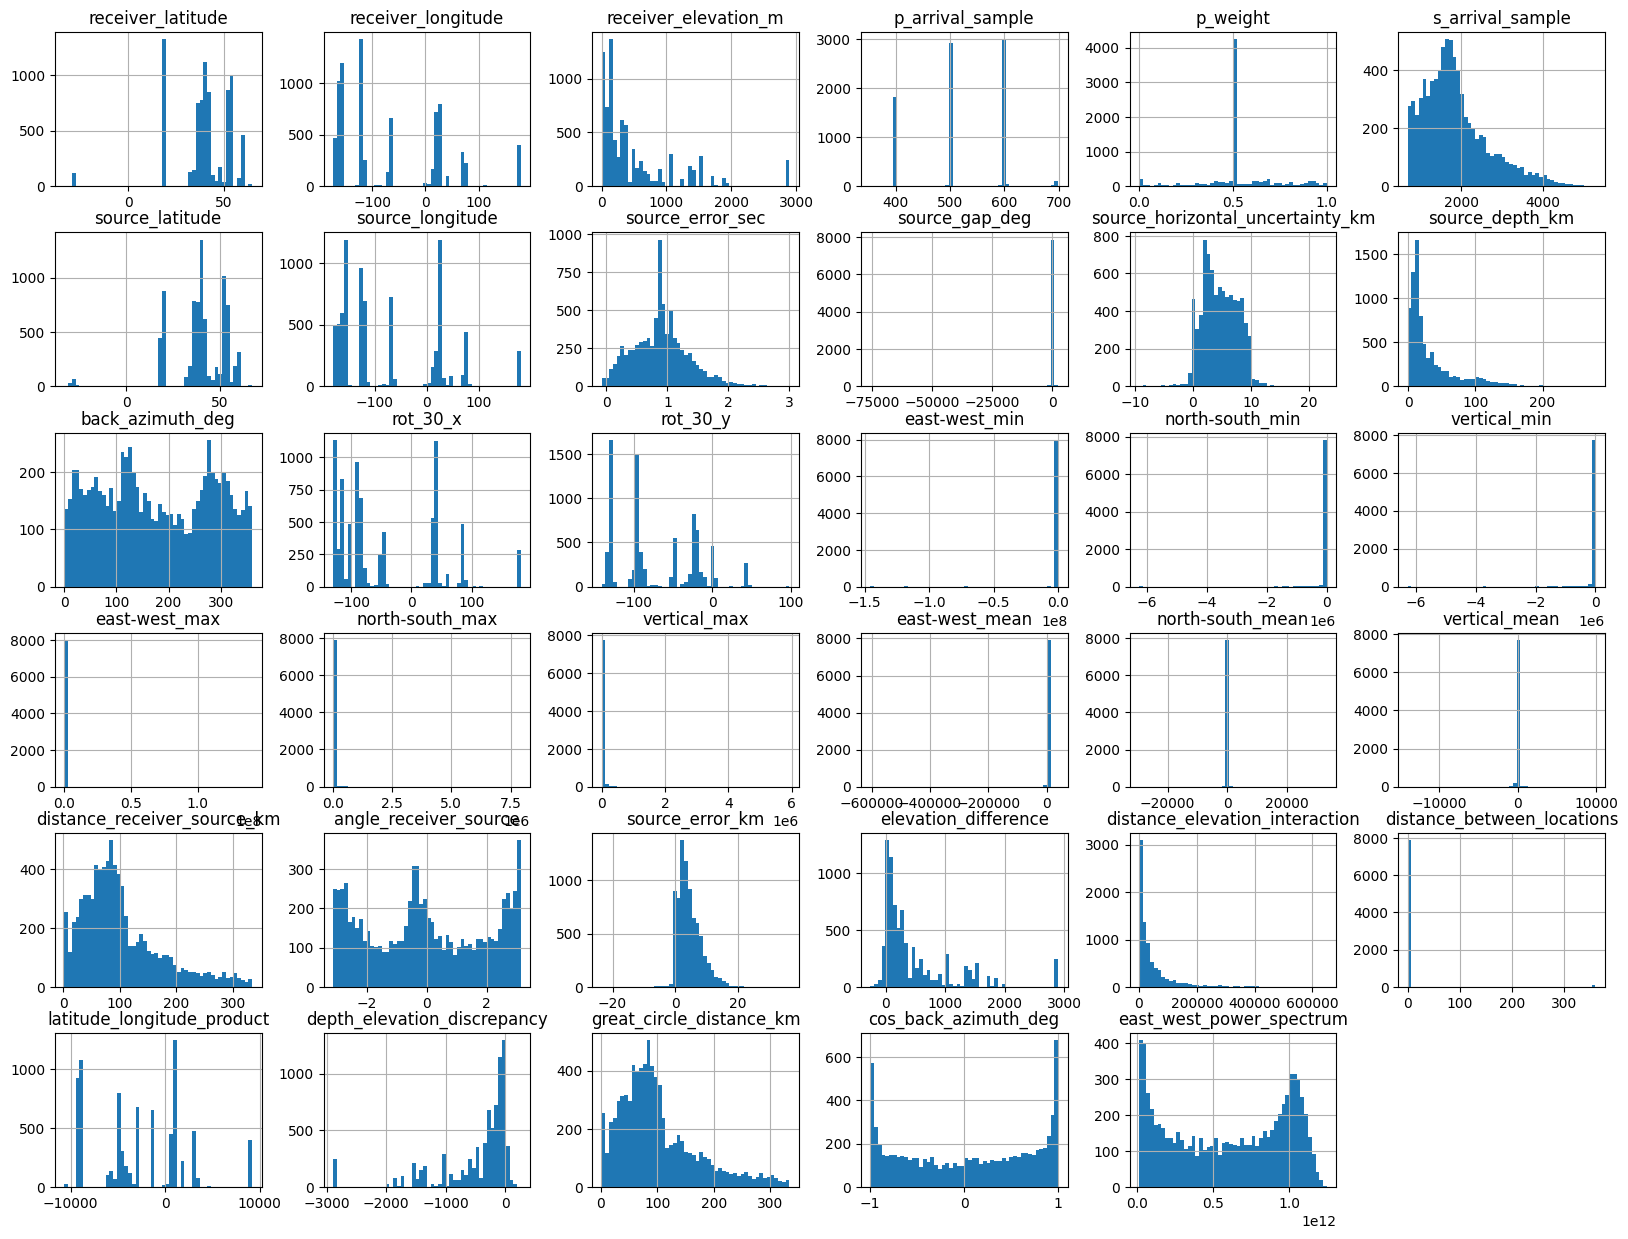

<Figure size 640x480 with 0 Axes>

In [ ]:
train_eng[train_float_col].hist(bins=50, figsize=(20,15))
plt.show()
plt.savefig('histogram' +'.png')

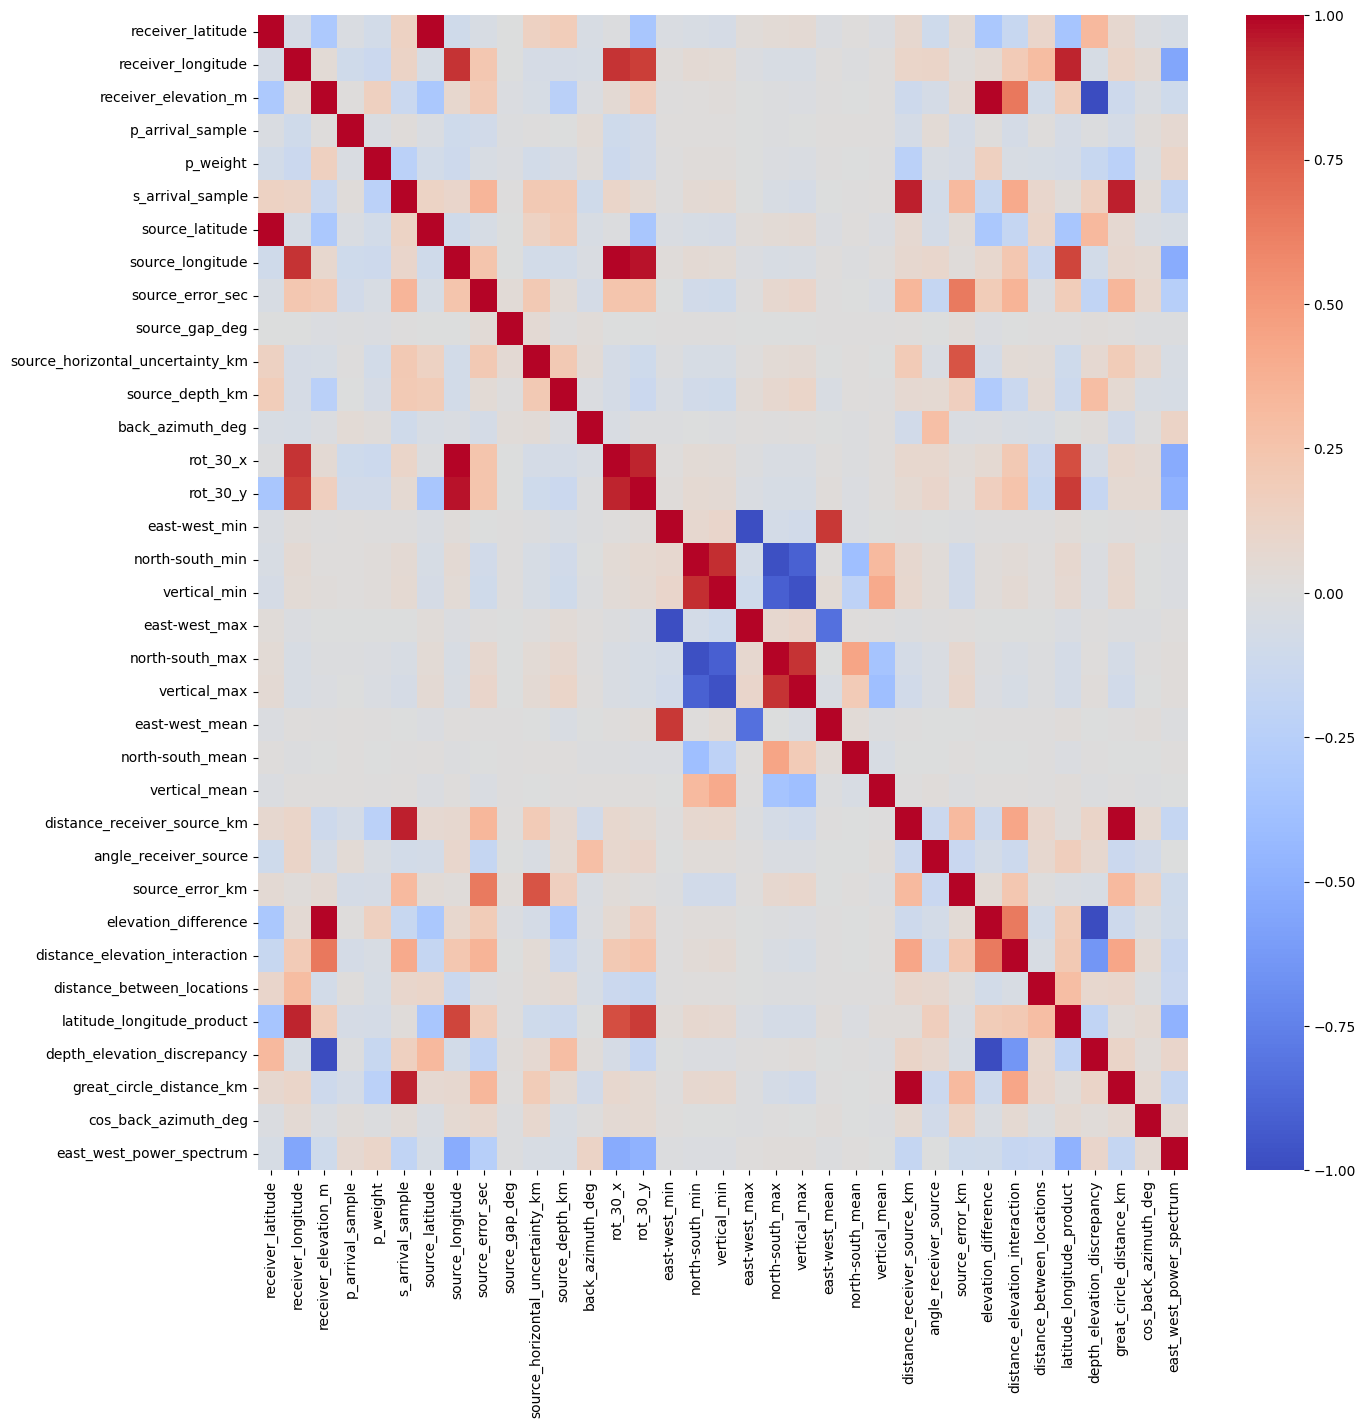

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
# Check the correlation between numerical columns

corr_matrix = train_eng[train_float_col].corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', ax=ax)
plt.show()
plt.savefig('co_rel' + '.png')

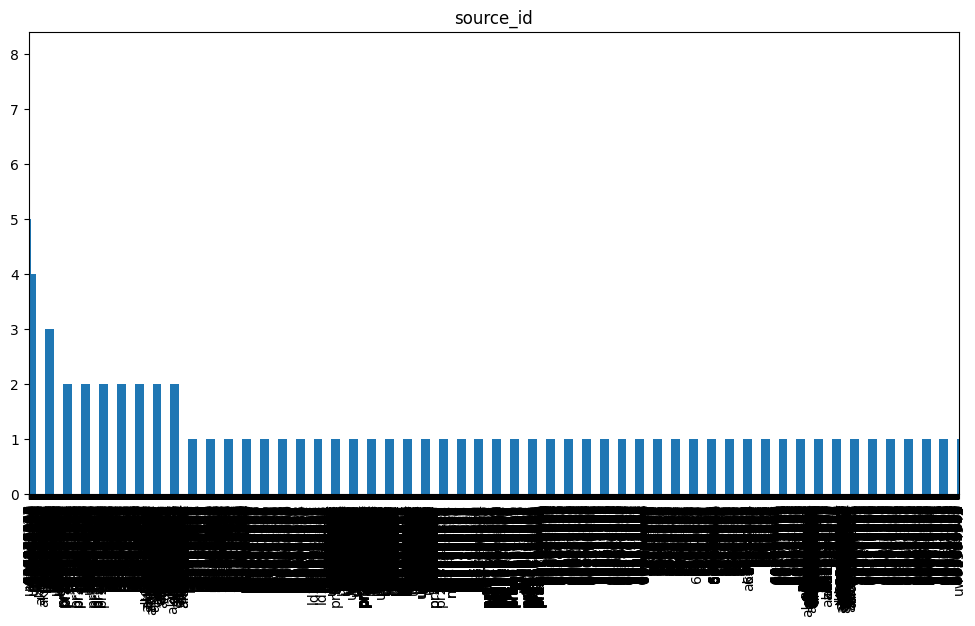

<Figure size 640x480 with 0 Axes>

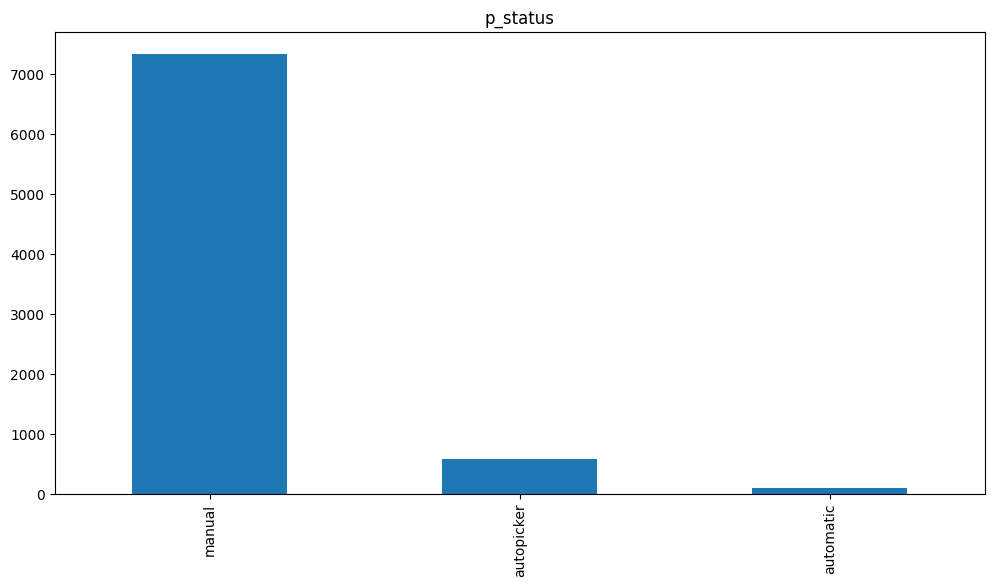

<Figure size 640x480 with 0 Axes>

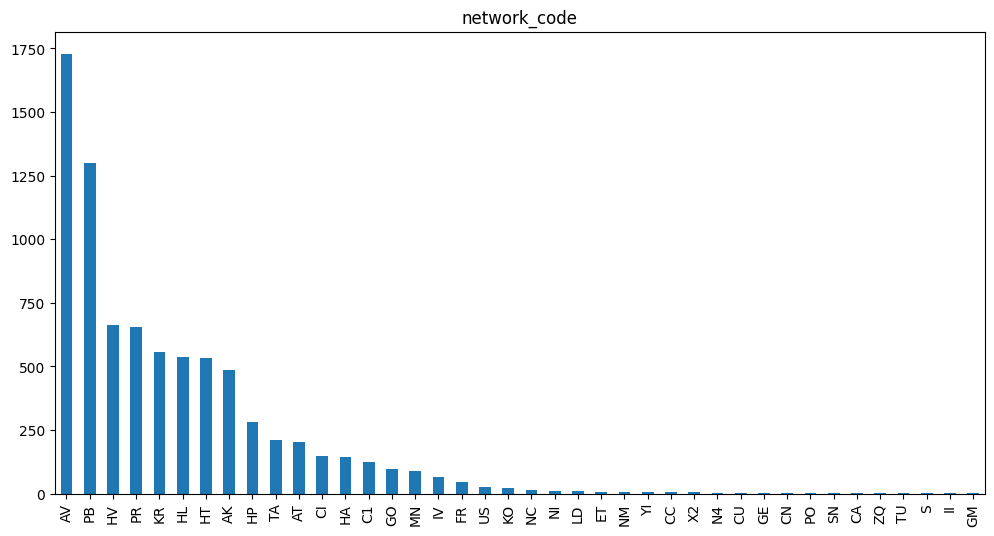

<Figure size 640x480 with 0 Axes>

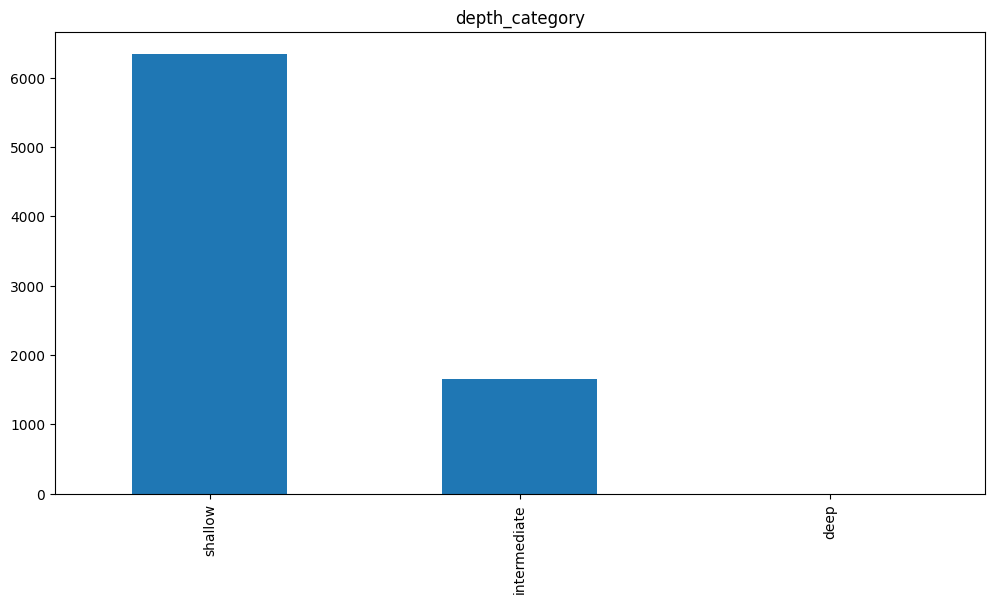

<Figure size 640x480 with 0 Axes>

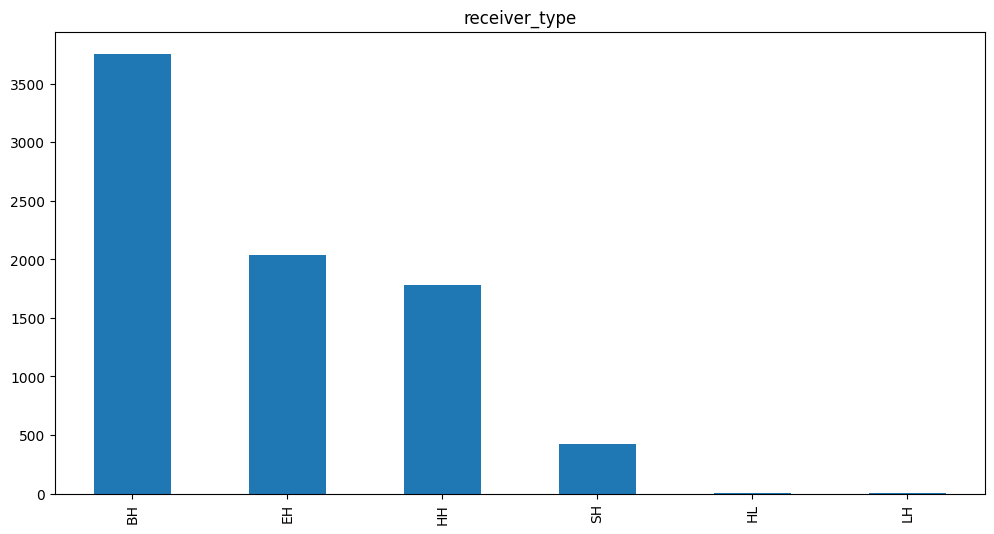

<Figure size 640x480 with 0 Axes>

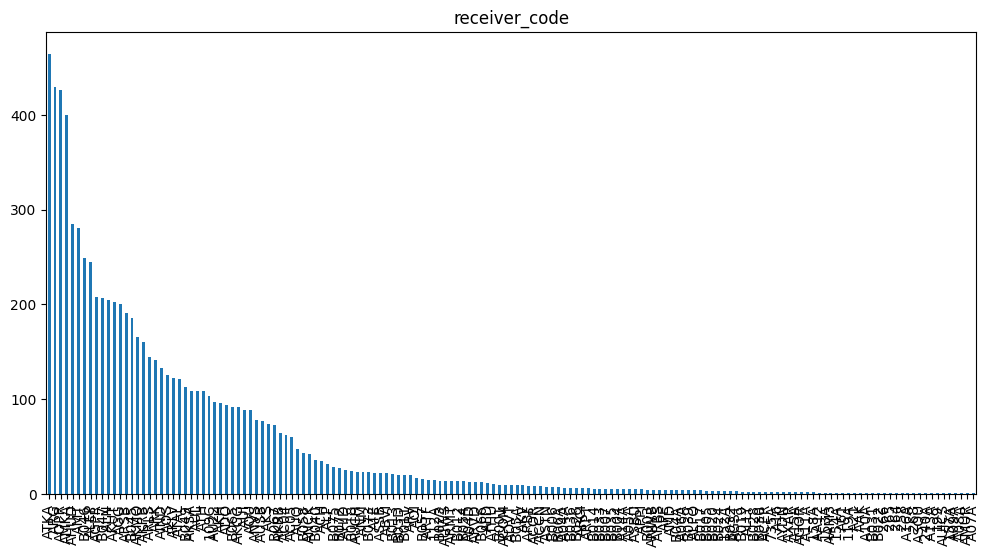

<Figure size 640x480 with 0 Axes>

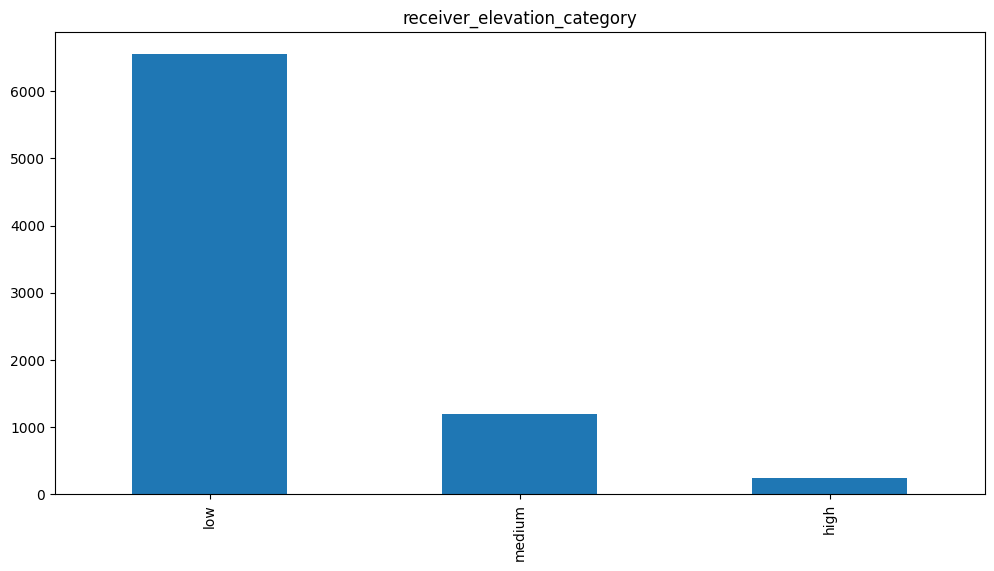

<Figure size 640x480 with 0 Axes>

In [ ]:
for col in (set(train_cat_col) - set(['trace_name'])) :
    plt.figure(figsize=(12,6))
    train_eng[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    plt.savefig(col + '.png')



# ordinal encoding


In [ ]:
obj_col_for_onehot = list(set(train_cat_col) - set(['source_id', 'receiver_code', 'trace_name']))
obj_col_for_onehot

['p_status',
 'network_code',
 'receiver_type',
 'depth_category',
 'receiver_elevation_category']

In [ ]:
ordinal_encoder = OrdinalEncoder()
train_eng_2 = train_eng.drop(['receiver_code', 'trace_name', 'source_id'], axis=1)
train_eng_2[obj_col_for_onehot] = ordinal_encoder.fit_transform(train_eng_2[obj_col_for_onehot])
train_eng_2

network_code  receiver_type  receiver_latitude  receiver_longitude  \
0             34.0            0.0            32.8889           -117.1051   
1             34.0            0.0            32.8889           -117.1051   
2             34.0            0.0            32.8889           -117.1051   
3             34.0            0.0            32.8889           -117.1051   
4             34.0            0.0            32.8889           -117.1051   
...            ...            ...                ...                 ...   
7995          29.0            1.0            35.9292           -120.5153   
7996          29.0            1.0            35.9292           -120.5153   
7997          29.0            1.0            35.9292           -120.5153   
7998          29.0            1.0            35.9292           -120.5153   
7999          29.0            1.0            35.9292           -120.5153   

      receiver_elevation_m  p_arrival_sample  p_status  p_weight  \
0                    150.0             600.0       2.0      0.50   
1                    150.0             500.0       2.0      0.50   
2                    150.0             600.0       2.0      0.50   
3                    150.0             500.0       2.0      0.50   
4                    150.0             400.0       2.0      0.50   
...                    ...               ...       ...       ...   
7995                 583.0             500.0       2.0      0.42   
7996                 583.0             500.0       2.0      0.58   
7997                 583.0             600.0       2.0      0.69   
7998                 583.0             600.0       2.0      0.68   
7999                 583.0             600.0       2.0      0.66   

      s_arrival_sample  source_latitude  ...  receiver_elevation_category  \
0               1763.0         32.70770  ...                          1.0   
1               1678.0         32.72530  ...                          1.0   
2               1777.0         32.71540  ...                          1.0   
3               1416.0         32.98980  ...                          1.0   
4               1642.0         32.65710  ...                          1.0   
...                ...              ...  ...                          ...   
7995            1553.0         36.57850  ...                          1.0   
7996            1669.0         36.61267  ...                          1.0   
7997            1364.0         36.36300  ...                          1.0   
7998            1355.0         36.35933  ...                          1.0   
7999            1124.0         36.22283  ...                          1.0   

      elevation_difference  distance_elevation_interaction  \
0                   140.80                    15201.571624   
1                   137.34                    15280.246634   
2                   137.40                    15316.771803   
3                   141.28                    11375.993640   
4                   141.23                    15999.528922   
...                    ...                             ...   
7995                573.70                    42046.044493   
7996                576.36                    47091.501977   
7997                572.13                    28613.423816   
7998                572.00                    28440.579438   
7999                575.14                    24156.838935   

      distance_between_locations  latitude_longitude_product  \
0                       1.075869                -3851.457923   
1                       1.082731                -3851.457923   
2                       1.084666                -3851.457923   
3                       0.808421                -3851.457923   
4                       1.128953                -3851.457923   
...                          ...                         ...   
7995                    0.650281                -4330.018317   
7996                    0.750227                -4330.018317   
7997                    0.4466

In [ ]:
#ordinal_encoder2 = OrdinalEncoder()
test_eng_2 = test_eng.drop(['receiver_code', 'trace_name', 'source_id'], axis=1)
test_eng_2[obj_col_for_onehot] = ordinal_encoder.transform(test_eng_2[obj_col_for_onehot])
test_eng_2

network_code  receiver_type  receiver_latitude  receiver_longitude  \
0             29.0            1.0            35.9292         -120.515300   
1             29.0            1.0            35.9292         -120.515300   
2             29.0            1.0            35.9292         -120.515300   
3             29.0            1.0            35.9292         -120.515300   
4             29.0            1.0            35.9292         -120.515300   
...            ...            ...                ...                 ...   
1571          29.0            1.0            33.4955         -116.602667   
1572          29.0            1.0            33.4955         -116.602667   
1573          29.0            1.0            33.4955         -116.602667   
1574          29.0            1.0            33.4955         -116.602667   
1575          29.0            1.0            33.4955         -116.602667   

      receiver_elevation_m  p_arrival_sample  p_status  p_weight  \
0                    583.0             400.0       2.0      0.64   
1                    583.0             500.0       2.0      0.48   
2                    583.0             500.0       2.0      0.72   
3                    583.0             500.0       2.0      0.44   
4                    583.0             400.0       2.0      0.59   
...                    ...               ...       ...       ...   
1571                1139.0             698.0       1.0      0.90   
1572                1139.0             600.0       2.0      0.56   
1573                1139.0             500.0       2.0      0.62   
1574                1139.0             500.0       2.0      0.57   
1575                1139.0             600.0       0.0      0.00   

      source_latitude  source_longitude  ...  receiver_elevation_category  \
0           36.008500       -120.982500  ...                          1.0   
1           35.730700       -121.082000  ...                          1.0   
2           35.711670       -121.050170  ...                          1.0   
3           35.950700       -119.752800  ...                          1.0   
4           36.363000       -120.402330  ...                          1.0   
...               ...               ...  ...                          ...   
1571        34.046000       -117.125000  ...                          2.0   
1572        32.996700       -116.398800  ...                          2.0   
1573        32.905333       -116.231667  ...                          2.0   
1574        32.996500       -116.401000  ...                          2.0   
1575        34.216000       -117.507000  ...                          2.0   

      elevation_difference  distance_elevation_interaction  \
0                   571.55                    25098.032444   
1                   576.50                    32496.959185   
2                   577.33                    31497.160433   
3                   561.30                    40135.506894   
4                   572.60                    28681.956552   
...                    ...                             ...   
1571               1129.10                    88735.577482   
1572               1129.90                    66623.272900   
1573               1132.88                    84323.520756   
1574               1130.00                    66571.719946   
1575               1135.00                   131800.495217   

      distance_between_locations  latitude_longitude_product  \
0                       0.473882                -4330.018317   
1                       0.600459                -4330.018317   
2                       0.577413                -4330.018317   
3                       0.762803                -4330.018317   
4                       0.448269                -4330.018317   
...                          ...                         ...   
1571                    0.758869                -3905.664632   
1572                    0.538854                -3905.664632   
1573                    0.6970

In [ ]:
train_eng_2.isna().sum()

network_code                        0
receiver_type                       0
receiver_latitude                   0
receiver_longitude                  0
receiver_elevation_m                0
p_arrival_sample                    0
p_status                            0
p_weight                            0
s_arrival_sample                    0
source_latitude                     0
source_longitude                    0
source_error_sec                    0
source_gap_deg                      0
source_horizontal_uncertainty_km    0
source_depth_km                     0
back_azimuth_deg                    0
rot_30_x                            0
rot_30_y                            0
east-west_min                       0
north-south_min                     0
vertical_min                        0
east-west_max                       0
north-south_max                     0
vertical_max                        0
east-west_mean                      0
north-south_mean                    0
vertical_mea

# Training

In [ ]:
models = {
    #'linear_regression': linear_model.LinearRegression(),
    #'Huber_regression' : linear_model.HuberRegressor(),
    #'lasso': linear_model.LassoCV(verbose = 0),
    #'ridge': linear_model.RidgeCV(),
    #'svr': svm.SVR(),
    'randomforest': ensemble.RandomForestRegressor(random_state = SEED),
    'gradientboosting': ensemble.GradientBoostingRegressor(random_state = SEED),
    'xgboost': xgb.XGBRegressor(random_state = SEED, enable_categorical = True),
    'catboost': cb.CatBoostRegressor(verbose=0,
                                     random_state = SEED,
                                     #cat_features = train_cat_col
                                     ),
    'lightgbm': lgbm.LGBMRegressor(random_state = SEED),
    'MLPRegression' : MLPRegressor(random_state = SEED),
    'AdaBoostReg' : ensemble.AdaBoostRegressor(random_state = SEED),
    'ExtraTreesReg' : ensemble.ExtraTreesRegressor(random_state = SEED)
}

In [ ]:
def model_comparison(X_train, X_val, y_train, y_val, models):
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        score = mse(y_val, predictions, squared=False)
        print(f'{name}: {score}')

In [ ]:
X = train_eng_2.drop(['s_arrival_sample'], axis = 1)
y = train_eng_2.s_arrival_sample
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = SEED)
model_comparison(X_train, X_val, y_train, y_val, models)

randomforest: 136.6989107150206
gradientboosting: 137.56681879389575
xgboost: 128.50757001716792
catboost: 121.00438682278705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7820
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 40
[LightGBM] [Info] Start training from score 1867.782224
lightgbm: 125.28744337285542
MLPRegression: 360108.0250555113
AdaBoostReg: 231.38413201178153
ExtraTreesReg: 133.35406816838497


In [ ]:
skewed_features = X.select_dtypes(['int64','float64']).skew().sort_values(ascending=False)
skewness = pd.Series(skewed_features)
skewness = skewness[skewness > 0.75]
print("There are {} skewed numerical features to Log transform".format(skewness.shape[0]))

There are 13 skewed numerical features to Log transform


In [ ]:
skewed_cols = list(skewed_features.index)
len(skewed_cols)

30

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_score(X,y):

    mi_score = mutual_info_regression(X, y, random_state=SEED)
    mi_score = pd.Series(mi_score, index = X.columns, name = 'MI Scores').sort_values(ascending=False)

    return mi_score

mi_scores = np.round(make_mi_score(X,y),4)
display(mi_scores)

distance_receiver_source_km         1.3273
great_circle_distance_km            1.3203
distance_between_locations          1.0986
source_longitude                    0.5158
rot_30_y                            0.5147
rot_30_x                            0.4688
source_latitude                     0.4400
receiver_latitude                   0.3794
latitude_longitude_product          0.3773
receiver_longitude                  0.3520
network_code                        0.3392
distance_elevation_interaction      0.3097
receiver_elevation_m                0.3082
elevation_difference                0.2988
depth_elevation_discrepancy         0.2987
p_weight                            0.2067
source_depth_km                     0.1999
cluster_label                       0.1990
receiver_type                       0.1933
source_error_sec                    0.1760
east_west_power_spectrum            0.1386
angle_receiver_source               0.1242
back_azimuth_deg                    0.1130
source_erro

In [ ]:
mi_scores_df = pd.DataFrame(mi_scores)
mi_score_cols = list(mi_scores_df[mi_scores_df['MI Scores'] > 0.5].index)
mi_score_cols

['distance_receiver_source_km',
 'great_circle_distance_km',
 'distance_between_locations',
 'source_longitude',
 'rot_30_y']

##standard scaler & PCA


In [ ]:
from sklearn.preprocessing import StandardScaler, Normalizer
scaler = StandardScaler()

X_train_std = X_train.copy()
X_train_std[skewed_cols] = Normalizer().fit_transform(X_train[skewed_cols])
X_validation_std = X_val.copy()
X_validation_std[skewed_cols] = Normalizer().transform(X_val[skewed_cols])

model = cb.CatBoostRegressor(verbose=0, random_state = SEED)
model.fit(X_train_std, y_train, eval_set = [(X_validation_std, y_val)])
predictions = model.predict(X_validation_std)
score = mse(y_val, predictions, squared=False)
score


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but Normalizer was fitted without feature names



146.31092758564432

In [ ]:
X_train

network_code  receiver_type  receiver_latitude  receiver_longitude  \
3836          31.0            0.0          18.346645          -66.753975   
6408          32.0            2.0         -33.204700          138.609800   
4840          15.0            5.0          36.213560           28.121220   
527           17.0            2.0          39.021100           22.336000   
6105           0.0            0.0          52.201600         -174.197500   
...            ...            ...                ...                 ...   
5226          22.0            0.0          41.323330           72.981110   
5390          10.0            2.0          43.588200            5.806700   
860           31.0            0.0          18.467493          -67.111184   
7603          29.0            1.0          40.237500         -123.819700   
7270          29.0            1.0          40.321970         -124.284300   

      receiver_elevation_m  p_arrival_sample  p_status  p_weight  \
3836                 355.1             400.0       2.0      0.50   
6408                 464.0             500.0       2.0      0.50   
4840                 148.0             600.0       2.0      0.50   
527                  625.0             500.0       2.0      0.50   
6105                  55.0             500.0       2.0      0.25   
...                    ...               ...       ...       ...   
5226                1378.0             400.0       2.0      0.50   
5390                 510.0             500.0       2.0      0.50   
860                  119.9             600.0       2.0      0.40   
7603                 117.0             400.0       2.0      0.67   
7270                  44.0             500.0       2.0      0.69   

      source_latitude  source_longitude  ...  receiver_elevation_category  \
3836          19.0705         -66.72260  ...                          1.0   
6408         -33.3134         138.53300  ...                          1.0   
4840          35.4911          27.30400  ...                          1.0   
527           38.6747          21.68050  ...                          1.0   
6105          51.7523        -173.12470  ...                          1.0   
...               ...               ...  ...                          ...   
5226          41.5893          71.59570  ...                          2.0   
5390          44.5060           6.76220  ...                          1.0   
860           19.0933         -67.70150  ...                          1.0   
7603          40.4995        -124.24883  ...                          1.0   
7270          40.2940        -124.47700  ...                          1.0   

      elevation_difference  distance_elevation_interaction  \
3836                336.95                    28475.760783   
6408                450.06                     6505.162414   
4840                114.68                    16128.020014   
527                 612.27                    42924.816511   
6105                 17.93                     4898.691191   
...                    ...                             ...   
5226               1371.68                   164618.959009   
5390                492.41                    65038.992614   
860                  94.90                    11165.330312   
7603                 91.44                     5456.260879   
7270                 24.55                      733.614148   

      distance_between_locations  latitude_longitude_product  \
3836                    0.724535                -1224.711482   
6408                    0.133094                -4602.496826   
4840                    1.090778                 1018.369488   
527                     0.741399                  871.575290   
6105                    1.163087                -9093.388216   
...                          ...                         ...   
5226                    1.410709                 3015.822492   
5390                    1.324891                  253.103601   
860                     0.8602

In [ ]:
pd.DataFrame(X_train_std)

network_code  receiver_type  receiver_latitude  receiver_longitude  \
3836      1.325329      -0.777250          -1.454946           -0.001315   
6408      1.413101       0.833909          -4.974122            2.043170   
4840     -0.079024       3.250649          -0.235253            0.943208   
527       0.096520       0.833909          -0.043595            0.885614   
6105     -1.395605      -0.777250           0.856178           -1.070962   
...            ...            ...                ...                 ...   
5226      0.535380      -0.777250           0.113568            1.389808   
5390     -0.517885       0.833909           0.268181            0.721058   
860       1.325329      -0.777250          -1.446696           -0.004871   
7603      1.149785       0.028330           0.039444           -0.569429   
7270      1.149785       0.028330           0.045210           -0.574054   

      receiver_elevation_m  p_arrival_sample  p_status  p_weight  \
3836             -0.243333         -1.487740  0.282983 -0.116134   
6408             -0.068904         -0.232693  0.282983 -0.116134   
4840             -0.575051          1.022355  0.282983 -0.116134   
527               0.188975         -0.232693  0.282983 -0.116134   
6105             -0.724013         -0.232693  0.282983 -1.431952   
...                    ...               ...       ...       ...   
5226              1.395079         -1.487740  0.282983 -0.116134   
5390              0.004776         -0.232693  0.282983 -0.116134   
860              -0.620060          1.022355  0.282983 -0.642461   
7603             -0.624705         -1.487740  0.282983  0.778622   
7270             -0.741632         -0.232693  0.282983  0.883888   

      source_latitude  source_longitude  ...  receiver_elevation_category  \
3836        -1.409823          0.054289  ...                    -0.296375   
6408        -5.015334          2.180547  ...                    -0.296375   
4840        -0.279615          1.028318  ...                    -0.296375   
527         -0.060493          0.970063  ...                    -0.296375   
6105         0.839621         -1.047938  ...                    -0.296375   
...               ...               ...  ...                          ...   
5226         0.140115          1.487139  ...                     2.169993   
5390         0.340868          0.815524  ...                    -0.296375   
860         -1.408253          0.044149  ...                    -0.296375   
7603         0.065106         -0.541629  ...                    -0.296375   
7270         0.050962         -0.543993  ...                    -0.296375   

      elevation_difference  distance_elevation_interaction  \
3836             -0.216510                       -0.257891   
6408             -0.038129                       -0.559124   
4840             -0.567043                       -0.427188   
527               0.217686                       -0.059784   
6105             -0.719624                       -0.581150   
...                    ...                             ...   
5226              1.415321                        1.608731   
5390              0.028660                        0.243417   
860              -0.598238                       -0.495230   
7603             -0.603694                       -0.573505   
7270             -0.709184                       -0.638256   

      distance_between_locations  latitude_longitude_product  \
3836                   -0.131328                    0.304111   
6408                   -0.145107                   -0.380783   
4840                   -0.122796                    0.758928   
527                    -0.130935                    0.729164   
6105                   -0.121111                   -1.291376   
...                          ...                         ...   
5226                   -0.115342                    1.163941   
5390                   -0.117341                    0.603760   
860                    -0.1281

In [ ]:
from sklearn.decomposition import PCA
train_scaled = scaler.fit_transform(train_eng_2.drop('source_id', axis = 1))
pca_train = train_scaled
pca = PCA(n_components=2).fit_transform(pca_train)
pca

array([[ 1.22689262, -1.27046019],
       [ 1.06967788, -1.58227033],
       [ 1.10918462, -1.6495508 ],
       ...,
       [ 1.0081183 , -3.89000747],
       [ 0.97591555, -3.99398993],
       [ 1.09140582, -4.6128627 ]])

In [ ]:
pca1 = train_eng_2.copy()
pca1[['pca 1', 'pca 2']] = pd.DataFrame(pca)[[0, 1]]
pca1

network_code  receiver_type  receiver_latitude  receiver_longitude  \
0             34.0            0.0            32.8889           -117.1051   
1             34.0            0.0            32.8889           -117.1051   
2             34.0            0.0            32.8889           -117.1051   
3             34.0            0.0            32.8889           -117.1051   
4             34.0            0.0            32.8889           -117.1051   
...            ...            ...                ...                 ...   
7995          29.0            1.0            35.9292           -120.5153   
7996          29.0            1.0            35.9292           -120.5153   
7997          29.0            1.0            35.9292           -120.5153   
7998          29.0            1.0            35.9292           -120.5153   
7999          29.0            1.0            35.9292           -120.5153   

      receiver_elevation_m  p_arrival_sample  p_status  p_weight  \
0                    150.0             600.0       2.0      0.50   
1                    150.0             500.0       2.0      0.50   
2                    150.0             600.0       2.0      0.50   
3                    150.0             500.0       2.0      0.50   
4                    150.0             400.0       2.0      0.50   
...                    ...               ...       ...       ...   
7995                 583.0             500.0       2.0      0.42   
7996                 583.0             500.0       2.0      0.58   
7997                 583.0             600.0       2.0      0.69   
7998                 583.0             600.0       2.0      0.68   
7999                 583.0             600.0       2.0      0.66   

      s_arrival_sample  source_latitude  ...  distance_elevation_interaction  \
0               1763.0         32.70770  ...                    15201.571624   
1               1678.0         32.72530  ...                    15280.246634   
2               1777.0         32.71540  ...                    15316.771803   
3               1416.0         32.98980  ...                    11375.993640   
4               1642.0         32.65710  ...                    15999.528922   
...                ...              ...  ...                             ...   
7995            1553.0         36.57850  ...                    42046.044493   
7996            1669.0         36.61267  ...                    47091.501977   
7997            1364.0         36.36300  ...                    28613.423816   
7998            1355.0         36.35933  ...                    28440.579438   
7999            1124.0         36.22283  ...                    24156.838935   

      distance_between_locations  latitude_longitude_product  \
0                       1.075869                -3851.457923   
1                       1.082731                -3851.457923   
2                       1.084666                -3851.457923   
3                       0.808421                -3851.457923   
4                       1.128953                -3851.457923   
...                          ...                         ...   
7995                    0.650281                -4330.018317   
7996                    0.750227                -4330.018317   
7997                    0.446675                -4330.018317   
7998                    0.444505                -4330.018317   
7999                    0.408642                -4330.018317   

      depth_elevation_discrepancy  cluster_label  great_circle_distance_km  \
0                         -140.80              0                101.149917   
1                         -137.34              0                101.669677   
2                         -137.40              0                101.914573   
3                         -141.28              0                 75.687926   
4                         -141.23              0                106.469147   
...                           ...            ...                       ...   


In [ ]:
X_pca = pca1.drop('s_arrival_sample', axis = 1)
y_pca = pca1.s_arrival_sample
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_pca, y_pca, random_state = SEED)

model = cb.CatBoostRegressor(verbose=0, random_state = SEED)
model.fit(X_train_pca, y_train_pca)
predictions = model.predict(X_val_pca)
score = mse(y_val_pca, predictions, squared=False)
score

121.08841529586715

# feature selection

In [ ]:
model = cb.CatBoostRegressor(verbose=0, random_state = SEED
                             )
model.fit(X_train, y_train, eval_set = [(X_val, y_val)])
predictions = model.predict(X_val)
score = mse(y_val, predictions, squared=False)
score

120.2928434375776

In [ ]:
model = cb.CatBoostRegressor(verbose=0, random_state = SEED
                             )
model.fit(X_train[mi_score_cols], y_train, eval_set = [(X_val[mi_score_cols], y_val)])
predictions = model.predict(X_val[mi_score_cols])
score = mse(y_val, predictions, squared=False)
score

168.73636211124173

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 3836 to 7270
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   network_code                      6000 non-null   float64
 1   receiver_type                     6000 non-null   float64
 2   receiver_latitude                 6000 non-null   float64
 3   receiver_longitude                6000 non-null   float64
 4   receiver_elevation_m              6000 non-null   float64
 5   p_arrival_sample                  6000 non-null   float64
 6   p_status                          6000 non-null   float64
 7   p_weight                          6000 non-null   float64
 8   source_latitude                   6000 non-null   float64
 9   source_longitude                  6000 non-null   float64
 10  source_error_sec                  6000 non-null   float64
 11  source_gap_deg                    6000 non-null   float64
 12  sou

In [ ]:
rfe_dict = model.select_features(X = X_train,
                                 y = y_train,
                                  eval_set = (X_val,y_val), # Walkforward validation set we have created earlier
                                  features_for_select = '0-39', # Features that will be selected on the RFE
                                  num_features_to_select = 22, # Number of features to keep from the selected
                                  steps = 12, # Number of model iterations performed in the RFE
                                  verbose = 50, #
                                  algorithm = EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                     train_final_model = False, # Train final model after RFE is finished
                                     plot = True # plot the ??? after the RFE is finished
                                     )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067463
Step #1 out of 12
0:	learn: 747.2852823	test: 717.9173534	best: 717.9173534 (0)	total: 39.1ms	remaining: 39s
50:	learn: 152.2600035	test: 160.9948894	best: 160.9948894 (50)	total: 1.68s	remaining: 31.3s
100:	learn: 123.6447763	test: 138.3105672	best: 138.3105672 (100)	total: 3.11s	remaining: 27.7s
150:	learn: 111.6474550	test: 131.7779426	best: 131.7779426 (150)	total: 4.3s	remaining: 24.2s
200:	learn: 103.2470198	test: 128.6706839	best: 128.6706839 (200)	total: 5.7s	remaining: 22.7s
250:	learn: 95.8924101	test: 125.8976465	best: 125.8785899 (249)	total: 6.87s	remaining: 20.5s
300:	learn: 90.1697627	test: 124.1484676	best: 124.1484676 (300)	total: 7.98s	remaining: 18.5s
350:	learn: 85.3402370	test: 123.4506247	best: 123.4506247 (350)	total: 9.01s	remaining: 16.7s
400:	learn: 81.4696363	test: 122.8133621	best: 122.8133621 (400)	total: 10.1s	remaining: 15.1s
450:	learn: 77.8278601	test: 122.2479013	best: 122.2479013 (450)	total: 12.6s	remaining: 15.3s
500:	l

In [ ]:
rfe_dict

{'selected_features': [1,
  2,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  13,
  15,
  16,
  17,
  22,
  26,
  28,
  29,
  31,
  32,
  33,
  34,
  37],
 'eliminated_features_names': ['vertical_mean',
  'back_azimuth_deg',
  'north-south_mean',
  'north-south_max',
  'source_horizontal_uncertainty_km',
  'east-west_mean',
  'east-west_max',
  'depth_elevation_discrepancy',
  'cluster_label',
  'p_status',
  'cos_back_azimuth_deg',
  'north-south_min',
  'receiver_elevation_category',
  'receiver_elevation_m',
  'vertical_min',
  'network_code',
  'angle_receiver_source',
  'east_west_power_spectrum'],
 'loss_graph': {'main_indices': [0, 2, 4, 6, 7, 9, 10, 12, 13, 14, 16, 17],
  'removed_features_count': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18],
  'loss_values': [120.29284353180488,
   121.7208444256909,
   122.35263676975468,
   121.54599571055019,
   120.88715962291255,
   120.89186020579791,
   120.928971955310

In [ ]:
rfe_dict['selected_features_names'].append('north-south_min')
rfe_dict['selected_features_names'].append('receiver_elevation_category')

In [ ]:
rfe_dict

{'selected_features': [0,
  1,
  2,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  13,
  15,
  16,
  19,
  22,
  26,
  28,
  31,
  32],
 'eliminated_features_names': ['back_azimuth_deg',
  'vertical_mean',
  'east-west_max',
  'east-west_mean',
  'source_horizontal_uncertainty_km',
  'north-south_max',
  'receiver_elevation_m',
  'north-south_mean',
  'north-south_min',
  'p_status',
  'east-west_min',
  'receiver_elevation_category',
  'source_error_km',
  'angle_receiver_source'],
 'loss_graph': {'main_indices': [0, 2, 3, 5, 7, 8, 9, 11, 12, 13],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  'loss_values': [121.30811990190983,
   120.98417287461595,
   120.8008225922974,
   120.11718967518094,
   121.16035621285464,
   121.53277580489588,
   121.41153007133816,
   121.39092463343408,
   121.39449959870625,
   119.52530131819269,
   119.56794077658716,
   120.22655704883559,
   119.56819890623946,
   118.54852638196415,
   118.83382717311524]},
 'eliminated

In [ ]:
X_train2 = X_train[rfe_dict['selected_features_names']]
X_val2 = X_val[rfe_dict['selected_features_names']]
#X_train2 = X_train.drop('source_horizontal_uncertainty_km', axis = 1)
#X_val2 = X_val.drop('source_horizontal_uncertainty_km', axis = 1)
X_train2

network_code  receiver_type  receiver_latitude  receiver_longitude  \
3836          31.0            0.0          18.346645          -66.753975   
6408          32.0            2.0         -33.204700          138.609800   
4840          15.0            5.0          36.213560           28.121220   
527           17.0            2.0          39.021100           22.336000   
6105           0.0            0.0          52.201600         -174.197500   
...            ...            ...                ...                 ...   
5226          22.0            0.0          41.323330           72.981110   
5390          10.0            2.0          43.588200            5.806700   
860           31.0            0.0          18.467493          -67.111184   
7603          29.0            1.0          40.237500         -123.819700   
7270          29.0            1.0          40.321970         -124.284300   

      p_arrival_sample  p_weight  source_latitude  source_longitude  \
3836             400.0      0.50          19.0705         -66.72260   
6408             500.0      0.50         -33.3134         138.53300   
4840             600.0      0.50          35.4911          27.30400   
527              500.0      0.50          38.6747          21.68050   
6105             500.0      0.25          51.7523        -173.12470   
...                ...       ...              ...               ...   
5226             400.0      0.50          41.5893          71.59570   
5390             500.0      0.50          44.5060           6.76220   
860              600.0      0.40          19.0933         -67.70150   
7603             400.0      0.67          40.4995        -124.24883   
7270             500.0      0.69          40.2940        -124.47700   

      source_error_sec  source_gap_deg  ...    rot_30_x    rot_30_y  \
3836          0.972500       81.856000  ...  -48.248217  -49.876837   
6408          2.269900      106.106000  ...  103.316397   98.116751   
4840          1.162000       37.888000  ...   41.391508  -17.084194   
527           0.634400       95.778000  ...   38.113214  -22.653023   
6105          0.360000      209.000000  ... -124.054238 -131.381157   
...                ...             ...  ...         ...         ...   
5226          0.724500      159.236000  ...   82.798345   -0.219540   
5390          0.989100       60.724000  ...   28.109237  -35.162227   
860           0.943298      385.407164  ...  -49.084569  -50.386033   
7603          0.269974      161.093033  ...  -87.352893  -97.198011   
7270          0.508238      308.490679  ...  -87.653244  -97.134128   

       vertical_min   vertical_max  distance_receiver_source_km  \
3836   -6426.624512    8712.223633                    80.190822   
6408 -115259.421875  127594.375000                    14.019747   
4840   -2521.675049    3819.910889                   108.973108   
527     -398.220337     515.195679                    68.679706   
6105    -795.460022     520.177246                    89.067113   
...             ...            ...                          ...   
5226   -1233.500977    1218.830811                   119.462234   
5390  -20081.658203   20230.097656                   127.527436   
860     -388.768127     327.961761                    93.122021   
7603    -302.287231     220.965836                    46.634708   
7270   -1738.420410    2714.353271                    16.673049   

      depth_category  elevation_difference  distance_elevation_interaction  \
3836             1.0                336.95                    28475.760783   
6408             1.0                450.06                     6505.162414   
4840             1.0                114.68                    16128.020014   
527              1.0                612.27                    42924.816511   
6105             1.0                 17.93                     4898.691191   
...              ...                   ...                             ...   
5226             1.0               1

In [ ]:
model.fit(X_train2, y_train, eval_set = [(X_val2, y_val)])
predictions = model.predict(X_val2)
score = mse(y_val, predictions, squared=False)
score

119.20080817212745

# Hyperparameter tuning

In [ ]:
model = cb.CatBoostRegressor(verbose=0, random_state = SEED)
model.fit(X_train2, y_train, eval_set = [(X_val2, y_val)])
predictions = model.predict(X_val2)
score = mse(y_val, predictions, squared=False)
score

119.20080817212745

In [ ]:
model_comparison(X_train2, X_val2, y_train, y_val, models)

randomforest: 134.34394250356604
gradientboosting: 137.72742262307756
xgboost: 128.01829734061107
catboost: 121.33755633741839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3762
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 21
[LightGBM] [Info] Start training from score 1867.782224
lightgbm: 126.12643677706683
MLPRegression: 739.1969110745072
AdaBoostReg: 239.22135633300178
ExtraTreesReg: 132.74282315937077


In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [1000, 2000, 3000]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "grow_policy" : trial.suggest_categorical("grow_policy", ['Lossguide', 'Depthwise', 'SymmetricTree']),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "max_bin": trial.suggest_int("max_bin", 5, 255),
        "score_function": trial.suggest_categorical("score_function", ['Cosine', 'L2']),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ['Newton', 'Gradient']),
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 50),
        "loss_function" : 'RMSE'
    }

    model = cb.CatBoostRegressor(**params, verbose = 0, random_seed = SEED,
                                 #cat_features=train_cat_col
                                 )
    model.fit(X_train2, y_train, eval_set = [(X_val2, y_val)])
    predictions = model.predict(X_val2)
    score = mse(y_val, predictions, squared=False)
    return score

sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler = sampler)
study.optimize(objective, n_trials=100)
best_params_cb = study.best_params
best_params_cb

[I 2024-03-01 02:03:47,759] A new study created in memory with name: no-name-c99b339d-31b0-4128-9685-f673cf82400b
[I 2024-03-01 02:03:53,996] Trial 0 finished with value: 125.81110483125984 and parameters: {'iterations': 2000, 'learning_rate': 0.015751320499779727, 'subsample': 0.19821770842031466, 'colsample_bylevel': 0.19819479431939252, 'min_data_in_leaf': 6, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.011527987128232402, 'max_bin': 248, 'score_function': 'Cosine', 'leaf_estimation_method': 'Gradient', 'max_depth': 5, 'early_stopping_rounds': 31}. Best is trial 0 with value: 125.81110483125984.
[I 2024-03-01 02:04:05,867] Trial 1 finished with value: 155.95122316348557 and parameters: {'iterations': 3000, 'learning_rate': 0.0019010245319870357, 'subsample': 0.3275374161084572, 'colsample_bylevel': 0.3980437511290071, 'min_data_in_leaf': 46, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.59874749104614, 'max_bin': 16, 'score_function': 'Cosine', 'leaf_estimation_method': 'Gradient', '

{'iterations': 3000,
 'learning_rate': 0.014563093296862943,
 'subsample': 0.6835686247189703,
 'colsample_bylevel': 0.7932861167334638,
 'min_data_in_leaf': 97,
 'grow_policy': 'Lossguide',
 'l2_leaf_reg': 9.75986927519791,
 'max_bin': 155,
 'score_function': 'Cosine',
 'leaf_estimation_method': 'Gradient',
 'max_depth': 9,
 'early_stopping_rounds': 36}

In [ ]:
study.best_trials

[FrozenTrial(number=70, state=TrialState.COMPLETE, values=[119.50493290461092], datetime_start=datetime.datetime(2024, 3, 1, 2, 24, 50, 480176), datetime_complete=datetime.datetime(2024, 3, 1, 2, 25, 13, 531723), params={'iterations': 3000, 'learning_rate': 0.014563093296862943, 'subsample': 0.6835686247189703, 'colsample_bylevel': 0.7932861167334638, 'min_data_in_leaf': 97, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 9.75986927519791, 'max_bin': 155, 'score_function': 'Cosine', 'leaf_estimation_method': 'Gradient', 'max_depth': 9, 'early_stopping_rounds': 36}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': CategoricalDistribution(choices=(1000, 2000, 3000)), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200, step=10),
        "criterion": "squared_error",
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.2),

    }

    model = ensemble.ExtraTreesRegressor(**params, verbose = 0, random_state = SEED,
                                 #cat_features=train_cat_col
                                 )
    model.fit(X_train2, y_train)
    predictions = model.predict(X_val2)
    score = mse(y_val, predictions, squared=False)
    return score

sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler = sampler)
study.optimize(objective, n_trials=100)
best_params_etreg = study.best_params
best_params_etreg

[I 2024-03-01 02:33:22,018] A new study created in memory with name: no-name-c7a7d4bd-8fd8-4166-8fbe-f48dbc1d49fe
[I 2024-03-01 02:33:22,670] Trial 0 finished with value: 209.91061477140877 and parameters: {'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 0.24041677639819287, 'min_impurity_decrease': 0.031198904067240532}. Best is trial 0 with value: 209.91061477140877.
[I 2024-03-01 02:33:22,850] Trial 1 finished with value: 479.4971761371562 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 0.1185260448662222, 'min_impurity_decrease': 0.19398197043239887}. Best is trial 0 with value: 209.91061477140877.
[I 2024-03-01 02:33:23,523] Trial 2 finished with value: 254.1109415518889 and parameters: {'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.373818018663584, 'min_impurity_decrease': 0.10495128632644757}. Best i

{'n_estimators': 90,
 'max_depth': 30,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 0.49408168711876793,
 'min_impurity_decrease': 0.13530964398994905}

In [ ]:
study.best_trials

[FrozenTrial(number=97, state=TrialState.COMPLETE, values=[122.26051009213738], datetime_start=datetime.datetime(2024, 3, 1, 2, 37, 6, 685531), datetime_complete=datetime.datetime(2024, 3, 1, 2, 37, 7, 744099), params={'num_leaves': 58, 'max_depth': 25, 'learning_rate': 0.07307438259135483, 'n_estimators': 190, 'subsample_for_bin': 50000, 'objective': 'regression', 'min_split_gain': 0.823635364213772, 'min_child_weight': 6.12945221686502e-05, 'min_child_samples': 10, 'subsample': 0.6439460056439814, 'colsample_bytree': 0.896879825571603, 'reg_alpha': 0.9948474075211302, 'reg_lambda': 0.7857525814624575}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'max_depth': IntDistribution(high=32, log=False, low=-1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=200, log=False, low=50, step=10), 'subsample_for_bin': IntDistributio

In [ ]:
def objective(trial):
    params = {
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 32),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200, step=10),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 10000, 300000, step=10000),
        "objective": trial.suggest_categorical("objective", ["regression", "regression_l1", "huber", "quantile"]),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-5, 1.0, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0)
    }

    model = lgbm.LGBMRegressor(**params, verbose = -1, random_state = SEED)
    model.fit(X_train2, y_train, eval_set = [(X_val2, y_val)])
    predictions = model.predict(X_val2)
    score = mse(y_val, predictions, squared=False)
    return score

sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler = sampler)
study.optimize(objective, n_trials=100)
best_params_lgbm = study.best_params
best_params_lgbm

[I 2024-03-01 02:35:17,691] A new study created in memory with name: no-name-8b606754-994b-4b17-ab2c-db177be332d2
[I 2024-03-01 02:35:18,065] Trial 0 finished with value: 756.847241631333 and parameters: {'num_leaves': 97, 'max_depth': 31, 'learning_rate': 0.029106359131330698, 'n_estimators': 140, 'subsample_for_bin': 50000, 'objective': 'huber', 'min_split_gain': 0.7080725777960455, 'min_child_weight': 1.2674255898937214e-05, 'min_child_samples': 49, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 756.847241631333.
[I 2024-03-01 02:35:18,226] Trial 1 finished with value: 1048.5851157680686 and parameters: {'num_leaves': 79, 'max_depth': 16, 'learning_rate': 0.007309539835912915, 'n_estimators': 90, 'subsample_for_bin': 190000, 'objective': 'quantile', 'min_split_gain': 0.7851759613930136, 'min_child_weight': 9.962513222055098e-05, 'min_child_samples': 28, 'subsam

{'num_leaves': 58,
 'max_depth': 25,
 'learning_rate': 0.07307438259135483,
 'n_estimators': 190,
 'subsample_for_bin': 50000,
 'objective': 'regression',
 'min_split_gain': 0.823635364213772,
 'min_child_weight': 6.12945221686502e-05,
 'min_child_samples': 10,
 'subsample': 0.6439460056439814,
 'colsample_bytree': 0.896879825571603,
 'reg_alpha': 0.9948474075211302,
 'reg_lambda': 0.7857525814624575}

In [ ]:
study.best_trials

[FrozenTrial(number=97, state=TrialState.COMPLETE, values=[122.26051009213738], datetime_start=datetime.datetime(2024, 3, 1, 2, 37, 6, 685531), datetime_complete=datetime.datetime(2024, 3, 1, 2, 37, 7, 744099), params={'num_leaves': 58, 'max_depth': 25, 'learning_rate': 0.07307438259135483, 'n_estimators': 190, 'subsample_for_bin': 50000, 'objective': 'regression', 'min_split_gain': 0.823635364213772, 'min_child_weight': 6.12945221686502e-05, 'min_child_samples': 10, 'subsample': 0.6439460056439814, 'colsample_bytree': 0.896879825571603, 'reg_alpha': 0.9948474075211302, 'reg_lambda': 0.7857525814624575}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'max_depth': IntDistribution(high=32, log=False, low=-1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'n_estimators': IntDistribution(high=200, log=False, low=50, step=10), 'subsample_for_bin': IntDistributio

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200, step=10),
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "max_leaves": trial.suggest_int("max_leaves", 0, 1000),
        "max_bin": trial.suggest_int("max_bin", 5, 255),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "booster": "gblinear",
#        "n_jobs": trial.suggest_int("n_jobs", -1, 8),
 #       "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-5, 1.0, log=True),
        "max_delta_step": trial.suggest_float("max_delta_step", 0.0, 1.0),

    }

    model = xgb.XGBRegressor(**params, verbosity = 0, random_state = SEED)
    model.fit(X_train2, y_train, eval_set = [(X_val2, y_val)])
    predictions = model.predict(X_val2)
    score = mse(y_val, predictions, squared=False)
    return score

sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler = sampler)
study.optimize(objective, n_trials=50)
best_params_xgb = study.best_params
best_params_xgb

[I 2024-03-01 02:57:26,922] A new study created in memory with name: no-name-cbc7975b-4bbd-46b1-a7ef-85532bfc1329


[0]	validation_0-rmse:758.51055
[1]	validation_0-rmse:757.69743
[2]	validation_0-rmse:756.88641
[3]	validation_0-rmse:756.07742
[4]	validation_0-rmse:755.27057
[5]	validation_0-rmse:754.46562
[6]	validation_0-rmse:753.66276
[7]	validation_0-rmse:752.86181
[8]	validation_0-rmse:752.06284
[9]	validation_0-rmse:751.26577
[10]	validation_0-rmse:750.47061
[11]	validation_0-rmse:749.67735
[12]	validation_0-rmse:748.88594
[13]	validation_0-rmse:748.09634
[14]	validation_0-rmse:747.30857
[15]	validation_0-rmse:746.52264
[16]	validation_0-rmse:745.73849
[17]	validation_0-rmse:744.95609
[18]	validation_0-rmse:744.17541
[19]	validation_0-rmse:743.39661
[20]	validation_0-rmse:742.61942
[21]	validation_0-rmse:741.84392
[22]	validation_0-rmse:741.07019
[23]	validation_0-rmse:740.29798
[24]	validation_0-rmse:739.52760
[25]	validation_0-rmse:738.75883
[26]	validation_0-rmse:737.99169
[27]	validation_0-rmse:737.22627
[28]	validation_0-rmse:736.46244
[29]	validation_0-rmse:735.70025
[30]	validation_0-rm

[I 2024-03-01 02:57:27,988] Trial 0 finished with value: 686.0400557755949 and parameters: {'n_estimators': 100, 'max_depth': 16, 'max_leaves': 732, 'max_bin': 155, 'learning_rate': 0.0020513382630874496, 'min_child_weight': 6.025215736203858e-05, 'max_delta_step': 0.05808361216819946}. Best is trial 0 with value: 686.0400557755949.


[0]	validation_0-rmse:725.62115
[1]	validation_0-rmse:694.53821
[2]	validation_0-rmse:665.79137
[3]	validation_0-rmse:639.34212
[4]	validation_0-rmse:614.96256
[5]	validation_0-rmse:592.40288
[6]	validation_0-rmse:571.53810
[7]	validation_0-rmse:552.16950
[8]	validation_0-rmse:534.15709
[9]	validation_0-rmse:517.38030
[10]	validation_0-rmse:501.63278
[11]	validation_0-rmse:487.07405
[12]	validation_0-rmse:473.57055
[13]	validation_0-rmse:460.94523
[14]	validation_0-rmse:448.85025
[15]	validation_0-rmse:437.63024
[16]	validation_0-rmse:427.11256
[17]	validation_0-rmse:417.24740
[18]	validation_0-rmse:408.00271
[19]	validation_0-rmse:399.30339
[20]	validation_0-rmse:391.13637
[21]	validation_0-rmse:383.46084
[22]	validation_0-rmse:376.24258
[23]	validation_0-rmse:369.44685
[24]	validation_0-rmse:363.05899
[25]	validation_0-rmse:357.04100
[26]	validation_0-rmse:351.37416
[27]	validation_0-rmse:346.03843
[28]	validation_0-rmse:341.00865
[29]	validation_0-rmse:336.26883
[30]	validation_0-rm

[I 2024-03-01 02:57:34,571] Trial 1 finished with value: 239.9230911015016 and parameters: {'n_estimators': 180, 'max_depth': 10, 'max_leaves': 708, 'max_bin': 10, 'learning_rate': 0.08706020878304858, 'min_child_weight': 0.1452824663751603, 'max_delta_step': 0.21233911067827616}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:756.42458
[1]	validation_0-rmse:753.55131
[2]	validation_0-rmse:750.70301
[3]	validation_0-rmse:747.87757
[4]	validation_0-rmse:745.07618
[5]	validation_0-rmse:742.29705
[6]	validation_0-rmse:739.53957
[7]	validation_0-rmse:736.80317
[8]	validation_0-rmse:734.08741
[9]	validation_0-rmse:731.39190
[10]	validation_0-rmse:728.71626
[11]	validation_0-rmse:726.06022
[12]	validation_0-rmse:723.42353
[13]	validation_0-rmse:720.80586
[14]	validation_0-rmse:718.20710
[15]	validation_0-rmse:715.62697
[16]	validation_0-rmse:713.06534
[17]	validation_0-rmse:710.52198
[18]	validation_0-rmse:707.99643
[19]	validation_0-rmse:705.48914
[20]	validation_0-rmse:702.99966
[21]	validation_0-rmse:700.52778
[22]	validation_0-rmse:698.07336
[23]	validation_0-rmse:695.63625
[24]	validation_0-rmse:693.21629
[25]	validation_0-rmse:690.81342
[26]	validation_0-rmse:688.42737
[27]	validation_0-rmse:686.05806
[28]	validation_0-rmse:683.70519
[29]	validation_0-rmse:681.36874
[30]	validation_0-rm

[I 2024-03-01 02:57:36,302] Trial 2 finished with value: 599.7146418652696 and parameters: {'n_estimators': 70, 'max_depth': 3, 'max_leaves': 304, 'max_bin': 136, 'learning_rate': 0.007309539835912915, 'min_child_weight': 0.0002858549394196192, 'max_delta_step': 0.6118528947223795}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:744.72505
[1]	validation_0-rmse:730.69433
[2]	validation_0-rmse:717.19933
[3]	validation_0-rmse:704.16982
[4]	validation_0-rmse:691.58930
[5]	validation_0-rmse:679.44354
[6]	validation_0-rmse:667.68433
[7]	validation_0-rmse:656.30386
[8]	validation_0-rmse:645.36429
[9]	validation_0-rmse:634.83366
[10]	validation_0-rmse:624.59829
[11]	validation_0-rmse:614.70982
[12]	validation_0-rmse:605.13806
[13]	validation_0-rmse:595.87351
[14]	validation_0-rmse:586.90232
[15]	validation_0-rmse:578.21018
[16]	validation_0-rmse:569.78506
[17]	validation_0-rmse:561.61561
[18]	validation_0-rmse:553.69148
[19]	validation_0-rmse:545.97051
[20]	validation_0-rmse:538.49126
[21]	validation_0-rmse:531.26191
[22]	validation_0-rmse:524.23691
[23]	validation_0-rmse:517.41053
[24]	validation_0-rmse:510.77691
[25]	validation_0-rmse:504.33008
[26]	validation_0-rmse:498.06392
[27]	validation_0-rmse:491.99058
[28]	validation_0-rmse:486.05519
[29]	validation_0-rmse:480.28734
[30]	validation_0-rm

[I 2024-03-01 02:57:38,861] Trial 3 finished with value: 340.3643290648731 and parameters: {'n_estimators': 70, 'max_depth': 5, 'max_leaves': 366, 'max_bin': 119, 'learning_rate': 0.037183641805732096, 'min_child_weight': 9.962513222055098e-05, 'max_delta_step': 0.5142344384136116}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:758.78943
[1]	validation_0-rmse:758.25399
[2]	validation_0-rmse:757.71946
[3]	validation_0-rmse:757.18583
[4]	validation_0-rmse:756.65310
[5]	validation_0-rmse:756.12125
[6]	validation_0-rmse:755.59018
[7]	validation_0-rmse:755.06020
[8]	validation_0-rmse:754.53101
[9]	validation_0-rmse:754.00272
[10]	validation_0-rmse:753.47524
[11]	validation_0-rmse:752.94863
[12]	validation_0-rmse:752.42286
[13]	validation_0-rmse:751.89790
[14]	validation_0-rmse:751.37385
[15]	validation_0-rmse:750.85057
[16]	validation_0-rmse:750.32807
[17]	validation_0-rmse:749.80649
[18]	validation_0-rmse:749.28564
[19]	validation_0-rmse:748.76562
[20]	validation_0-rmse:748.24635
[21]	validation_0-rmse:747.72784
[22]	validation_0-rmse:747.21016
[23]	validation_0-rmse:746.69325
[24]	validation_0-rmse:746.17712
[25]	validation_0-rmse:745.66172
[26]	validation_0-rmse:745.14713
[27]	validation_0-rmse:744.63328
[28]	validation_0-rmse:744.12018
[29]	validation_0-rmse:743.60784
[30]	validation_0-rm

[I 2024-03-01 02:57:40,714] Trial 4 finished with value: 691.3283459938679 and parameters: {'n_estimators': 140, 'max_depth': 1, 'max_leaves': 608, 'max_bin': 47, 'learning_rate': 0.0013492834268013251, 'min_child_weight': 0.5551721685244719, 'max_delta_step': 0.9656320330745594}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:756.31485
[1]	validation_0-rmse:753.33215
[2]	validation_0-rmse:750.37629
[3]	validation_0-rmse:747.44614
[4]	validation_0-rmse:744.54198
[5]	validation_0-rmse:741.65930
[6]	validation_0-rmse:738.80262
[7]	validation_0-rmse:735.96786
[8]	validation_0-rmse:733.15392
[9]	validation_0-rmse:730.36072
[10]	validation_0-rmse:727.58979
[11]	validation_0-rmse:724.83957
[12]	validation_0-rmse:722.11039
[13]	validation_0-rmse:719.40169
[14]	validation_0-rmse:716.71324
[15]	validation_0-rmse:714.04480
[16]	validation_0-rmse:711.39613
[17]	validation_0-rmse:708.76710
[18]	validation_0-rmse:706.15743
[19]	validation_0-rmse:703.56709
[20]	validation_0-rmse:700.99511
[21]	validation_0-rmse:698.44453
[22]	validation_0-rmse:695.91229
[23]	validation_0-rmse:693.39729
[24]	validation_0-rmse:690.90026
[25]	validation_0-rmse:688.42157
[26]	validation_0-rmse:685.96084
[27]	validation_0-rmse:683.51831
[28]	validation_0-rmse:681.09305
[29]	validation_0-rmse:678.68553
[30]	validation_0-rm

[I 2024-03-01 02:57:46,261] Trial 5 finished with value: 457.68698441020035 and parameters: {'n_estimators': 170, 'max_depth': 5, 'max_leaves': 97, 'max_bin': 176, 'learning_rate': 0.007591104805282696, 'min_child_weight': 4.075596440072869e-05, 'max_delta_step': 0.4951769101112702}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:757.65723
[1]	validation_0-rmse:755.99749
[2]	validation_0-rmse:754.34636
[3]	validation_0-rmse:752.70351
[4]	validation_0-rmse:751.06890
[5]	validation_0-rmse:749.44218
[6]	validation_0-rmse:747.82317
[7]	validation_0-rmse:746.21183
[8]	validation_0-rmse:744.60799
[9]	validation_0-rmse:743.01143
[10]	validation_0-rmse:741.42208
[11]	validation_0-rmse:739.83982
[12]	validation_0-rmse:738.26487
[13]	validation_0-rmse:736.69652
[14]	validation_0-rmse:735.13488
[15]	validation_0-rmse:733.58014
[16]	validation_0-rmse:732.03172
[17]	validation_0-rmse:730.49072
[18]	validation_0-rmse:728.95575
[19]	validation_0-rmse:727.42733
[20]	validation_0-rmse:725.90529
[21]	validation_0-rmse:724.38970
[22]	validation_0-rmse:722.88045
[23]	validation_0-rmse:721.37747
[24]	validation_0-rmse:719.88008
[25]	validation_0-rmse:718.38947
[26]	validation_0-rmse:716.90517
[27]	validation_0-rmse:715.42706
[28]	validation_0-rmse:713.95497
[29]	validation_0-rmse:712.48899
[30]	validation_0-rm

[I 2024-03-01 02:57:47,594] Trial 6 finished with value: 684.3940041861576 and parameters: {'n_estimators': 50, 'max_depth': 15, 'max_leaves': 259, 'max_bin': 171, 'learning_rate': 0.004201672054372531, 'min_child_weight': 0.003984190594434687, 'max_delta_step': 0.5467102793432796}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:735.43265
[1]	validation_0-rmse:712.80391
[2]	validation_0-rmse:691.44796
[3]	validation_0-rmse:671.32619
[4]	validation_0-rmse:652.33092
[5]	validation_0-rmse:634.40544
[6]	validation_0-rmse:617.46689
[7]	validation_0-rmse:601.43914
[8]	validation_0-rmse:586.25392
[9]	validation_0-rmse:571.85035
[10]	validation_0-rmse:558.18822
[11]	validation_0-rmse:545.19915
[12]	validation_0-rmse:532.84001
[13]	validation_0-rmse:521.07202
[14]	validation_0-rmse:509.98271
[15]	validation_0-rmse:499.35897
[16]	validation_0-rmse:489.20414
[17]	validation_0-rmse:479.50668
[18]	validation_0-rmse:470.24863
[19]	validation_0-rmse:461.40916
[20]	validation_0-rmse:452.86709
[21]	validation_0-rmse:444.84816
[22]	validation_0-rmse:437.07659
[23]	validation_0-rmse:429.68364
[24]	validation_0-rmse:422.62855
[25]	validation_0-rmse:415.88552
[26]	validation_0-rmse:409.43516
[27]	validation_0-rmse:403.34837
[28]	validation_0-rmse:397.47591
[29]	validation_0-rmse:391.80993
[30]	validation_0-rm

[I 2024-03-01 02:57:50,595] Trial 7 finished with value: 283.43428296086836 and parameters: {'n_estimators': 70, 'max_depth': 16, 'max_leaves': 775, 'max_bin': 240, 'learning_rate': 0.06161049539380966, 'min_child_weight': 0.009761125443110454, 'max_delta_step': 0.9218742350231168}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:756.94894
[1]	validation_0-rmse:754.58989
[2]	validation_0-rmse:752.24785
[3]	validation_0-rmse:749.92223
[4]	validation_0-rmse:747.61249
[5]	validation_0-rmse:745.31817
[6]	validation_0-rmse:743.03886
[7]	validation_0-rmse:740.77389
[8]	validation_0-rmse:738.52350
[9]	validation_0-rmse:736.28722
[10]	validation_0-rmse:734.06480
[11]	validation_0-rmse:731.85588
[12]	validation_0-rmse:729.66039
[13]	validation_0-rmse:727.47811
[14]	validation_0-rmse:725.30885
[15]	validation_0-rmse:723.15257
[16]	validation_0-rmse:721.00914
[17]	validation_0-rmse:718.87834
[18]	validation_0-rmse:716.75956
[19]	validation_0-rmse:714.65382
[20]	validation_0-rmse:712.56042
[21]	validation_0-rmse:710.48223
[22]	validation_0-rmse:708.41321
[23]	validation_0-rmse:706.35632
[24]	validation_0-rmse:704.31133
[25]	validation_0-rmse:702.27835
[26]	validation_0-rmse:700.25707
[27]	validation_0-rmse:698.24756
[28]	validation_0-rmse:696.24961
[29]	validation_0-rmse:694.26368
[30]	validation_0-rm

[I 2024-03-01 02:57:52,042] Trial 8 finished with value: 639.6259411158434 and parameters: {'n_estimators': 60, 'max_depth': 4, 'max_leaves': 45, 'max_bin': 86, 'learning_rate': 0.0059890036722543005, 'min_child_weight': 0.00022737628102536837, 'max_delta_step': 0.8287375091519293}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:743.55706
[1]	validation_0-rmse:728.43690
[2]	validation_0-rmse:713.89440
[3]	validation_0-rmse:699.90102
[4]	validation_0-rmse:686.43350
[5]	validation_0-rmse:673.48090
[6]	validation_0-rmse:661.00559
[7]	validation_0-rmse:648.99327
[8]	validation_0-rmse:637.42084
[9]	validation_0-rmse:626.26557
[10]	validation_0-rmse:615.50644
[11]	validation_0-rmse:605.12349
[12]	validation_0-rmse:595.09804
[13]	validation_0-rmse:585.41308
[14]	validation_0-rmse:576.05264
[15]	validation_0-rmse:567.00203
[16]	validation_0-rmse:558.24740
[17]	validation_0-rmse:549.77611
[18]	validation_0-rmse:541.61523
[19]	validation_0-rmse:533.66665
[20]	validation_0-rmse:525.97096
[21]	validation_0-rmse:518.51687
[22]	validation_0-rmse:511.29456
[23]	validation_0-rmse:504.29467
[24]	validation_0-rmse:497.50858
[25]	validation_0-rmse:490.92823
[26]	validation_0-rmse:484.54523
[27]	validation_0-rmse:478.35354
[28]	validation_0-rmse:472.34620
[29]	validation_0-rmse:466.51310
[30]	validation_0-rm

[I 2024-03-01 02:57:53,668] Trial 9 finished with value: 290.0383858815303 and parameters: {'n_estimators': 100, 'max_depth': 5, 'max_leaves': 543, 'max_bin': 40, 'learning_rate': 0.040215545266902894, 'min_child_weight': 2.3591373063477125e-05, 'max_delta_step': 0.9868869366005173}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:751.37841
[1]	validation_0-rmse:743.61468
[2]	validation_0-rmse:736.01616
[3]	validation_0-rmse:728.57184
[4]	validation_0-rmse:721.26967
[5]	validation_0-rmse:714.11497
[6]	validation_0-rmse:707.09873
[7]	validation_0-rmse:700.21786
[8]	validation_0-rmse:693.46925
[9]	validation_0-rmse:686.85005
[10]	validation_0-rmse:680.35720
[11]	validation_0-rmse:673.98773
[12]	validation_0-rmse:667.73869
[13]	validation_0-rmse:661.60514
[14]	validation_0-rmse:655.58797
[15]	validation_0-rmse:649.67529
[16]	validation_0-rmse:643.87918
[17]	validation_0-rmse:638.18543
[18]	validation_0-rmse:632.59743
[19]	validation_0-rmse:627.10939
[20]	validation_0-rmse:621.71879
[21]	validation_0-rmse:616.42317
[22]	validation_0-rmse:611.22239
[23]	validation_0-rmse:606.10945
[24]	validation_0-rmse:601.08467
[25]	validation_0-rmse:596.14641
[26]	validation_0-rmse:591.29144
[27]	validation_0-rmse:586.51838
[28]	validation_0-rmse:581.82008
[29]	validation_0-rmse:577.20604
[30]	validation_0-rm

[I 2024-03-01 02:58:02,121] Trial 10 finished with value: 290.9596292265901 and parameters: {'n_estimators': 200, 'max_depth': 11, 'max_leaves': 970, 'max_bin': 9, 'learning_rate': 0.020124870829750924, 'min_child_weight': 0.34540130684562137, 'max_delta_step': 0.08088762637384689}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:729.31134
[1]	validation_0-rmse:701.35672
[2]	validation_0-rmse:675.30962
[3]	validation_0-rmse:651.09738
[4]	validation_0-rmse:628.58769
[5]	validation_0-rmse:607.42408
[6]	validation_0-rmse:587.91075
[7]	validation_0-rmse:569.55120
[8]	validation_0-rmse:552.40319
[9]	validation_0-rmse:536.36692
[10]	validation_0-rmse:521.28637
[11]	validation_0-rmse:507.11774
[12]	validation_0-rmse:493.76502
[13]	validation_0-rmse:481.24026
[14]	validation_0-rmse:469.42445
[15]	validation_0-rmse:458.27818
[16]	validation_0-rmse:447.75357
[17]	validation_0-rmse:437.76967
[18]	validation_0-rmse:428.50654
[19]	validation_0-rmse:419.58316
[20]	validation_0-rmse:411.19069
[21]	validation_0-rmse:403.25989
[22]	validation_0-rmse:395.76618
[23]	validation_0-rmse:388.67177
[24]	validation_0-rmse:381.95382
[25]	validation_0-rmse:375.59489
[26]	validation_0-rmse:369.54232
[27]	validation_0-rmse:363.85566
[28]	validation_0-rmse:358.45212
[29]	validation_0-rmse:353.32674
[30]	validation_0-rm

[I 2024-03-01 02:58:06,608] Trial 11 finished with value: 245.39286430105255 and parameters: {'n_estimators': 150, 'max_depth': 11, 'max_leaves': 904, 'max_bin': 254, 'learning_rate': 0.07791470666172784, 'min_child_weight': 0.026596549826671298, 'max_delta_step': 0.27647309331197956}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:728.46813
[1]	validation_0-rmse:699.79793
[2]	validation_0-rmse:673.16756
[3]	validation_0-rmse:648.47325
[4]	validation_0-rmse:625.55596
[5]	validation_0-rmse:604.46313
[6]	validation_0-rmse:584.49268
[7]	validation_0-rmse:565.92747
[8]	validation_0-rmse:548.59503
[9]	validation_0-rmse:532.37473
[10]	validation_0-rmse:517.17124
[11]	validation_0-rmse:503.09902
[12]	validation_0-rmse:489.74431
[13]	validation_0-rmse:477.14478
[14]	validation_0-rmse:465.13999
[15]	validation_0-rmse:453.93655
[16]	validation_0-rmse:443.41894
[17]	validation_0-rmse:433.51228
[18]	validation_0-rmse:424.17081
[19]	validation_0-rmse:415.46996
[20]	validation_0-rmse:407.06845
[21]	validation_0-rmse:399.17554
[22]	validation_0-rmse:391.73090
[23]	validation_0-rmse:384.69730
[24]	validation_0-rmse:378.04696
[25]	validation_0-rmse:371.75588
[26]	validation_0-rmse:365.80855
[27]	validation_0-rmse:360.28127
[28]	validation_0-rmse:354.98264
[29]	validation_0-rmse:349.93864
[30]	validation_0-rm

[I 2024-03-01 02:58:12,510] Trial 12 finished with value: 243.52378421728883 and parameters: {'n_estimators': 160, 'max_depth': 10, 'max_leaves': 994, 'max_bin': 255, 'learning_rate': 0.07956692282233659, 'min_child_weight': 0.053939367277506964, 'max_delta_step': 0.2827103916100923}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:751.37652
[1]	validation_0-rmse:743.61102
[2]	validation_0-rmse:736.01084
[3]	validation_0-rmse:728.56297
[4]	validation_0-rmse:721.26262
[5]	validation_0-rmse:714.10610
[6]	validation_0-rmse:707.09106
[7]	validation_0-rmse:700.22101
[8]	validation_0-rmse:693.46476
[9]	validation_0-rmse:686.84210
[10]	validation_0-rmse:680.34613
[11]	validation_0-rmse:673.97472
[12]	validation_0-rmse:667.72269
[13]	validation_0-rmse:661.58957
[14]	validation_0-rmse:655.56931
[15]	validation_0-rmse:649.66029
[16]	validation_0-rmse:643.86329
[17]	validation_0-rmse:638.16809
[18]	validation_0-rmse:632.59150
[19]	validation_0-rmse:627.09669
[20]	validation_0-rmse:621.70445
[21]	validation_0-rmse:616.40674
[22]	validation_0-rmse:611.19651
[23]	validation_0-rmse:606.08326
[24]	validation_0-rmse:601.07151
[25]	validation_0-rmse:596.13107
[26]	validation_0-rmse:591.27771
[27]	validation_0-rmse:586.51478
[28]	validation_0-rmse:581.81775
[29]	validation_0-rmse:577.19712
[30]	validation_0-rm

[I 2024-03-01 02:58:15,647] Trial 13 finished with value: 295.61666680910173 and parameters: {'n_estimators': 190, 'max_depth': 9, 'max_leaves': 803, 'max_bin': 208, 'learning_rate': 0.020129628310343154, 'min_child_weight': 0.07238489000691381, 'max_delta_step': 0.22713901165087846}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:751.91120
[1]	validation_0-rmse:744.65764
[2]	validation_0-rmse:737.54956
[3]	validation_0-rmse:730.57729
[4]	validation_0-rmse:723.73443
[5]	validation_0-rmse:717.01669
[6]	validation_0-rmse:710.42169
[7]	validation_0-rmse:703.94470
[8]	validation_0-rmse:697.58135
[9]	validation_0-rmse:691.33502
[10]	validation_0-rmse:685.19017
[11]	validation_0-rmse:679.16635
[12]	validation_0-rmse:673.24900
[13]	validation_0-rmse:667.43574
[14]	validation_0-rmse:661.72402
[15]	validation_0-rmse:656.11161
[16]	validation_0-rmse:650.59599
[17]	validation_0-rmse:645.17493
[18]	validation_0-rmse:639.84607
[19]	validation_0-rmse:634.60714
[20]	validation_0-rmse:629.45605
[21]	validation_0-rmse:624.39063
[22]	validation_0-rmse:619.40880
[23]	validation_0-rmse:614.50862
[24]	validation_0-rmse:609.69054
[25]	validation_0-rmse:604.94689
[26]	validation_0-rmse:600.27849
[27]	validation_0-rmse:595.69525
[28]	validation_0-rmse:591.17511
[29]	validation_0-rmse:586.72508
[30]	validation_0-rm

[I 2024-03-01 02:58:17,761] Trial 14 finished with value: 315.0639649693443 and parameters: {'n_estimators': 170, 'max_depth': 8, 'max_leaves': 1000, 'max_bin': 75, 'learning_rate': 0.018766870441105796, 'min_child_weight': 0.08194534590102473, 'max_delta_step': 0.31223493592211626}. Best is trial 1 with value: 239.9230911015016.


[0]	validation_0-rmse:721.41462
[1]	validation_0-rmse:686.51235
[2]	validation_0-rmse:655.24345
[3]	validation_0-rmse:626.18417
[4]	validation_0-rmse:599.75218
[5]	validation_0-rmse:575.94254
[6]	validation_0-rmse:553.67387
[7]	validation_0-rmse:533.21993
[8]	validation_0-rmse:514.36120
[9]	validation_0-rmse:496.93565
[10]	validation_0-rmse:480.80895
[11]	validation_0-rmse:466.04678
[12]	validation_0-rmse:452.06741
[13]	validation_0-rmse:439.32358
[14]	validation_0-rmse:427.23248
[15]	validation_0-rmse:416.16040
[16]	validation_0-rmse:405.81069
[17]	validation_0-rmse:396.17727
[18]	validation_0-rmse:387.16258
[19]	validation_0-rmse:378.76884
[20]	validation_0-rmse:370.92412
[21]	validation_0-rmse:363.76387
[22]	validation_0-rmse:356.86837
[23]	validation_0-rmse:350.47204
[24]	validation_0-rmse:344.48199
[25]	validation_0-rmse:338.92014
[26]	validation_0-rmse:333.70040
[27]	validation_0-rmse:328.81690
[28]	validation_0-rmse:324.24753
[29]	validation_0-rmse:319.97367
[30]	validation_0-rm

[I 2024-03-01 02:58:19,904] Trial 15 finished with value: 238.9129474653554 and parameters: {'n_estimators': 170, 'max_depth': 13, 'max_leaves': 618, 'max_bin': 207, 'learning_rate': 0.09818247569037448, 'min_child_weight': 0.001166999039136314, 'max_delta_step': 0.3853310981548494}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:720.89301
[1]	validation_0-rmse:686.13176
[2]	validation_0-rmse:654.24055
[3]	validation_0-rmse:625.32083
[4]	validation_0-rmse:598.88008
[5]	validation_0-rmse:574.66010
[6]	validation_0-rmse:552.41469
[7]	validation_0-rmse:531.93974
[8]	validation_0-rmse:513.05760
[9]	validation_0-rmse:495.54457
[10]	validation_0-rmse:479.44915
[11]	validation_0-rmse:464.69227
[12]	validation_0-rmse:450.74831
[13]	validation_0-rmse:437.88591
[14]	validation_0-rmse:425.89398
[15]	validation_0-rmse:414.80204
[16]	validation_0-rmse:404.46944
[17]	validation_0-rmse:394.84539
[18]	validation_0-rmse:385.88099
[19]	validation_0-rmse:377.51955
[20]	validation_0-rmse:369.88378
[21]	validation_0-rmse:362.50964
[22]	validation_0-rmse:355.69503
[23]	validation_0-rmse:349.34772
[24]	validation_0-rmse:343.41789
[25]	validation_0-rmse:337.88694
[26]	validation_0-rmse:332.71267
[27]	validation_0-rmse:327.87322
[28]	validation_0-rmse:323.38501
[29]	validation_0-rmse:319.13473
[30]	validation_0-rm

[I 2024-03-01 02:58:21,236] Trial 16 finished with value: 245.01405402097095 and parameters: {'n_estimators': 120, 'max_depth': 13, 'max_leaves': 624, 'max_bin': 204, 'learning_rate': 0.09875316011205623, 'min_child_weight': 0.0011916965591381608, 'max_delta_step': 0.38827067456726316}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:743.15467
[1]	validation_0-rmse:727.67037
[2]	validation_0-rmse:712.78525
[3]	validation_0-rmse:698.47965
[4]	validation_0-rmse:684.72623
[5]	validation_0-rmse:671.50330
[6]	validation_0-rmse:658.78723
[7]	validation_0-rmse:646.55328
[8]	validation_0-rmse:634.76024
[9]	validation_0-rmse:623.47749
[10]	validation_0-rmse:612.52056
[11]	validation_0-rmse:601.96544
[12]	validation_0-rmse:591.78778
[13]	validation_0-rmse:581.96684
[14]	validation_0-rmse:572.48392
[15]	validation_0-rmse:563.32270
[16]	validation_0-rmse:554.46822
[17]	validation_0-rmse:545.90654
[18]	validation_0-rmse:537.62522
[19]	validation_0-rmse:529.61689
[20]	validation_0-rmse:521.86028
[21]	validation_0-rmse:514.35101
[22]	validation_0-rmse:507.07928
[23]	validation_0-rmse:500.03562
[24]	validation_0-rmse:493.21136
[25]	validation_0-rmse:486.59808
[26]	validation_0-rmse:480.18808
[27]	validation_0-rmse:473.95527
[28]	validation_0-rmse:467.97474
[29]	validation_0-rmse:462.11670
[30]	validation_0-rm

[I 2024-03-01 02:58:23,010] Trial 17 finished with value: 256.7879055193001 and parameters: {'n_estimators': 180, 'max_depth': 13, 'max_leaves': 459, 'max_bin': 112, 'learning_rate': 0.04123622074490403, 'min_child_weight': 0.0016432482284036464, 'max_delta_step': 0.14380008868507932}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:753.43723
[1]	validation_0-rmse:747.65150
[2]	validation_0-rmse:741.96084
[3]	validation_0-rmse:736.36696
[4]	validation_0-rmse:730.85081
[5]	validation_0-rmse:725.41073
[6]	validation_0-rmse:720.05314
[7]	validation_0-rmse:714.77564
[8]	validation_0-rmse:709.57581
[9]	validation_0-rmse:704.44910
[10]	validation_0-rmse:699.39760
[11]	validation_0-rmse:694.41649
[12]	validation_0-rmse:689.50632
[13]	validation_0-rmse:684.66659
[14]	validation_0-rmse:679.89458
[15]	validation_0-rmse:675.18990
[16]	validation_0-rmse:670.54960
[17]	validation_0-rmse:665.97307
[18]	validation_0-rmse:661.46277
[19]	validation_0-rmse:657.01466
[20]	validation_0-rmse:652.62744
[21]	validation_0-rmse:648.30043
[22]	validation_0-rmse:644.03210
[23]	validation_0-rmse:639.82184
[24]	validation_0-rmse:635.66738
[25]	validation_0-rmse:631.56832
[26]	validation_0-rmse:627.52352
[27]	validation_0-rmse:623.53206
[28]	validation_0-rmse:619.59272
[29]	validation_0-rmse:615.70466
[30]	validation_0-rm

[I 2024-03-01 02:58:25,181] Trial 18 finished with value: 323.8170638559923 and parameters: {'n_estimators': 200, 'max_depth': 7, 'max_leaves': 661, 'max_bin': 10, 'learning_rate': 0.014886726285719298, 'min_child_weight': 0.0005943410067343472, 'max_delta_step': 0.6665356393077188}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:746.42711
[1]	validation_0-rmse:733.98240
[2]	validation_0-rmse:721.93749
[3]	validation_0-rmse:710.25541
[4]	validation_0-rmse:698.94749
[5]	validation_0-rmse:687.98998
[6]	validation_0-rmse:677.37124
[7]	validation_0-rmse:667.07888
[8]	validation_0-rmse:657.10030
[9]	validation_0-rmse:647.42277
[10]	validation_0-rmse:638.03365
[11]	validation_0-rmse:628.92095
[12]	validation_0-rmse:620.07309
[13]	validation_0-rmse:611.47875
[14]	validation_0-rmse:603.12834
[15]	validation_0-rmse:595.01141
[16]	validation_0-rmse:587.11773
[17]	validation_0-rmse:579.44227
[18]	validation_0-rmse:571.97448
[19]	validation_0-rmse:564.70700
[20]	validation_0-rmse:557.63259
[21]	validation_0-rmse:550.74448
[22]	validation_0-rmse:544.06235
[23]	validation_0-rmse:537.52326
[24]	validation_0-rmse:531.14901
[25]	validation_0-rmse:524.97136
[26]	validation_0-rmse:518.91326
[27]	validation_0-rmse:513.01198
[28]	validation_0-rmse:507.26138
[29]	validation_0-rmse:501.65586
[30]	validation_0-rm

[I 2024-03-01 02:58:26,682] Trial 19 finished with value: 285.4849961095422 and parameters: {'n_estimators': 130, 'max_depth': 13, 'max_leaves': 471, 'max_bin': 208, 'learning_rate': 0.03280225862123589, 'min_child_weight': 0.006779489802630771, 'max_delta_step': 0.3986369568046405}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:736.52709
[1]	validation_0-rmse:714.92142
[2]	validation_0-rmse:694.38999
[3]	validation_0-rmse:675.15363
[4]	validation_0-rmse:656.94380
[5]	validation_0-rmse:639.67206
[6]	validation_0-rmse:623.30470
[7]	validation_0-rmse:607.77805
[8]	validation_0-rmse:593.03264
[9]	validation_0-rmse:579.01489
[10]	validation_0-rmse:565.68652
[11]	validation_0-rmse:552.98058
[12]	validation_0-rmse:540.87195
[13]	validation_0-rmse:529.34023
[14]	validation_0-rmse:518.31364
[15]	validation_0-rmse:507.78775
[16]	validation_0-rmse:497.73318
[17]	validation_0-rmse:488.12380
[18]	validation_0-rmse:478.93554
[19]	validation_0-rmse:470.14649
[20]	validation_0-rmse:461.73598
[21]	validation_0-rmse:453.68503
[22]	validation_0-rmse:445.98636
[23]	validation_0-rmse:438.60263
[24]	validation_0-rmse:431.52272
[25]	validation_0-rmse:424.73875
[26]	validation_0-rmse:418.23594
[27]	validation_0-rmse:412.00071
[28]	validation_0-rmse:405.99412
[29]	validation_0-rmse:400.27055
[30]	validation_0-rm

[I 2024-03-01 02:58:28,653] Trial 20 finished with value: 247.6967061476163 and parameters: {'n_estimators': 180, 'max_depth': 14, 'max_leaves': 837, 'max_bin': 88, 'learning_rate': 0.058507350585962827, 'min_child_weight': 1.1006548306136071e-05, 'max_delta_step': 0.1812907513916714}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:722.47055
[1]	validation_0-rmse:688.25056
[2]	validation_0-rmse:656.39834
[3]	validation_0-rmse:627.62577
[4]	validation_0-rmse:601.78287
[5]	validation_0-rmse:577.55704
[6]	validation_0-rmse:555.40745
[7]	validation_0-rmse:535.06580
[8]	validation_0-rmse:516.29220
[9]	validation_0-rmse:498.85612
[10]	validation_0-rmse:482.79358
[11]	validation_0-rmse:467.91515
[12]	validation_0-rmse:454.07787
[13]	validation_0-rmse:441.14967
[14]	validation_0-rmse:429.15585
[15]	validation_0-rmse:418.04411
[16]	validation_0-rmse:407.68648
[17]	validation_0-rmse:398.01018
[18]	validation_0-rmse:388.97026
[19]	validation_0-rmse:380.53564
[20]	validation_0-rmse:372.66193
[21]	validation_0-rmse:365.37651
[22]	validation_0-rmse:358.47375
[23]	validation_0-rmse:352.03796
[24]	validation_0-rmse:346.02290
[25]	validation_0-rmse:340.39713
[26]	validation_0-rmse:335.16308
[27]	validation_0-rmse:330.27292
[28]	validation_0-rmse:325.63623
[29]	validation_0-rmse:321.30716
[30]	validation_0-rm

[I 2024-03-01 02:58:30,380] Trial 21 finished with value: 240.02467538672198 and parameters: {'n_estimators': 160, 'max_depth': 10, 'max_leaves': 703, 'max_bin': 232, 'learning_rate': 0.09737477809788903, 'min_child_weight': 0.13278870257590092, 'max_delta_step': 0.3638924880676989}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:720.82766
[1]	validation_0-rmse:685.58946
[2]	validation_0-rmse:653.48474
[3]	validation_0-rmse:624.19422
[4]	validation_0-rmse:597.58330
[5]	validation_0-rmse:573.59123
[6]	validation_0-rmse:551.02128
[7]	validation_0-rmse:530.41418
[8]	validation_0-rmse:511.46081
[9]	validation_0-rmse:493.97337
[10]	validation_0-rmse:477.84057
[11]	validation_0-rmse:462.86729
[12]	validation_0-rmse:448.99822
[13]	validation_0-rmse:436.13423
[14]	validation_0-rmse:424.20977
[15]	validation_0-rmse:413.12379
[16]	validation_0-rmse:402.79182
[17]	validation_0-rmse:393.18620
[18]	validation_0-rmse:384.24142
[19]	validation_0-rmse:375.90186
[20]	validation_0-rmse:368.11696
[21]	validation_0-rmse:360.87998
[22]	validation_0-rmse:354.12413
[23]	validation_0-rmse:347.81794
[24]	validation_0-rmse:341.93429
[25]	validation_0-rmse:336.41681
[26]	validation_0-rmse:331.29833
[27]	validation_0-rmse:326.50055
[28]	validation_0-rmse:322.01268
[29]	validation_0-rmse:317.82060
[30]	validation_0-rm

[I 2024-03-01 02:58:31,792] Trial 22 finished with value: 240.72920044782228 and parameters: {'n_estimators': 150, 'max_depth': 11, 'max_leaves': 705, 'max_bin': 228, 'learning_rate': 0.09973637704451226, 'min_child_weight': 0.21934867797331817, 'max_delta_step': 0.39197811655217385}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:737.85321
[1]	validation_0-rmse:717.60705
[2]	validation_0-rmse:698.38356
[3]	validation_0-rmse:680.03049
[4]	validation_0-rmse:662.61602
[5]	validation_0-rmse:646.09139
[6]	validation_0-rmse:630.39361
[7]	validation_0-rmse:615.46397
[8]	validation_0-rmse:601.24915
[9]	validation_0-rmse:587.70105
[10]	validation_0-rmse:574.77665
[11]	validation_0-rmse:562.43703
[12]	validation_0-rmse:550.64710
[13]	validation_0-rmse:539.37509
[14]	validation_0-rmse:528.59171
[15]	validation_0-rmse:518.27055
[16]	validation_0-rmse:508.38682
[17]	validation_0-rmse:498.87784
[18]	validation_0-rmse:489.81561
[19]	validation_0-rmse:481.12131
[20]	validation_0-rmse:472.77950
[21]	validation_0-rmse:464.77439
[22]	validation_0-rmse:457.09078
[23]	validation_0-rmse:449.71369
[24]	validation_0-rmse:442.62923
[25]	validation_0-rmse:435.82391
[26]	validation_0-rmse:429.28684
[27]	validation_0-rmse:423.00159
[28]	validation_0-rmse:416.96050
[29]	validation_0-rmse:411.15257
[30]	validation_0-rm

[I 2024-03-01 02:58:33,132] Trial 23 finished with value: 251.87136426562117 and parameters: {'n_estimators': 160, 'max_depth': 7, 'max_leaves': 564, 'max_bin': 181, 'learning_rate': 0.054985827158089494, 'min_child_weight': 0.014434355278816124, 'max_delta_step': 0.011620961627552884}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:747.79010
[1]	validation_0-rmse:736.62371
[2]	validation_0-rmse:725.78351
[3]	validation_0-rmse:715.24888
[4]	validation_0-rmse:705.04318
[5]	validation_0-rmse:695.07897
[6]	validation_0-rmse:685.39190
[7]	validation_0-rmse:675.97446
[8]	validation_0-rmse:666.81702
[9]	validation_0-rmse:657.91021
[10]	validation_0-rmse:649.24450
[11]	validation_0-rmse:640.80039
[12]	validation_0-rmse:632.59243
[13]	validation_0-rmse:624.60375
[14]	validation_0-rmse:616.81465
[15]	validation_0-rmse:609.22421
[16]	validation_0-rmse:601.82289
[17]	validation_0-rmse:594.61220
[18]	validation_0-rmse:587.57566
[19]	validation_0-rmse:580.70051
[20]	validation_0-rmse:574.00511
[21]	validation_0-rmse:567.46992
[22]	validation_0-rmse:561.08987
[23]	validation_0-rmse:554.86468
[24]	validation_0-rmse:548.78307
[25]	validation_0-rmse:542.83959
[26]	validation_0-rmse:537.03377
[27]	validation_0-rmse:531.36152
[28]	validation_0-rmse:525.81875
[29]	validation_0-rmse:520.40180
[30]	validation_0-rm

[I 2024-03-01 02:58:34,760] Trial 24 finished with value: 271.2889473757123 and parameters: {'n_estimators': 180, 'max_depth': 12, 'max_leaves': 836, 'max_bin': 225, 'learning_rate': 0.029302152011010166, 'min_child_weight': 0.17271653229366274, 'max_delta_step': 0.4415788289972785}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:738.09920
[1]	validation_0-rmse:717.99603
[2]	validation_0-rmse:698.89847
[3]	validation_0-rmse:680.75383
[4]	validation_0-rmse:663.52300
[5]	validation_0-rmse:647.15368
[6]	validation_0-rmse:631.58991
[7]	validation_0-rmse:616.77888
[8]	validation_0-rmse:602.66915
[9]	validation_0-rmse:589.21553
[10]	validation_0-rmse:576.37424
[11]	validation_0-rmse:564.20920
[12]	validation_0-rmse:552.45161
[13]	validation_0-rmse:541.21088
[14]	validation_0-rmse:530.47021
[15]	validation_0-rmse:520.18928
[16]	validation_0-rmse:510.34294
[17]	validation_0-rmse:500.90766
[18]	validation_0-rmse:491.86148
[19]	validation_0-rmse:483.18461
[20]	validation_0-rmse:474.85931
[21]	validation_0-rmse:466.86797
[22]	validation_0-rmse:459.27514
[23]	validation_0-rmse:451.90295
[24]	validation_0-rmse:444.85879
[25]	validation_0-rmse:438.05760
[26]	validation_0-rmse:431.45926
[27]	validation_0-rmse:425.14058
[28]	validation_0-rmse:419.13991
[29]	validation_0-rmse:413.29243
[30]	validation_0-rm

[I 2024-03-01 02:58:36,607] Trial 25 finished with value: 260.8725114911133 and parameters: {'n_estimators': 120, 'max_depth': 10, 'max_leaves': 704, 'max_bin': 196, 'learning_rate': 0.05434561540755948, 'min_child_weight': 0.9921366082833664, 'max_delta_step': 0.3403448003455245}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:732.84557
[1]	validation_0-rmse:708.00339
[2]	validation_0-rmse:684.68644
[3]	validation_0-rmse:662.82871
[4]	validation_0-rmse:642.33562
[5]	validation_0-rmse:623.09965
[6]	validation_0-rmse:605.03862
[7]	validation_0-rmse:588.00858
[8]	validation_0-rmse:571.95475
[9]	validation_0-rmse:556.80062
[10]	validation_0-rmse:542.47944
[11]	validation_0-rmse:529.04483
[12]	validation_0-rmse:516.16886
[13]	validation_0-rmse:503.99465
[14]	validation_0-rmse:492.46239
[15]	validation_0-rmse:481.52586
[16]	validation_0-rmse:471.14630
[17]	validation_0-rmse:461.28902
[18]	validation_0-rmse:451.88479
[19]	validation_0-rmse:443.10779
[20]	validation_0-rmse:434.58844
[21]	validation_0-rmse:426.51379
[22]	validation_0-rmse:418.84090
[23]	validation_0-rmse:411.50920
[24]	validation_0-rmse:404.56979
[25]	validation_0-rmse:397.95376
[26]	validation_0-rmse:391.64650
[27]	validation_0-rmse:385.64045
[28]	validation_0-rmse:379.90222
[29]	validation_0-rmse:374.41309
[30]	validation_0-rm

[I 2024-03-01 02:58:38,331] Trial 26 finished with value: 246.87312586017907 and parameters: {'n_estimators': 160, 'max_depth': 9, 'max_leaves': 433, 'max_bin': 150, 'learning_rate': 0.06813447666516204, 'min_child_weight': 0.037789213392261795, 'max_delta_step': 0.7470875994109166}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:754.76520
[1]	validation_0-rmse:750.26800
[2]	validation_0-rmse:745.82979
[3]	validation_0-rmse:741.44721
[4]	validation_0-rmse:737.11779
[5]	validation_0-rmse:732.83948
[6]	validation_0-rmse:728.61085
[7]	validation_0-rmse:724.42970
[8]	validation_0-rmse:720.29712
[9]	validation_0-rmse:716.21114
[10]	validation_0-rmse:712.17099
[11]	validation_0-rmse:708.17650
[12]	validation_0-rmse:704.22580
[13]	validation_0-rmse:700.31985
[14]	validation_0-rmse:696.45660
[15]	validation_0-rmse:692.63607
[16]	validation_0-rmse:688.85796
[17]	validation_0-rmse:685.12163
[18]	validation_0-rmse:681.42725
[19]	validation_0-rmse:677.76878
[20]	validation_0-rmse:674.15556
[21]	validation_0-rmse:670.57910
[22]	validation_0-rmse:667.04123
[23]	validation_0-rmse:663.54148
[24]	validation_0-rmse:660.07949
[25]	validation_0-rmse:656.65419
[26]	validation_0-rmse:653.26526
[27]	validation_0-rmse:649.91224
[28]	validation_0-rmse:646.59446
[29]	validation_0-rmse:643.31145
[30]	validation_0-rm

[I 2024-03-01 02:58:40,436] Trial 27 finished with value: 368.2408997204908 and parameters: {'n_estimators': 190, 'max_depth': 7, 'max_leaves': 532, 'max_bin': 231, 'learning_rate': 0.011514022307694046, 'min_child_weight': 0.002850526356209673, 'max_delta_step': 0.18665060469491404}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:748.47003
[1]	validation_0-rmse:737.94408
[2]	validation_0-rmse:727.71024
[3]	validation_0-rmse:717.74945
[4]	validation_0-rmse:708.05087
[5]	validation_0-rmse:698.60627
[6]	validation_0-rmse:689.40860
[7]	validation_0-rmse:680.45067
[8]	validation_0-rmse:671.71821
[9]	validation_0-rmse:663.21896
[10]	validation_0-rmse:654.92733
[11]	validation_0-rmse:646.85650
[12]	validation_0-rmse:638.98697
[13]	validation_0-rmse:631.31131
[14]	validation_0-rmse:623.84851
[15]	validation_0-rmse:616.53330
[16]	validation_0-rmse:609.41785
[17]	validation_0-rmse:602.44827
[18]	validation_0-rmse:595.64645
[19]	validation_0-rmse:589.00209
[20]	validation_0-rmse:582.50271
[21]	validation_0-rmse:576.16353
[22]	validation_0-rmse:569.96803
[23]	validation_0-rmse:563.91177
[24]	validation_0-rmse:557.99048
[25]	validation_0-rmse:552.18876
[26]	validation_0-rmse:546.52804
[27]	validation_0-rmse:540.99183
[28]	validation_0-rmse:535.57376
[29]	validation_0-rmse:530.27221
[30]	validation_0-rm

[I 2024-03-01 02:58:42,067] Trial 28 finished with value: 294.4215936672962 and parameters: {'n_estimators': 140, 'max_depth': 12, 'max_leaves': 638, 'max_bin': 37, 'learning_rate': 0.02755909993910573, 'min_child_weight': 0.021040962256583275, 'max_delta_step': 0.12066407466044787}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:757.74908
[1]	validation_0-rmse:756.18020
[2]	validation_0-rmse:754.61907
[3]	validation_0-rmse:753.06545
[4]	validation_0-rmse:751.51912
[5]	validation_0-rmse:749.97995
[6]	validation_0-rmse:748.44776
[7]	validation_0-rmse:746.92240
[8]	validation_0-rmse:745.40376
[9]	validation_0-rmse:743.89169
[10]	validation_0-rmse:742.38616
[11]	validation_0-rmse:740.88698
[12]	validation_0-rmse:739.39445
[13]	validation_0-rmse:737.90699
[14]	validation_0-rmse:736.42653
[15]	validation_0-rmse:734.95209
[16]	validation_0-rmse:733.48371
[17]	validation_0-rmse:732.02131
[18]	validation_0-rmse:730.56459
[19]	validation_0-rmse:729.11398
[20]	validation_0-rmse:727.66912
[21]	validation_0-rmse:726.23002
[22]	validation_0-rmse:724.79671
[23]	validation_0-rmse:723.36903
[24]	validation_0-rmse:721.94696
[25]	validation_0-rmse:720.53052
[26]	validation_0-rmse:719.11964
[27]	validation_0-rmse:717.71429
[28]	validation_0-rmse:716.31484
[29]	validation_0-rmse:714.92047
[30]	validation_0-rm

[I 2024-03-01 02:58:43,273] Trial 29 finished with value: 629.3667223198962 and parameters: {'n_estimators': 100, 'max_depth': 15, 'max_leaves': 760, 'max_bin': 164, 'learning_rate': 0.0039700210502975125, 'min_child_weight': 0.09974520474509102, 'max_delta_step': 0.23339504731449925}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:740.12252
[1]	validation_0-rmse:721.85131
[2]	validation_0-rmse:704.36157
[3]	validation_0-rmse:687.70269
[4]	validation_0-rmse:671.74225
[5]	validation_0-rmse:656.63351
[6]	validation_0-rmse:642.19086
[7]	validation_0-rmse:628.37440
[8]	validation_0-rmse:615.21936
[9]	validation_0-rmse:602.52531
[10]	validation_0-rmse:590.37636
[11]	validation_0-rmse:578.73502
[12]	validation_0-rmse:567.51346
[13]	validation_0-rmse:556.81790
[14]	validation_0-rmse:546.54830
[15]	validation_0-rmse:536.66104
[16]	validation_0-rmse:527.15338
[17]	validation_0-rmse:518.00773
[18]	validation_0-rmse:509.20711
[19]	validation_0-rmse:500.77874
[20]	validation_0-rmse:492.60978
[21]	validation_0-rmse:484.74604
[22]	validation_0-rmse:477.17203
[23]	validation_0-rmse:469.87399
[24]	validation_0-rmse:462.84593
[25]	validation_0-rmse:456.06093
[26]	validation_0-rmse:449.52040
[27]	validation_0-rmse:443.20902
[28]	validation_0-rmse:437.17718
[29]	validation_0-rmse:431.26409
[30]	validation_0-rm

[I 2024-03-01 02:58:45,111] Trial 30 finished with value: 253.338807365717 and parameters: {'n_estimators': 170, 'max_depth': 8, 'max_leaves': 904, 'max_bin': 187, 'learning_rate': 0.04908770039618823, 'min_child_weight': 0.004582094475989505, 'max_delta_step': 0.46390230372112007}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:725.32737
[1]	validation_0-rmse:692.62569
[2]	validation_0-rmse:662.96797
[3]	validation_0-rmse:636.23386
[4]	validation_0-rmse:611.45208
[5]	validation_0-rmse:588.53661
[6]	validation_0-rmse:567.37753
[7]	validation_0-rmse:547.71546
[8]	validation_0-rmse:529.47326
[9]	validation_0-rmse:512.51696
[10]	validation_0-rmse:496.73310
[11]	validation_0-rmse:482.02278
[12]	validation_0-rmse:468.52484
[13]	validation_0-rmse:455.70693
[14]	validation_0-rmse:443.75946
[15]	validation_0-rmse:432.48679
[16]	validation_0-rmse:421.97376
[17]	validation_0-rmse:412.13643
[18]	validation_0-rmse:403.01155
[19]	validation_0-rmse:394.33659
[20]	validation_0-rmse:386.21612
[21]	validation_0-rmse:378.58409
[22]	validation_0-rmse:371.44063
[23]	validation_0-rmse:364.73167
[24]	validation_0-rmse:358.42292
[25]	validation_0-rmse:352.49431
[26]	validation_0-rmse:346.92082
[27]	validation_0-rmse:341.64980
[28]	validation_0-rmse:336.78159
[29]	validation_0-rmse:332.12753
[30]	validation_0-rm

[I 2024-03-01 02:58:46,782] Trial 31 finished with value: 242.66197835839182 and parameters: {'n_estimators': 150, 'max_depth': 11, 'max_leaves': 698, 'max_bin': 218, 'learning_rate': 0.08974156724600678, 'min_child_weight': 0.18605015367842198, 'max_delta_step': 0.3781690957803624}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:723.60113
[1]	validation_0-rmse:690.72460
[2]	validation_0-rmse:660.83865
[3]	validation_0-rmse:633.10736
[4]	validation_0-rmse:607.66081
[5]	validation_0-rmse:584.30909
[6]	validation_0-rmse:562.77362
[7]	validation_0-rmse:542.86953
[8]	validation_0-rmse:524.42285
[9]	validation_0-rmse:507.30158
[10]	validation_0-rmse:491.39203
[11]	validation_0-rmse:476.59195
[12]	validation_0-rmse:462.80985
[13]	validation_0-rmse:449.96372
[14]	validation_0-rmse:437.97977
[15]	validation_0-rmse:426.79149
[16]	validation_0-rmse:416.33853
[17]	validation_0-rmse:406.51737
[18]	validation_0-rmse:397.39316
[19]	validation_0-rmse:388.84501
[20]	validation_0-rmse:380.83526
[21]	validation_0-rmse:373.32674
[22]	validation_0-rmse:366.29393
[23]	validation_0-rmse:359.82221
[24]	validation_0-rmse:353.56321
[25]	validation_0-rmse:347.74273
[26]	validation_0-rmse:342.29816
[27]	validation_0-rmse:337.18880
[28]	validation_0-rmse:332.39032
[29]	validation_0-rmse:327.88307
[30]	validation_0-rm

[I 2024-03-01 02:58:48,251] Trial 32 finished with value: 242.09993422219216 and parameters: {'n_estimators': 150, 'max_depth': 10, 'max_leaves': 719, 'max_bin': 234, 'learning_rate': 0.09239621151645845, 'min_child_weight': 0.2765968725806789, 'max_delta_step': 0.6019136064468411}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:731.52059
[1]	validation_0-rmse:705.53429
[2]	validation_0-rmse:681.24004
[3]	validation_0-rmse:658.51378
[4]	validation_0-rmse:637.27191
[5]	validation_0-rmse:617.39194
[6]	validation_0-rmse:598.72503
[7]	validation_0-rmse:581.23550
[8]	validation_0-rmse:564.77951
[9]	validation_0-rmse:549.27981
[10]	validation_0-rmse:534.66557
[11]	validation_0-rmse:520.88977
[12]	validation_0-rmse:507.80795
[13]	validation_0-rmse:495.46068
[14]	validation_0-rmse:483.83750
[15]	validation_0-rmse:472.82425
[16]	validation_0-rmse:462.38881
[17]	validation_0-rmse:452.49799
[18]	validation_0-rmse:443.11957
[19]	validation_0-rmse:434.22326
[20]	validation_0-rmse:425.78085
[21]	validation_0-rmse:417.77666
[22]	validation_0-rmse:410.16039
[23]	validation_0-rmse:402.92759
[24]	validation_0-rmse:396.05432
[25]	validation_0-rmse:389.49627
[26]	validation_0-rmse:383.28882
[27]	validation_0-rmse:377.38133
[28]	validation_0-rmse:371.73038
[29]	validation_0-rmse:366.37208
[30]	validation_0-rm

[I 2024-03-01 02:58:49,557] Trial 33 finished with value: 248.70310936541424 and parameters: {'n_estimators': 140, 'max_depth': 12, 'max_leaves': 578, 'max_bin': 152, 'learning_rate': 0.07153592030489593, 'min_child_weight': 0.6891159465750231, 'max_delta_step': 0.34669972547844446}. Best is trial 15 with value: 238.9129474653554.


[0]	validation_0-rmse:721.82539
[1]	validation_0-rmse:687.43327
[2]	validation_0-rmse:656.01877
[3]	validation_0-rmse:627.36571
[4]	validation_0-rmse:601.17384
[5]	validation_0-rmse:577.16027
[6]	validation_0-rmse:555.08324
[7]	validation_0-rmse:534.73937
[8]	validation_0-rmse:515.95636
[9]	validation_0-rmse:498.52948
[10]	validation_0-rmse:482.39097
[11]	validation_0-rmse:467.58614
[12]	validation_0-rmse:453.77058
[13]	validation_0-rmse:440.91212
[14]	validation_0-rmse:428.94767
[15]	validation_0-rmse:417.81003
[16]	validation_0-rmse:407.43534
[17]	validation_0-rmse:397.76512
[18]	validation_0-rmse:388.75866
[19]	validation_0-rmse:380.33372
[20]	validation_0-rmse:372.47465
[21]	validation_0-rmse:365.13570
[22]	validation_0-rmse:358.27830
[23]	validation_0-rmse:351.86824
[24]	validation_0-rmse:345.87413
[25]	validation_0-rmse:340.24001
[26]	validation_0-rmse:335.00718
[27]	validation_0-rmse:330.10151
[28]	validation_0-rmse:325.50666
[29]	validation_0-rmse:321.20331
[30]	validation_0-rm

[I 2024-03-01 02:58:51,328] Trial 34 finished with value: 237.390218113033 and parameters: {'n_estimators': 190, 'max_depth': 14, 'max_leaves': 382, 'max_bin': 130, 'learning_rate': 0.09709463471303342, 'min_child_weight': 0.1606307495375914, 'max_delta_step': 0.42493989059922727}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:758.68492
[1]	validation_0-rmse:758.04535
[2]	validation_0-rmse:757.40711
[3]	validation_0-rmse:756.77013
[4]	validation_0-rmse:756.13445
[5]	validation_0-rmse:755.50002
[6]	validation_0-rmse:754.86677
[7]	validation_0-rmse:754.23483
[8]	validation_0-rmse:753.60410
[9]	validation_0-rmse:752.97464
[10]	validation_0-rmse:752.34635
[11]	validation_0-rmse:751.71932
[12]	validation_0-rmse:751.09338
[13]	validation_0-rmse:750.46866
[14]	validation_0-rmse:749.84507
[15]	validation_0-rmse:749.22266
[16]	validation_0-rmse:748.60137
[17]	validation_0-rmse:747.98123
[18]	validation_0-rmse:747.36217
[19]	validation_0-rmse:746.74422
[20]	validation_0-rmse:746.12743
[21]	validation_0-rmse:745.51172
[22]	validation_0-rmse:744.89704
[23]	validation_0-rmse:744.28350
[24]	validation_0-rmse:743.67106
[25]	validation_0-rmse:743.05963
[26]	validation_0-rmse:742.44933
[27]	validation_0-rmse:741.84005
[28]	validation_0-rmse:741.23181
[29]	validation_0-rmse:740.62473
[30]	validation_0-rm

[I 2024-03-01 02:58:53,164] Trial 35 finished with value: 654.9626532598492 and parameters: {'n_estimators': 190, 'max_depth': 14, 'max_leaves': 283, 'max_bin': 123, 'learning_rate': 0.0016123356366734263, 'min_child_weight': 0.00020570237729884008, 'max_delta_step': 0.563936796439394}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:741.15779
[1]	validation_0-rmse:723.83801
[2]	validation_0-rmse:707.26739
[3]	validation_0-rmse:691.41082
[4]	validation_0-rmse:676.24041
[5]	validation_0-rmse:661.71659
[6]	validation_0-rmse:647.82119
[7]	validation_0-rmse:634.50712
[8]	validation_0-rmse:621.75171
[9]	validation_0-rmse:609.51427
[10]	validation_0-rmse:597.76570
[11]	validation_0-rmse:586.47912
[12]	validation_0-rmse:575.69252
[13]	validation_0-rmse:565.25262
[14]	validation_0-rmse:555.20127
[15]	validation_0-rmse:545.52182
[16]	validation_0-rmse:536.20592
[17]	validation_0-rmse:527.23016
[18]	validation_0-rmse:518.57848
[19]	validation_0-rmse:510.23630
[20]	validation_0-rmse:502.18981
[21]	validation_0-rmse:494.39165
[22]	validation_0-rmse:486.91164
[23]	validation_0-rmse:479.68541
[24]	validation_0-rmse:472.69995
[25]	validation_0-rmse:465.95457
[26]	validation_0-rmse:459.43813
[27]	validation_0-rmse:453.14925
[28]	validation_0-rmse:447.06291
[29]	validation_0-rmse:441.17986
[30]	validation_0-rm

[I 2024-03-01 02:58:55,881] Trial 36 finished with value: 250.67365634357736 and parameters: {'n_estimators': 200, 'max_depth': 16, 'max_leaves': 204, 'max_bin': 106, 'learning_rate': 0.04640309517428637, 'min_child_weight': 0.0007240219229336815, 'max_delta_step': 0.45874042632688244}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:734.09897
[1]	validation_0-rmse:709.91364
[2]	validation_0-rmse:687.39309
[3]	validation_0-rmse:666.22298
[4]	validation_0-rmse:646.32436
[5]	validation_0-rmse:627.60376
[6]	validation_0-rmse:609.96784
[7]	validation_0-rmse:593.33817
[8]	validation_0-rmse:577.61731
[9]	validation_0-rmse:562.75043
[10]	validation_0-rmse:548.67502
[11]	validation_0-rmse:535.33599
[12]	validation_0-rmse:522.68401
[13]	validation_0-rmse:510.68364
[14]	validation_0-rmse:499.27282
[15]	validation_0-rmse:488.43053
[16]	validation_0-rmse:478.12131
[17]	validation_0-rmse:468.31366
[18]	validation_0-rmse:458.98392
[19]	validation_0-rmse:450.09322
[20]	validation_0-rmse:441.62399
[21]	validation_0-rmse:433.55273
[22]	validation_0-rmse:425.85801
[23]	validation_0-rmse:418.51976
[24]	validation_0-rmse:411.61278
[25]	validation_0-rmse:404.88380
[26]	validation_0-rmse:398.48812
[27]	validation_0-rmse:392.39309
[28]	validation_0-rmse:386.57649
[29]	validation_0-rmse:381.02234
[30]	validation_0-rm

[I 2024-03-01 02:58:58,243] Trial 37 finished with value: 246.44348158029354 and parameters: {'n_estimators': 170, 'max_depth': 14, 'max_leaves': 361, 'max_bin': 138, 'learning_rate': 0.06556395472149469, 'min_child_weight': 0.4388779278136637, 'max_delta_step': 0.5068374934684567}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:730.75571
[1]	validation_0-rmse:704.27105
[2]	validation_0-rmse:679.47743
[3]	validation_0-rmse:656.32230
[4]	validation_0-rmse:634.70573
[5]	validation_0-rmse:614.50495
[6]	validation_0-rmse:595.59797
[7]	validation_0-rmse:577.87357
[8]	validation_0-rmse:561.23252
[9]	validation_0-rmse:545.58765
[10]	validation_0-rmse:530.86170
[11]	validation_0-rmse:516.98604
[12]	validation_0-rmse:503.89901
[13]	validation_0-rmse:491.54532
[14]	validation_0-rmse:479.87462
[15]	validation_0-rmse:468.84126
[16]	validation_0-rmse:458.22069
[17]	validation_0-rmse:448.21903
[18]	validation_0-rmse:438.90435
[19]	validation_0-rmse:430.05369
[20]	validation_0-rmse:421.65127
[21]	validation_0-rmse:413.67590
[22]	validation_0-rmse:406.10466
[23]	validation_0-rmse:398.91551
[24]	validation_0-rmse:392.03746
[25]	validation_0-rmse:385.54441
[26]	validation_0-rmse:379.38109
[27]	validation_0-rmse:373.65412
[28]	validation_0-rmse:368.13613
[29]	validation_0-rmse:362.74672
[30]	validation_0-rm

[I 2024-03-01 02:59:04,408] Trial 38 finished with value: 242.85860089264662 and parameters: {'n_estimators': 180, 'max_depth': 1, 'max_leaves': 184, 'max_bin': 58, 'learning_rate': 0.0735432321243056, 'min_child_weight': 0.1312083622604433, 'max_delta_step': 0.24703056684716201}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:745.31414
[1]	validation_0-rmse:731.87581
[2]	validation_0-rmse:718.89104
[3]	validation_0-rmse:706.29549
[4]	validation_0-rmse:694.12794
[5]	validation_0-rmse:682.37282
[6]	validation_0-rmse:671.01800
[7]	validation_0-rmse:660.03731
[8]	validation_0-rmse:649.41944
[9]	validation_0-rmse:639.18389
[10]	validation_0-rmse:629.22780
[11]	validation_0-rmse:619.55859
[12]	validation_0-rmse:610.26216
[13]	validation_0-rmse:601.22193
[14]	validation_0-rmse:592.45652
[15]	validation_0-rmse:583.95427
[16]	validation_0-rmse:575.70409
[17]	validation_0-rmse:567.69579
[18]	validation_0-rmse:559.95790
[19]	validation_0-rmse:552.39091
[20]	validation_0-rmse:545.04445
[21]	validation_0-rmse:537.90634
[22]	validation_0-rmse:530.97169
[23]	validation_0-rmse:524.23115
[24]	validation_0-rmse:517.67752
[25]	validation_0-rmse:511.30395
[26]	validation_0-rmse:505.10405
[27]	validation_0-rmse:499.07210
[28]	validation_0-rmse:493.20216
[29]	validation_0-rmse:487.48951
[30]	validation_0-rm

[I 2024-03-01 02:59:09,573] Trial 39 finished with value: 259.89203072763763 and parameters: {'n_estimators': 190, 'max_depth': 15, 'max_leaves': 426, 'max_bin': 20, 'learning_rate': 0.03566589352453322, 'min_child_weight': 8.401457752668172e-05, 'max_delta_step': 0.6402054653775016}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:758.33294
[1]	validation_0-rmse:757.34376
[2]	validation_0-rmse:756.35786
[3]	validation_0-rmse:755.37484
[4]	validation_0-rmse:754.39476
[5]	validation_0-rmse:753.41774
[6]	validation_0-rmse:752.44360
[7]	validation_0-rmse:751.47220
[8]	validation_0-rmse:750.50376
[9]	validation_0-rmse:749.53808
[10]	validation_0-rmse:748.57519
[11]	validation_0-rmse:747.61496
[12]	validation_0-rmse:746.65746
[13]	validation_0-rmse:745.70257
[14]	validation_0-rmse:744.75011
[15]	validation_0-rmse:743.80048
[16]	validation_0-rmse:742.85336
[17]	validation_0-rmse:741.90883
[18]	validation_0-rmse:740.96676
[19]	validation_0-rmse:740.02729
[20]	validation_0-rmse:739.09021
[21]	validation_0-rmse:738.15560
[22]	validation_0-rmse:737.22347
[23]	validation_0-rmse:736.29375
[24]	validation_0-rmse:735.36641
[25]	validation_0-rmse:734.44149
[26]	validation_0-rmse:733.51894
[27]	validation_0-rmse:732.59871
[28]	validation_0-rmse:731.68084
[29]	validation_0-rmse:730.76536
[30]	validation_0-rm

[I 2024-03-01 02:59:15,223] Trial 40 finished with value: 628.7479108663565 and parameters: {'n_estimators': 160, 'max_depth': 12, 'max_leaves': 337, 'max_bin': 64, 'learning_rate': 0.002497206423265255, 'min_child_weight': 0.01120116318756436, 'max_delta_step': 0.42936312168925805}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:722.01395
[1]	validation_0-rmse:687.78275
[2]	validation_0-rmse:656.51075
[3]	validation_0-rmse:627.95598
[4]	validation_0-rmse:601.81819
[5]	validation_0-rmse:577.90577
[6]	validation_0-rmse:555.89156
[7]	validation_0-rmse:535.56426
[8]	validation_0-rmse:516.81580
[9]	validation_0-rmse:499.46375
[10]	validation_0-rmse:483.32837
[11]	validation_0-rmse:468.46265
[12]	validation_0-rmse:454.63936
[13]	validation_0-rmse:441.78506
[14]	validation_0-rmse:429.82481
[15]	validation_0-rmse:418.80577
[16]	validation_0-rmse:408.31854
[17]	validation_0-rmse:398.68681
[18]	validation_0-rmse:389.66787
[19]	validation_0-rmse:381.22791
[20]	validation_0-rmse:373.53918
[21]	validation_0-rmse:366.07562
[22]	validation_0-rmse:359.17165
[23]	validation_0-rmse:352.73375
[24]	validation_0-rmse:346.72788
[25]	validation_0-rmse:341.09046
[26]	validation_0-rmse:335.81870
[27]	validation_0-rmse:330.84476
[28]	validation_0-rmse:326.23651
[29]	validation_0-rmse:321.90396
[30]	validation_0-rm

[I 2024-03-01 02:59:19,194] Trial 41 finished with value: 239.1640438412293 and parameters: {'n_estimators': 170, 'max_depth': 11, 'max_leaves': 669, 'max_bin': 244, 'learning_rate': 0.09659446331591054, 'min_child_weight': 0.24003139867390572, 'max_delta_step': 0.3375966909020417}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:728.15051
[1]	validation_0-rmse:699.54791
[2]	validation_0-rmse:672.91281
[3]	validation_0-rmse:647.97115
[4]	validation_0-rmse:624.92825
[5]	validation_0-rmse:603.54517
[6]	validation_0-rmse:583.64125
[7]	validation_0-rmse:565.09692
[8]	validation_0-rmse:547.71143
[9]	validation_0-rmse:531.70951
[10]	validation_0-rmse:516.37102
[11]	validation_0-rmse:502.24597
[12]	validation_0-rmse:488.71004
[13]	validation_0-rmse:476.06553
[14]	validation_0-rmse:464.19610
[15]	validation_0-rmse:453.03401
[16]	validation_0-rmse:442.39646
[17]	validation_0-rmse:432.48448
[18]	validation_0-rmse:423.14851
[19]	validation_0-rmse:414.35145
[20]	validation_0-rmse:406.03099
[21]	validation_0-rmse:398.16981
[22]	validation_0-rmse:390.74117
[23]	validation_0-rmse:383.71959
[24]	validation_0-rmse:377.08609
[25]	validation_0-rmse:370.78842
[26]	validation_0-rmse:364.85372
[27]	validation_0-rmse:359.23539
[28]	validation_0-rmse:353.91687
[29]	validation_0-rmse:348.88155
[30]	validation_0-rm

[I 2024-03-01 02:59:26,926] Trial 42 finished with value: 241.35048401829647 and parameters: {'n_estimators': 180, 'max_depth': 10, 'max_leaves': 506, 'max_bin': 245, 'learning_rate': 0.08007223091433233, 'min_child_weight': 0.04937001591601688, 'max_delta_step': 0.3171241325336274}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:735.80911
[1]	validation_0-rmse:713.64815
[2]	validation_0-rmse:692.68930
[3]	validation_0-rmse:672.89708
[4]	validation_0-rmse:654.20846
[5]	validation_0-rmse:636.49326
[6]	validation_0-rmse:619.65084
[7]	validation_0-rmse:603.93000
[8]	validation_0-rmse:588.93444
[9]	validation_0-rmse:574.72779
[10]	validation_0-rmse:561.19222
[11]	validation_0-rmse:548.34219
[12]	validation_0-rmse:536.08563
[13]	validation_0-rmse:524.41147
[14]	validation_0-rmse:513.28457
[15]	validation_0-rmse:502.67263
[16]	validation_0-rmse:492.54815
[17]	validation_0-rmse:482.88103
[18]	validation_0-rmse:473.64806
[19]	validation_0-rmse:464.92034
[20]	validation_0-rmse:456.39037
[21]	validation_0-rmse:448.34602
[22]	validation_0-rmse:440.64432
[23]	validation_0-rmse:433.27140
[24]	validation_0-rmse:426.18514
[25]	validation_0-rmse:419.43345
[26]	validation_0-rmse:412.96708
[27]	validation_0-rmse:406.76985
[28]	validation_0-rmse:400.83121
[29]	validation_0-rmse:395.13855
[30]	validation_0-rm

[I 2024-03-01 02:59:32,735] Trial 43 finished with value: 248.24558866816622 and parameters: {'n_estimators': 170, 'max_depth': 9, 'max_leaves': 596, 'max_bin': 244, 'learning_rate': 0.060313868579596315, 'min_child_weight': 0.43814403225848125, 'max_delta_step': 0.5543380891471625}. Best is trial 34 with value: 237.390218113033.


[0]	validation_0-rmse:720.77334
[1]	validation_0-rmse:685.48857
[2]	validation_0-rmse:653.34706
[3]	validation_0-rmse:624.10615
[4]	validation_0-rmse:597.43918
[5]	validation_0-rmse:573.04338
[6]	validation_0-rmse:550.70308
[7]	validation_0-rmse:530.11314
[8]	validation_0-rmse:511.14649
[9]	validation_0-rmse:493.64167
[10]	validation_0-rmse:477.46204
[11]	validation_0-rmse:462.48812
[12]	validation_0-rmse:448.87229
[13]	validation_0-rmse:435.85421
[14]	validation_0-rmse:423.87607
[15]	validation_0-rmse:412.77940
[16]	validation_0-rmse:402.46302
[17]	validation_0-rmse:392.87234
[18]	validation_0-rmse:384.02844
[19]	validation_0-rmse:375.66528
[20]	validation_0-rmse:367.89078
[21]	validation_0-rmse:360.64642
[22]	validation_0-rmse:353.94974
[23]	validation_0-rmse:347.62006
[24]	validation_0-rmse:341.72521
[25]	validation_0-rmse:336.19398
[26]	validation_0-rmse:331.07118
[27]	validation_0-rmse:326.27662
[28]	validation_0-rmse:321.79431
[29]	validation_0-rmse:317.60250
[30]	validation_0-rm

[I 2024-03-01 02:59:36,140] Trial 44 finished with value: 236.88798855264292 and parameters: {'n_estimators': 190, 'max_depth': 13, 'max_leaves': 650, 'max_bin': 213, 'learning_rate': 0.09988137099398764, 'min_child_weight': 0.027756161861307048, 'max_delta_step': 0.28751631885117174}. Best is trial 44 with value: 236.88798855264292.


[0]	validation_0-rmse:758.92072
[1]	validation_0-rmse:758.51617
[2]	validation_0-rmse:758.11212
[3]	validation_0-rmse:757.70862
[4]	validation_0-rmse:757.30566
[5]	validation_0-rmse:756.90313
[6]	validation_0-rmse:756.50118
[7]	validation_0-rmse:756.09970
[8]	validation_0-rmse:755.69878
[9]	validation_0-rmse:755.29833
[10]	validation_0-rmse:754.89832
[11]	validation_0-rmse:754.49889
[12]	validation_0-rmse:754.09990
[13]	validation_0-rmse:753.70145
[14]	validation_0-rmse:753.30346
[15]	validation_0-rmse:752.90597
[16]	validation_0-rmse:752.50893
[17]	validation_0-rmse:752.11242
[18]	validation_0-rmse:751.71634
[19]	validation_0-rmse:751.32072
[20]	validation_0-rmse:750.92558
[21]	validation_0-rmse:750.53096
[22]	validation_0-rmse:750.13678
[23]	validation_0-rmse:749.74305
[24]	validation_0-rmse:749.34979
[25]	validation_0-rmse:748.95693
[26]	validation_0-rmse:748.56446
[27]	validation_0-rmse:748.17255
[28]	validation_0-rmse:747.78107
[29]	validation_0-rmse:747.39008
[30]	validation_0-rm

[I 2024-03-01 02:59:42,778] Trial 45 finished with value: 686.5022173003284 and parameters: {'n_estimators': 200, 'max_depth': 13, 'max_leaves': 662, 'max_bin': 218, 'learning_rate': 0.001018916194339174, 'min_child_weight': 0.03401210081455159, 'max_delta_step': 0.2983102846394451}. Best is trial 44 with value: 236.88798855264292.


[0]	validation_0-rmse:742.30095
[1]	validation_0-rmse:726.03041
[2]	validation_0-rmse:710.41871
[3]	validation_0-rmse:695.43357
[4]	validation_0-rmse:680.95852
[5]	validation_0-rmse:667.14128
[6]	validation_0-rmse:653.92186
[7]	validation_0-rmse:641.17055
[8]	validation_0-rmse:628.93274
[9]	validation_0-rmse:617.21369
[10]	validation_0-rmse:605.95222
[11]	validation_0-rmse:595.09465
[12]	validation_0-rmse:584.62693
[13]	validation_0-rmse:574.53365
[14]	validation_0-rmse:564.79910
[15]	validation_0-rmse:555.40677
[16]	validation_0-rmse:546.35290
[17]	validation_0-rmse:537.54996
[18]	validation_0-rmse:529.07134
[19]	validation_0-rmse:520.89291
[20]	validation_0-rmse:512.99535
[21]	validation_0-rmse:505.36509
[22]	validation_0-rmse:497.98915
[23]	validation_0-rmse:490.85630
[24]	validation_0-rmse:484.00960
[25]	validation_0-rmse:477.31578
[26]	validation_0-rmse:470.84099
[27]	validation_0-rmse:464.57816
[28]	validation_0-rmse:458.49850
[29]	validation_0-rmse:452.60522
[30]	validation_0-rm

[I 2024-03-01 02:59:47,533] Trial 46 finished with value: 253.60492493545928 and parameters: {'n_estimators': 190, 'max_depth': 14, 'max_leaves': 764, 'max_bin': 193, 'learning_rate': 0.043572598626849784, 'min_child_weight': 0.06851901309125083, 'max_delta_step': 0.19443786552543332}. Best is trial 44 with value: 236.88798855264292.


[0]	validation_0-rmse:729.51782
[1]	validation_0-rmse:701.76923
[2]	validation_0-rmse:675.92869
[3]	validation_0-rmse:651.85048
[4]	validation_0-rmse:629.53174
[5]	validation_0-rmse:608.72779
[6]	validation_0-rmse:589.31642
[7]	validation_0-rmse:571.12285
[8]	validation_0-rmse:554.27587
[9]	validation_0-rmse:538.36880
[10]	validation_0-rmse:523.39004
[11]	validation_0-rmse:509.11517
[12]	validation_0-rmse:495.78478
[13]	validation_0-rmse:483.26642
[14]	validation_0-rmse:471.57996
[15]	validation_0-rmse:460.42716
[16]	validation_0-rmse:449.92448
[17]	validation_0-rmse:439.99625
[18]	validation_0-rmse:430.64685
[19]	validation_0-rmse:421.76605
[20]	validation_0-rmse:413.38057
[21]	validation_0-rmse:405.41249
[22]	validation_0-rmse:397.91508
[23]	validation_0-rmse:390.93829
[24]	validation_0-rmse:384.13434
[25]	validation_0-rmse:377.72772
[26]	validation_0-rmse:371.66884
[27]	validation_0-rmse:365.92869
[28]	validation_0-rmse:360.48638
[29]	validation_0-rmse:355.38255
[30]	validation_0-rm

[I 2024-03-01 02:59:50,032] Trial 47 finished with value: 262.7185617275825 and parameters: {'n_estimators': 80, 'max_depth': 15, 'max_leaves': 395, 'max_bin': 143, 'learning_rate': 0.0767954974226612, 'min_child_weight': 0.01818990363086368, 'max_delta_step': 0.09707577187797689}. Best is trial 44 with value: 236.88798855264292.


[0]	validation_0-rmse:748.94391
[1]	validation_0-rmse:738.83345
[2]	validation_0-rmse:728.98237
[3]	validation_0-rmse:719.35862
[4]	validation_0-rmse:710.01906
[5]	validation_0-rmse:700.91955
[6]	validation_0-rmse:692.04769
[7]	validation_0-rmse:683.39659
[8]	validation_0-rmse:674.95995
[9]	validation_0-rmse:666.73166
[10]	validation_0-rmse:658.70821
[11]	validation_0-rmse:650.87598
[12]	validation_0-rmse:643.23285
[13]	validation_0-rmse:635.77239
[14]	validation_0-rmse:628.48834
[15]	validation_0-rmse:621.37476
[16]	validation_0-rmse:614.42586
[17]	validation_0-rmse:607.63630
[18]	validation_0-rmse:601.02155
[19]	validation_0-rmse:594.53242
[20]	validation_0-rmse:588.18310
[21]	validation_0-rmse:581.98135
[22]	validation_0-rmse:575.93579
[23]	validation_0-rmse:570.00985
[24]	validation_0-rmse:564.20816
[25]	validation_0-rmse:558.51142
[26]	validation_0-rmse:552.93976
[27]	validation_0-rmse:547.50815
[28]	validation_0-rmse:542.16693
[29]	validation_0-rmse:536.95721
[30]	validation_0-rm

[I 2024-03-01 02:59:56,718] Trial 48 finished with value: 271.2511348454362 and parameters: {'n_estimators': 200, 'max_depth': 13, 'max_leaves': 510, 'max_bin': 216, 'learning_rate': 0.026426842868362593, 'min_child_weight': 0.2878873989631294, 'max_delta_step': 0.26584965198129806}. Best is trial 44 with value: 236.88798855264292.


[0]	validation_0-rmse:728.73901
[1]	validation_0-rmse:699.82291
[2]	validation_0-rmse:672.96213
[3]	validation_0-rmse:648.11329
[4]	validation_0-rmse:625.18062
[5]	validation_0-rmse:603.70345
[6]	validation_0-rmse:583.69595
[7]	validation_0-rmse:565.07731
[8]	validation_0-rmse:547.69172
[9]	validation_0-rmse:531.42381
[10]	validation_0-rmse:516.17928
[11]	validation_0-rmse:501.87713
[12]	validation_0-rmse:488.44614
[13]	validation_0-rmse:475.82218
[14]	validation_0-rmse:463.90939
[15]	validation_0-rmse:452.92780
[16]	validation_0-rmse:442.47993
[17]	validation_0-rmse:432.40419
[18]	validation_0-rmse:423.03725
[19]	validation_0-rmse:414.22438
[20]	validation_0-rmse:405.89645
[21]	validation_0-rmse:398.03415
[22]	validation_0-rmse:390.64999
[23]	validation_0-rmse:383.61552
[24]	validation_0-rmse:376.95893
[25]	validation_0-rmse:370.67900
[26]	validation_0-rmse:364.74203
[27]	validation_0-rmse:359.11910
[28]	validation_0-rmse:353.77842
[29]	validation_0-rmse:348.84448
[30]	validation_0-rm

[I 2024-03-01 03:00:00,349] Trial 49 finished with value: 242.39233808943465 and parameters: {'n_estimators': 170, 'max_depth': 11, 'max_leaves': 636, 'max_bin': 167, 'learning_rate': 0.0801364171378738, 'min_child_weight': 0.001993418135742469, 'max_delta_step': 0.48418924617538117}. Best is trial 44 with value: 236.88798855264292.


{'n_estimators': 190,
 'max_depth': 13,
 'max_leaves': 650,
 'max_bin': 213,
 'learning_rate': 0.09988137099398764,
 'min_child_weight': 0.027756161861307048,
 'max_delta_step': 0.28751631885117174}

In [ ]:
study.best_trials

[FrozenTrial(number=44, state=TrialState.COMPLETE, values=[236.88798855264292], datetime_start=datetime.datetime(2024, 3, 1, 2, 59, 32, 741064), datetime_complete=datetime.datetime(2024, 3, 1, 2, 59, 36, 140012), params={'n_estimators': 190, 'max_depth': 13, 'max_leaves': 650, 'max_bin': 213, 'learning_rate': 0.09988137099398764, 'min_child_weight': 0.027756161861307048, 'max_delta_step': 0.28751631885117174}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=10), 'max_depth': IntDistribution(high=16, log=False, low=1, step=1), 'max_leaves': IntDistribution(high=1000, log=False, low=0, step=1), 'max_bin': IntDistribution(high=255, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'min_child_weight': FloatDistribution(high=1.0, log=True, low=1e-05, step=None), 'max_delta_step': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=

In [ ]:
model = cb.CatBoostRegressor(**best_params_cb, verbose = 0, random_seed = SEED).fit(X_train2, y_train, eval_set = [(X_val2, y_val)])
predictions = model.predict(X_val2)
score = mse(y_val, predictions, squared=False)
score

119.50493290461092

# Bagging

In [ ]:
#strain_full = []
#stest_full = []
base_models = [cb.CatBoostRegressor(**best_params_cb,
                                    verbose = 0, random_seed = SEED),
               ensemble.ExtraTreesRegressor(**best_params_etreg, verbose = 0, random_state = SEED),
               lgbm.LGBMRegressor(**best_params_lgbm, verbose = -1, random_state = SEED),
               #xgb.XGBRegressor(#**best_params_xgb,
                #                verbosity = 0, random_state = SEED)
               ]

S_train, S_test = stacking(base_models,                # list of base models
                            X_train2, y_train, X_val2,   # data
                            regression = True,          # We need regression - set to True)
                            mode = 'oof_pred',      # mode: oof for train set, predict test
                                                        # set in each fold and vote
                            needs_proba = False,        # predict class labels (if you need
                                                        # probabilities - set to True)
                            save_dir = None,            # do not save result and log (to save
                                                        # in current dir - set to '.')
                            metric = mse,# metric: callable
                            n_folds = 5,               # number of folds
                            stratified = False,         # stratified split for folds
                            shuffle = True,             # shuffle the data
                            random_state =  SEED,       # ensure reproducibility
                            verbose = 1)                # print progress

# Initialize 2nd level model
model = cb.CatBoostRegressor(verbose = 0, random_seed = SEED
                             #, cat_features=obj_col_for_onehot
                             )

# Fit 2nd level model
model = model.fit(S_train, y_train,
                  #eval_set = [(X_val2, y_val)]
                  )

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % mse(y_val, y_pred, squared = False))

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred]
n_models:     [4]

model  0:     [CatBoostRegressor]
    ----
    MEAN:     [13471.53473111] + [2366.42232267]
    FULL:     [13471.53473111]

    Fitting on full train set...

model  1:     [ExtraTreesRegressor]
    ----
    MEAN:     [14880.45799218] + [2638.58695222]
    FULL:     [14880.45799218]

    Fitting on full train set...

model  2:     [LGBMRegressor]
    ----
    MEAN:     [14355.12357034] + [2309.47233493]
    FULL:     [14355.12357034]

    Fitting on full train set...

model  3:     [XGBRegressor]
    ----
    MEAN:     [15827.72132605] + [3511.63520540]
    FULL:     [15827.72132605]

    Fitting on full train set...

Final prediction score: [123.08127471]


In [ ]:
print('Final prediction score: [%.8f]' % mse(y_val, y_pred, squared = False))

Final prediction score: [123.08127471]


#Submission

In [ ]:
def final_model(data, target, test):
    X = data.drop(target, axis = 1)
    y = data[target]
    base_models = [cb.CatBoostRegressor(**best_params_cb,
                                        verbose = 0, random_seed = SEED),
                  ensemble.ExtraTreesRegressor(**best_params_etreg, verbose = 0, random_state = SEED),
                  lgbm.LGBMRegressor(**best_params_lgbm, verbose = -1, random_state = SEED),
                   xgb.XGBRegressor(#**best_params_xgb,
                                verbosity = 0, random_state = SEED)
               ]

    S_train, S_test = stacking(base_models,                # list of base models
                                X, y, test,   # data
                                regression = True,          # We need regression - set to True)

                                mode = 'oof_pred',      # mode: oof for train set, predict test
                                                            # set in each fold and vote
                                needs_proba = False,        # predict class labels (if you need
                                                            # probabilities - set to True)
                                save_dir = None,            # do not save result and log (to save
                                                            # in current dir - set to '.')
                                metric = mse,# metric: callable
                                n_folds = 5,               # number of folds
                                stratified = False,         # stratified split for folds
                                shuffle = True,             # shuffle the data
                                random_state =  SEED,       # ensure reproducibility
                                verbose = 1)                # print progress


    # Initialize 2nd level model
    model = cb.CatBoostRegressor(verbose = 0, random_seed = SEED)

    # Fit 2nd level model
    model = model.fit(S_train, y_train)

    # Predict
    y_pred = model.predict(S_test)

    return y_pred

In [ ]:
X_submission = train_eng_2[rfe_dict['selected_features_names']]
y_submission = train_eng_2.s_arrival_sample
test_submission = test_eng_2[rfe_dict['selected_features_names']]
print(X_submission.info())
print(test_submission.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   network_code                    8000 non-null   float64
 1   receiver_type                   8000 non-null   float64
 2   receiver_latitude               8000 non-null   float64
 3   receiver_longitude              8000 non-null   float64
 4   p_arrival_sample                8000 non-null   float64
 5   p_weight                        8000 non-null   float64
 6   source_latitude                 8000 non-null   float64
 7   source_longitude                8000 non-null   float64
 8   source_error_sec                8000 non-null   float64
 9   source_gap_deg                  8000 non-null   float64
 10  source_depth_km                 8000 non-null   float64
 11  rot_30_x                        8000 non-null   float64
 12  rot_30_y                        80

In [ ]:
preds2 = np.mean(preds, axis = 1)
preds2

array([1019.28203294, 1235.58972018, 1226.08737551, ..., 1416.84490931,
       1265.94567248, 1993.99721954])

In [ ]:
final_model = cb.CatBoostRegressor(#**best_params_cb,
                                   verbose = 0, random_seed = SEED).fit(X_submission, y_submission)
preds_cb = final_model.predict(test_submission)

In [ ]:
SUBMISSION_PATH = "/content/mini-competition-data-science-gdsc-ui-2024/sample_submission.csv"
LABEL = "s_arrival_sample"

In [ ]:
submission = pd.read_csv(SUBMISSION_PATH)
submission

trace_name  s_arrival_sample
0     B075.PB_20170714014930_EV                -1
1     B075.PB_20170805171028_EV                -1
2     B075.PB_20171113090441_EV                -1
3     B075.PB_20171205004429_EV                -1
4     B075.PB_20171221062757_EV                -1
...                         ...               ...
1571  B087.PB_20111010032812_EV                -1
1572  B087.PB_20111017173315_EV                -1
1573  B087.PB_20111018161945_EV                -1
1574  B087.PB_20111022213304_EV                -1
1575  B087.PB_20111031113202_EV                -1

[1576 rows x 2 columns]

In [ ]:
submission[LABEL] = preds_cb
submission

trace_name  s_arrival_sample
0     B075.PB_20170714014930_EV        961.769624
1     B075.PB_20170805171028_EV       1211.569634
2     B075.PB_20171113090441_EV       1200.045647
3     B075.PB_20171205004429_EV       1372.987724
4     B075.PB_20171221062757_EV       1094.588559
...                         ...               ...
1571  B087.PB_20111010032812_EV       1650.818767
1572  B087.PB_20111017173315_EV       1350.470140
1573  B087.PB_20111018161945_EV       1410.642592
1574  B087.PB_20111022213304_EV       1245.479621
1575  B087.PB_20111031113202_EV       1982.232215

[1576 rows x 2 columns]

In [ ]:
submission[LABEL] = preds_bag
submission

trace_name  s_arrival_sample
0     B075.PB_20170714014930_EV       2247.923204
1     B075.PB_20170805171028_EV       1028.088088
2     B075.PB_20171113090441_EV       4045.605122
3     B075.PB_20171205004429_EV       1798.353485
4     B075.PB_20171221062757_EV       2218.980702
...                         ...               ...
1571  B087.PB_20111010032812_EV       1459.666871
1572  B087.PB_20111017173315_EV       1322.832795
1573  B087.PB_20111018161945_EV       1342.635996
1574  B087.PB_20111022213304_EV       2079.452969
1575  B087.PB_20111031113202_EV       1583.401458

[1576 rows x 2 columns]

In [ ]:
# export submission file
submission.to_csv("submission.csv", index=False)

In [ ]:
submission2.to_csv('submission2.csv', index=False)